In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import sqlite3
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from nba_api.stats.endpoints import leaguegamelog, playergamelogs, teamgamelogs
from time import sleep
import time
from filterpy.kalman import KalmanFilter
from typing import Dict, Tuple
from tqdm import tqdm

from autogluon.tabular import TabularPredictor, TabularDataset


In [2]:
pd.options.display.max_columns=None

In [9]:
DB_NAME = Path.cwd().parent / 'data' / 'nba_stats.db'
print(DB_NAME)
conn = sqlite3.connect(DB_NAME)
tables = pd.read_sql("""select * from sqlite_master where type='table'""", conn)
conn.close
table_list = tables['name'].tolist()

c:\Users\Jordan Nishimura\nba_model_using_player_embeddings\data\nba_stats.db


In [10]:
query = """ SELECT
    tbs.SEASON_YEAR,
    tbs.TEAM_ID,
    tbs.TEAM_ABBREVIATION,
    tbs.GAME_ID,
    tbs.GAME_DATE,
    tbs.MATCHUP,
    tbs.WL,
    tbs.MIN,
    tbs.PTS,
    tbs.FGM,
    tbs.FGA,
    tbs.FG3M,
    tbs.FG3A,
    tbs.FTM,
    tbs.FTA,
    tbs.OREB,
    tbs.DREB,
    tbs.REB,
    tbs.AST,
    tbs.TOV,
    tbs.STL,
    tbs.BLK,
    tbs.PLUS_MINUS,
    tas.OFF_RATING,
    tas.DEF_RATING,
    tas.NET_RATING,
    tas.PACE,
    tas.PIE,
    tss.PCT_PTS_2PT_MR,
    tss.PCT_AST_2PM,
    tss.PCT_UAST_2PM,
    tss.PCT_AST_3PM,
    tss.PCT_UAST_3PM,
    ths.defensiveBoxOuts as DEFENSIVE_BOX_OUTS,
    ths.contestedShots2pt as CONTESTED_SHOTS_2PT,
    ths.contestedShots3pt as CONTESTED_SHOTS_3PT,
    ths.DEFLECTIONS,
    tts.DIST,
    tts.TCHS,
    tts.PASS,
    tts.CFGM,
    tts.CFGA,
    tts.UFGM,
    tts.UFGA,
    tts.DFGM,
    tts.DFGA,
    dsbp.OPP_FGM_C,
    dsbp.OPP_FGA_C,
    dsbp.OPP_FGM_F,
    dsbp.OPP_FGA_F,
    dsbp.OPP_FGM_G,
    dsbp.OPP_FGA_G,
    dsbp.OPP_FG3M_C,
    dsbp.OPP_FG3A_C,
    dsbp.OPP_FG3M_F,
    dsbp.OPP_FG3A_F,
    dsbp.OPP_FG3M_G,
    dsbp.OPP_FG3A_G,
    dsbp.OPP_FTM_C,
    dsbp.OPP_FTM_F,
    dsbp.OPP_FTM_G,
    dsbp.OPP_FTA_C,
    dsbp.OPP_FTA_F,
    dsbp.OPP_FTA_G,
    tms.PTS_OFF_TOV,
    tms.PTS_2ND_CHANCE,
    tms.PTS_FB,
    tms.PTS_PAINT,
    tms.OPP_PTS_OFF_TOV,
    tms.OPP_PTS_2ND_CHANCE,
    tms.OPP_PTS_FB,
    tms.OPP_PTS_PAINT,
    tms.BLK as BLOCKS,
    tms.BLKA as BLOCKED_ATT,
    tms.PF,
    tms.PFD,
    tslb.[Restricted Area FGM] as FGM_RESTRICTED,
    tslb.[Restricted Area FGA] as FGA_RESTRICTED,
    tslb.[In The Paint (Non-RA) FGM] as FGM_PAINT_NON_RA,
    tslb.[In The Paint (Non-RA) FGA] as FGA_PAINT_NON_RA,
    tslb.[Mid-Range FGM] as FGM_MIDRANGE,
    tslb.[Mid-Range FGA] as FGA_MIDRANGE,
    tslb.[Corner 3 FGM] as FGM_CORNER3,
    tslb.[Corner 3 FGA] as FGA_CORNER3,
    tslb.[Above the Break 3 FGM] as FGM_ABOVE_BREAK3,
    tslb.[Above the Break 3 FGA] as FGA_ABOVE_BREAK3,
    CASE WHEN MATCHUP like '%@%' THEN 0 ELSE 1 END as IS_HOME
FROM team_basic_stats tbs
LEFT JOIN team_advanced_stats tas ON tbs.TEAM_ID = tas.TEAM_ID AND tbs.GAME_ID = tas.GAME_ID
LEFT JOIN team_scoring_stats tss ON tbs.TEAM_ID = tss.TEAM_ID AND tbs.GAME_ID = tss.GAME_ID
LEFT JOIN team_hustle_stats ths ON tbs.TEAM_ID = ths.teamId AND tbs.GAME_ID = ths.gameId
LEFT JOIN team_track_stats tts ON tbs.TEAM_ID = tts.TEAM_ID AND tbs.GAME_ID = tts.GAME_ID
LEFT JOIN defensive_stats_by_position dsbp ON tbs.TEAM_ID = dsbp.TEAM_ID AND tbs.GAME_DATE = dsbp.Date
LEFT JOIN team_miscellaneous_stats tms ON tbs.TEAM_ID = tms.TEAM_ID AND tbs.GAME_ID = tms.GAME_ID
LEFT JOIN team_shot_location_boxscores tslb ON tbs.TEAM_ID = tslb.TEAM_ID AND tbs.GAME_DATE = tslb.Date
WHERE tbs.SEASON_YEAR BETWEEN '2016-17' AND '2023-24'
ORDER BY tbs.GAME_DATE, tbs.TEAM_ID"""

conn = sqlite3.connect(DB_NAME)
df_team = pd.read_sql(query, conn)

print(df_team.shape)
df_team = df_team.drop_duplicates()
print(df_team.shape)


(20416, 87)
(20416, 87)


In [11]:
print(df_team.info())
print("\nShape of df_team:", df_team.shape)
print("\nMissing values:\n", df_team.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20416 entries, 0 to 20415
Data columns (total 87 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SEASON_YEAR          20416 non-null  object 
 1   TEAM_ID              20416 non-null  int64  
 2   TEAM_ABBREVIATION    20416 non-null  object 
 3   GAME_ID              20416 non-null  object 
 4   GAME_DATE            20416 non-null  object 
 5   MATCHUP              20416 non-null  object 
 6   WL                   20416 non-null  object 
 7   MIN                  20416 non-null  int64  
 8   PTS                  20416 non-null  int64  
 9   FGM                  20416 non-null  int64  
 10  FGA                  20416 non-null  int64  
 11  FG3M                 20416 non-null  int64  
 12  FG3A                 20416 non-null  int64  
 13  FTM                  20416 non-null  int64  
 14  FTA                  20416 non-null  int64  
 15  OREB                 20416 non-null 

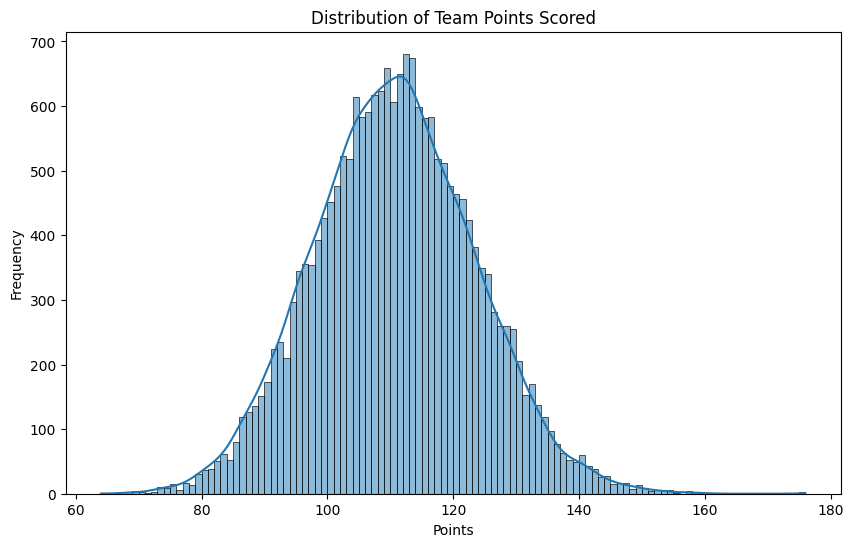

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df_team['PTS'], kde=True, binwidth=1.0)
plt.title('Distribution of Team Points Scored')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.show()

In [13]:
df_team.head()

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,PLUS_MINUS,OFF_RATING,DEF_RATING,NET_RATING,PACE,PIE,PCT_PTS_2PT_MR,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,DEFENSIVE_BOX_OUTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,deflections,DIST,TCHS,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,OPP_FGM_C,OPP_FGA_C,OPP_FGM_F,OPP_FGA_F,OPP_FGM_G,OPP_FGA_G,OPP_FG3M_C,OPP_FG3A_C,OPP_FG3M_F,OPP_FG3A_F,OPP_FG3M_G,OPP_FG3A_G,OPP_FTM_C,OPP_FTM_F,OPP_FTM_G,OPP_FTA_C,OPP_FTA_F,OPP_FTA_G,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,BLOCKS,BLOCKED_ATT,PF,PFD,FGM_RESTRICTED,FGA_RESTRICTED,FGM_PAINT_NON_RA,FGA_PAINT_NON_RA,FGM_MIDRANGE,FGA_MIDRANGE,FGM_CORNER3,FGA_CORNER3,FGM_ABOVE_BREAK3,FGA_ABOVE_BREAK3,IS_HOME
0,2016-17,1610612739,CLE,0021600001,2016-10-25,CLE vs. NYK,W,240,117,45,94,13,35,14,19,11,40,51,31,15,12,5,29,115.8,87.1,28.7,101.0,0.703,0.103,0.625,0.375,0.846,0.154,0,46,19,16,17.12,441,314,17,39,28,55,10,18,4.4,10.2,15.6,47.4,16.6,42.2,1.0,2.8,4.4,15.6,5.0,14.0,1.0,9.2,6.8,1.6,11.6,9.6,21.0,16.0,16.0,52.0,14.0,16.0,9.0,28.0,5,6,22,22,23.0,36.0,3.0,7.0,6.0,16.0,6.0,12.0,7.0,23.0,1
1,2016-17,1610612744,GSW,0021600003,2016-10-25,GSW vs. SAS,L,240,100,40,85,7,33,13,18,8,27,35,24,16,11,6,-29,99.0,129.0,-30.0,100.5,0.400,0.180,0.576,0.424,0.714,0.286,0,62,21,23,16.90,397,277,21,38,19,47,20,32,5.2,10.8,22.0,45.6,25.6,53.4,1.0,2.2,6.0,11.6,7.0,13.4,2.4,10.6,13.2,2.6,12.2,15.0,15.0,4.0,20.0,48.0,17.0,26.0,24.0,50.0,6,3,19,19,17.0,25.0,7.0,12.0,9.0,15.0,1.0,10.0,6.0,22.0,1
2,2016-17,1610612752,NYK,0021600001,2016-10-25,NYK @ CLE,L,240,88,32,87,9,27,15,20,13,29,42,17,18,6,6,-29,87.1,115.8,-28.7,101.0,0.297,0.205,0.391,0.609,0.889,0.111,0,39,26,9,17.29,408,287,12,31,20,56,21,31,8.0,18.6,19.6,41.4,20.2,40.8,2.0,6.2,5.4,15.0,6.0,15.4,2.2,5.8,7.2,3.0,7.8,9.8,14.0,16.0,9.0,28.0,21.0,16.0,16.0,52.0,6,5,22,22,10.0,22.0,4.0,8.0,9.0,30.0,3.0,5.0,6.0,21.0,0
3,2016-17,1610612757,POR,0021600002,2016-10-25,POR vs. UTA,W,240,113,39,75,13,19,22,22,5,29,34,22,13,5,3,9,122.8,114.3,8.5,91.5,0.548,0.159,0.500,0.500,0.692,0.308,0,44,18,9,16.65,362,255,19,43,20,32,14,20,4.6,8.0,21.6,43.8,20.6,43.2,1.4,2.6,4.4,13.4,3.6,11.8,2.2,7.6,7.0,2.2,7.6,7.0,20.0,15.0,4.0,34.0,8.0,4.0,8.0,50.0,3,5,18,19,10.0,21.0,7.0,17.0,9.0,18.0,1.0,3.0,12.0,16.0,1
4,2016-17,1610612759,SAS,0021600003,2016-10-25,SAS @ GSW,W,240,129,47,98,12,24,23,26,21,34,55,25,14,13,3,29,129.0,99.0,30.0,100.5,0.600,0.155,0.429,0.571,0.833,0.167,0,34,30,19,17.76,471,339,23,45,24,53,16,23,7.8,17.0,22.2,47.0,20.2,42.0,1.4,6.6,4.0,18.2,3.0,15.6,1.6,7.8,7.2,2.8,10.0,10.2,17.0,26.0,24.0,50.0,15.0,4.0,20.0,48.0,3,6,19,19,18.0,31.0,7.0,17.0,10.0,26.0,4.0,7.0,8.0,17.0,0


C:\Users\Jordan Nishimura\AppData\Local\Temp\ipykernel_6724\4154937972.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


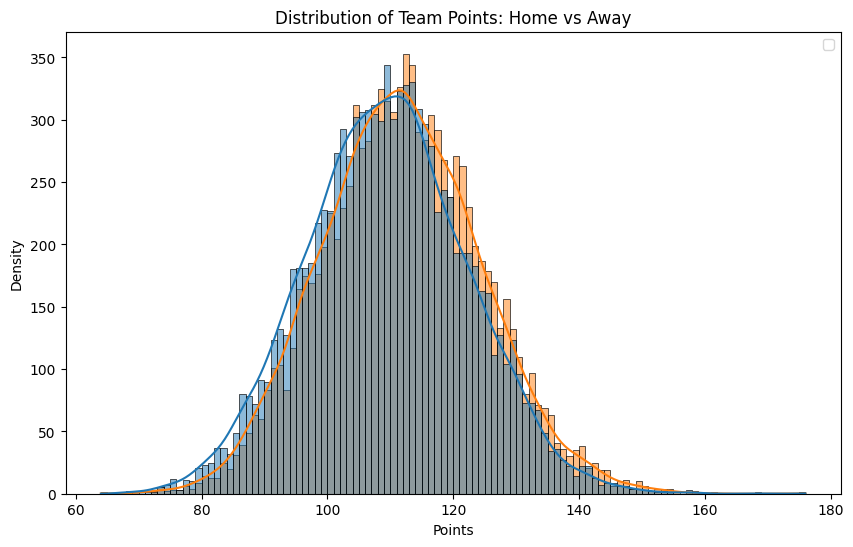

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(df_team, x='PTS', hue='IS_HOME', kde=True, binwidth=1.0, legend=True)

plt.title('Distribution of Team Points: Home vs Away')
plt.xlabel('Points')
plt.ylabel('Density')
plt.legend()
plt.show()

In [15]:
def clean_team_data(df):
    """This function cleans the team_data
    1) Changes W/L to 1/0 
    2) Changes franchise abbreviations to their most 
    recent abbreviation for consistency
    3) Converts GAME_DATE to datetime object
    4) Creates a binary column 'HOME_GAME'
    5) Removes 3 games where advanced stats were not collected
    """
    df = df.copy()
    df['WL'] = (df['WL'] == 'W').astype(int)
    df = df.rename(columns={'SEASON_YEAR': 'SEASON'})

    abbr_mapping = {'NJN': 'BKN',
                    'CHH': 'CHA',
                    'VAN': 'MEM',
                    'NOH': 'NOP',
                    'NOK': 'NOP',
                    'SEA': 'OKC'}

    df['TEAM_ABBREVIATION'] = df['TEAM_ABBREVIATION'].replace(abbr_mapping)
    df['MATCHUP'] = df['MATCHUP'].str.replace('NJN', 'BKN')
    df['MATCHUP'] = df['MATCHUP'].str.replace('CHH', 'CHA')
    df['MATCHUP'] = df['MATCHUP'].str.replace('VAN', 'MEM')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOH', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOK', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('SEA', 'OKC')

    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
    
    df = df.fillna(0)
    
    return df


df_team_clean = clean_team_data(df_team)


In [16]:
pd.options.display.max_rows = 100

# df_player_clean.loc[df_player['FGA_ABOVE_BREAK3'].isnull()]
df_team_clean[df_team_clean.isnull().any(axis=1)].groupby('SEASON').size().reset_index(name='rows_with_null')


,SEASON,rows_with_null


In [17]:
def prep_for_aggregation_team(df):
    """This function...
    1) Removes categories that are percentages,
    as we will be averaging them and do not want to average 
    percentages. 
    2) Converts shooting percentage stats into raw values"""

    df['FG2M'] = df['FGM'] - df['FG3M']
    df['FG2A'] = df['FGA'] - df['FG3A']
    df['PTS_2PT_MR'] = (df['PTS'] * df['PCT_PTS_2PT_MR']) #.astype('int8')
    df['AST_2PM'] = (df['FG2M'] * df['PCT_AST_2PM']) #.astype('int8')
    df['AST_3PM'] = (df['FG3M'] * df['PCT_AST_3PM']) #.astype('int8')
    df['UAST_2PM'] = (df['FG2M'] * df['PCT_UAST_2PM']) #.astype('int8')
    df['UAST_3PM'] = (df['FG3M'] * df['PCT_UAST_3PM']) #.astype('int8')

    df['OPP_FG2M_G'] = df['OPP_FGM_G'] - df['OPP_FG3M_G']
    df['OPP_FG2A_G'] = df['OPP_FGA_G'] - df['OPP_FG3A_G']

    df['OPP_FG2M_F'] = df['OPP_FGM_F'] - df['OPP_FG3M_F']
    df['OPP_FG2A_F'] = df['OPP_FGA_F'] - df['OPP_FG3A_F']
    
    df['OPP_FG2M_C'] = df['OPP_FGM_C'] - df['OPP_FG3M_C']
    df['OPP_FG2A_C'] = df['OPP_FGA_C'] - df['OPP_FG3A_C']

    df['POINT_DIFF'] = df['PLUS_MINUS']
    df['RECORD'] = df['WL']
    df['TEAM_SCORE'] = df['PTS']
    
    # percentage_columns = [x for x in df.columns if 'PCT' in x]
    drop_cols= ['OPP_FGM_G', 'OPP_FGA_G', 'OPP_FGM_F', 'OPP_FGA_F', 'OPP_FGM_C', 'OPP_FGA_C']
    #                       'MIN', 'PIE', 'PIE']
        
    df = df.drop(columns = drop_cols)
    
    ## Reorder Columns


    return df


df_team_clean2 = prep_for_aggregation_team(df_team_clean)

df_team_clean2

,SEASON,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,PLUS_MINUS,OFF_RATING,DEF_RATING,NET_RATING,PACE,PIE,PCT_PTS_2PT_MR,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,DEFENSIVE_BOX_OUTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,deflections,DIST,TCHS,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,OPP_FG3M_C,OPP_FG3A_C,OPP_FG3M_F,OPP_FG3A_F,OPP_FG3M_G,OPP_FG3A_G,OPP_FTM_C,OPP_FTM_F,OPP_FTM_G,OPP_FTA_C,OPP_FTA_F,OPP_FTA_G,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,BLOCKS,BLOCKED_ATT,PF,PFD,FGM_RESTRICTED,FGA_RESTRICTED,FGM_PAINT_NON_RA,FGA_PAINT_NON_RA,FGM_MIDRANGE,FGA_MIDRANGE,FGM_CORNER3,FGA_CORNER3,FGM_ABOVE_BREAK3,FGA_ABOVE_BREAK3,IS_HOME,FG2M,FG2A,PTS_2PT_MR,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,OPP_FG2M_G,OPP_FG2A_G,OPP_FG2M_F,OPP_FG2A_F,OPP_FG2M_C,OPP_FG2A_C,POINT_DIFF,RECORD,TEAM_SCORE
0,2016-17,1610612739,CLE,0021600001,2016-10-25,CLE vs. NYK,1,240,117,45,94,13,35,14,19,11,40,51,31,15,12,5,29,115.8,87.1,28.7,101.0,0.703,0.103,0.625,0.375,0.846,0.154,0,46,19,16,17.12,441,314,17,39,28,55,10,18,1.0,2.8,4.4,15.6,5.0,14.0,1.0,9.2,6.8,1.6,11.6,9.6,21.0,16.0,16.0,52.0,14.0,16.0,9.0,28.0,5,6,22,22,23.0,36.0,3.0,7.0,6.0,16.0,6.0,12.0,7.0,23.0,1,32,59,12.051,20.000,10.998,12.000,2.002,11.6,28.2,11.2,31.8,3.4,7.4,29,1,117
1,2016-17,1610612744,GSW,0021600003,2016-10-25,GSW vs. SAS,0,240,100,40,85,7,33,13,18,8,27,35,24,16,11,6,-29,99.0,129.0,-30.0,100.5,0.400,0.180,0.576,0.424,0.714,0.286,0,62,21,23,16.90,397,277,21,38,19,47,20,32,1.0,2.2,6.0,11.6,7.0,13.4,2.4,10.6,13.2,2.6,12.2,15.0,15.0,4.0,20.0,48.0,17.0,26.0,24.0,50.0,6,3,19,19,17.0,25.0,7.0,12.0,9.0,15.0,1.0,10.0,6.0,22.0,1,33,52,18.000,19.008,4.998,13.992,2.002,18.6,40.0,16.0,34.0,4.2,8.6,-29,0,100
2,2016-17,1610612752,NYK,0021600001,2016-10-25,NYK @ CLE,0,240,88,32,87,9,27,15,20,13,29,42,17,18,6,6,-29,87.1,115.8,-28.7,101.0,0.297,0.205,0.391,0.609,0.889,0.111,0,39,26,9,17.29,408,287,12,31,20,56,21,31,2.0,6.2,5.4,15.0,6.0,15.4,2.2,5.8,7.2,3.0,7.8,9.8,14.0,16.0,9.0,28.0,21.0,16.0,16.0,52.0,6,5,22,22,10.0,22.0,4.0,8.0,9.0,30.0,3.0,5.0,6.0,21.0,0,23,60,18.040,8.993,8.001,14.007,0.999,14.2,25.4,14.2,26.4,6.0,12.4,-29,0,88
3,2016-17,1610612757,POR,0021600002,2016-10-25,POR vs. UTA,1,240,113,39,75,13,19,22,22,5,29,34,22,13,5,3,9,122.8,114.3,8.5,91.5,0.548,0.159,0.500,0.500,0.692,0.308,0,44,18,9,16.65,362,255,19,43,20,32,14,20,1.4,2.6,4.4,13.4,3.6,11.8,2.2,7.6,7.0,2.2,7.6,7.0,20.0,15.0,4.0,34.0,8.0,4.0,8.0,50.0,3,5,18,19,10.0,21.0,7.0,17.0,9.0,18.0,1.0,3.0,12.0,16.0,1,26,56,17.967,13.000,8.996,13.000,4.004,17.0,31.4,17.2,30.4,3.2,5.4,9,1,113
4,2016-17,1610612759,SAS,0021600003,2016-10-25,SAS @ GSW,1,240,129,47,98,12,24,23,26,21,34,55,25,14,13,3,29,129.0,99.0,30.0,100.5,0.600,0.155,0.429,0.571,0.833,0.167,0,34,30,19,17.76,471,339,23,45,24,53,16,23,1.4,6.6,4.0,18.2,3.0,15.6,1.6,7.8,7.2,2.8,10.0,10.2,17.0,26.0,24.0,50.0,15.0,4.0,20.0,48.0,3,6,19,19,18.0,31.0,7.0,17.0,10.0,26.0,4.0,7.0,8.0,17.0,0,35,74,19.995,15.015,9.996,19.985,2.004,17.2,26.4,18.2,28.8,6.4,10.4,29,1,129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20411,2023-24,1610612742,DAL,0042300403,2024-06-12,DAL vs. BOS,0,240,99,38,86,9,25,14,16,7,36,43,15,9,5,1,-7,106.5,115.2,-8.8,92.5,0.456,0.061,0.345,0.655,0.556,0.444,5,13,22,5,17.05,341,225,16,38,22,48,13,19,3.2,8.8,9.8,25.8,9.0,24.8,2.6,7.0,7.2,2.8,7.4,7.8,12.0,14.0,12.0,52.0,13.0,6.0,12.0,36.0,1,6,17,19,15.0,26.0,11.0,28.0,3.0,7.0,3.0,6.0,6.0,19.0,1,29,61,6.039,10.005,5.004,18.995,3.996,11.0,19.2,12.6,21.2,4.0,7.0,-7,0,99
20412,2023-24,1610612738,BOS,0042300404,2024-06-14,BOS @ DAL,0,240,84,29,80,14,41,12,13,4,27,3

In [18]:
def create_matchups(df):
    """This function makes each row a matchup between 
    team and opp"""
    keep_cols = ['SEASON', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL']
    stat_cols = [x for x in df.columns if x not in keep_cols]
    

    
    matchups = pd.merge(df, df, how='left', on=['GAME_ID'], suffixes=['', '_opp'])
    matchups = matchups.loc[matchups['TEAM_ID'] != matchups['TEAM_ID_opp']]

    matchups = matchups.drop(columns = ['SEASON_opp', 'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp', 'GAME_DATE_opp',
                                         'MATCHUP_opp', 'TEAM_ID_opp', 'WL_opp']
                 )
    
    matchups
    
    return matchups


matchups = create_matchups(df_team_clean2)
matchups

,SEASON,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,PLUS_MINUS,OFF_RATING,DEF_RATING,NET_RATING,PACE,PIE,PCT_PTS_2PT_MR,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,DEFENSIVE_BOX_OUTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,deflections,DIST,TCHS,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,OPP_FG3M_C,OPP_FG3A_C,OPP_FG3M_F,OPP_FG3A_F,OPP_FG3M_G,OPP_FG3A_G,OPP_FTM_C,OPP_FTM_F,OPP_FTM_G,OPP_FTA_C,OPP_FTA_F,OPP_FTA_G,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,BLOCKS,BLOCKED_ATT,PF,PFD,FGM_RESTRICTED,FGA_RESTRICTED,FGM_PAINT_NON_RA,FGA_PAINT_NON_RA,FGM_MIDRANGE,FGA_MIDRANGE,FGM_CORNER3,FGA_CORNER3,FGM_ABOVE_BREAK3,FGA_ABOVE_BREAK3,IS_HOME,FG2M,FG2A,PTS_2PT_MR,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,OPP_FG2M_G,OPP_FG2A_G,OPP_FG2M_F,OPP_FG2A_F,OPP_FG2M_C,OPP_FG2A_C,POINT_DIFF,RECORD,TEAM_SCORE,MIN_opp,PTS_opp,FGM_opp,FGA_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,TOV_opp,STL_opp,BLK_opp,PLUS_MINUS_opp,OFF_RATING_opp,DEF_RATING_opp,NET_RATING_opp,PACE_opp,PIE_opp,PCT_PTS_2PT_MR_opp,PCT_AST_2PM_opp,PCT_UAST_2PM_opp,PCT_AST_3PM_opp,PCT_UAST_3PM_opp,DEFENSIVE_BOX_OUTS_opp,CONTESTED_SHOTS_2PT_opp,CONTESTED_SHOTS_3PT_opp,deflections_opp,DIST_opp,TCHS_opp,PASS_opp,CFGM_opp,CFGA_opp,UFGM_opp,UFGA_opp,DFGM_opp,DFGA_opp,OPP_FG3M_C_opp,OPP_FG3A_C_opp,OPP_FG3M_F_opp,OPP_FG3A_F_opp,OPP_FG3M_G_opp,OPP_FG3A_G_opp,OPP_FTM_C_opp,OPP_FTM_F_opp,OPP_FTM_G_opp,OPP_FTA_C_opp,OPP_FTA_F_opp,OPP_FTA_G_opp,PTS_OFF_TOV_opp,PTS_2ND_CHANCE_opp,PTS_FB_opp,PTS_PAINT_opp,OPP_PTS_OFF_TOV_opp,OPP_PTS_2ND_CHANCE_opp,OPP_PTS_FB_opp,OPP_PTS_PAINT_opp,BLOCKS_opp,BLOCKED_ATT_opp,PF_opp,PFD_opp,FGM_RESTRICTED_opp,FGA_RESTRICTED_opp,FGM_PAINT_NON_RA_opp,FGA_PAINT_NON_RA_opp,FGM_MIDRANGE_opp,FGA_MIDRANGE_opp,FGM_CORNER3_opp,FGA_CORNER3_opp,FGM_ABOVE_BREAK3_opp,FGA_ABOVE_BREAK3_opp,IS_HOME_opp,FG2M_opp,FG2A_opp,PTS_2PT_MR_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp,OPP_FG2M_G_opp,OPP_FG2A_G_opp,OPP_FG2M_F_opp,OPP_FG2A_F_opp,OPP_FG2M_C_opp,OPP_FG2A_C_opp,POINT_DIFF_opp,RECORD_opp,TEAM_SCORE_opp
1,2016-17,1610612739,CLE,0021600001,2016-10-25,CLE vs. NYK,1,240,117,45,94,13,35,14,19,11,40,51,31,15,12,5,29,115.8,87.1,28.7,101.0,0.703,0.103,0.625,0.375,0.846,0.154,0,46,19,16,17.12,441,314,17,39,28,55,10,18,1.0,2.8,4.4,15.6,5.0,14.0,1.0,9.2,6.8,1.6,11.6,9.6,21.0,16.0,16.0,52.0,14.0,16.0,9.0,28.0,5,6,22,22,23.0,36.0,3.0,7.0,6.0,16.0,6.0,12.0,7.0,23.0,1,32,59,12.051,20.000,10.998,12.000,2.002,11.6,28.2,11.2,31.8,3.4,7.4,29,1,117,240,88,32,87,9,27,15,20,13,29,42,17,18,6,6,-29,87.1,115.8,-28.7,101.0,0.297,0.205,0.391,0.609,0.889,0.111,0,39,26,9,17.29,408,287,12,31,20,56,21,31,2.0,6.2,5.4,15.0,6.0,15.4,2.2,5.8,7.2,3.0,7.8,9.8,14.0,16.0,9.0,28.0,21.0,16.0,16.0,52.0,6,5,22,22,10.0,22.0,4.0,8.0,9.0,30.0,3.0,5.0,6.0,21.0,0,23,60,18.040,8.993,8.001,14.007,0.999,14.2,25.4,14.2,26.4,6.0,12.4,-29,0,88
3,2016-17,1610612744,GSW,0021600003,2016-10-25,GSW vs. SAS,0,240,100,40,85,7,33,13,18,8,27,35,24,16,11,6,-29,99.0,129.0,-30.0,100.5,0.400,0.180,0.576,0.424,0.714,0.286,0,62,21,23,16.90,397,277,21,38,19,47,20,32,1.0,2.2,6.0,11.6,7.0,13.4,2.4,10.6,13.2,2.6,12.2,15.0,15.0,4.0,20.0,48.0,17.0,26.0,24.0,50.0,6,3,19,19,17.0,25.0,7.0,12.0,9.0,15.0,1.0,10.0,6.0,22.0,1,33,52,18.000,19.008,4.998,13.992,2.002,18.6,40.0,16.0,34.0,4.2,8.6,-29,0,100,240,129,47,98,12,24,23,26,21,34,55,25,14,13,3,29,129.0,99.0,30.0,100.5,0.600,0.155,0.429,0.571,0.833,0.167,0,34,30,19,17.76,471,339,23,45,24,53,16,23,1.4,6.6,4.0,18.2,3.0,15.6,1.6,7.8,7.2,2.8,10.0,10.2,17.0,26.0,24.0,50.0,15.0,4.0,20.0,48.0,3,6,19,19,18.0,31.0,7.0,17.0,10.0,26.0,4.0,7.0,8.0,17.0,0,35,74,19.995,15.015,9.996,19.985,2.004,17.2,26.4,18.2,28.8,6.4,10.4,29,1,129
4,2016-17,1610612752,NYK,0021600001,2016-10-25,NYK @ CLE,0,240,88,32,87,9,27,15,20,13,29,42,17,18,6,6,-29,87.1,115.8,-28.7,101.0,0.297,0.205,0.391,0.609,0.889,0.111,0,39,26,9,17.29,408,287,12,31,20,56,21,31,2.0,6.2,5.4,15.0,6.0,15.4,2.2,5

In [19]:
matchups.columns.tolist()

['SEASON',
 'TEAM_ID',
 'TEAM_ABBREVIATION',
 'GAME_ID',
 'GAME_DATE',
 'MATCHUP',
 'WL',
 'MIN',
 'PTS',
 'FGM',
 'FGA',
 'FG3M',
 'FG3A',
 'FTM',
 'FTA',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'PLUS_MINUS',
 'OFF_RATING',
 'DEF_RATING',
 'NET_RATING',
 'PACE',
 'PIE',
 'PCT_PTS_2PT_MR',
 'PCT_AST_2PM',
 'PCT_UAST_2PM',
 'PCT_AST_3PM',
 'PCT_UAST_3PM',
 'DEFENSIVE_BOX_OUTS',
 'CONTESTED_SHOTS_2PT',
 'CONTESTED_SHOTS_3PT',
 'deflections',
 'DIST',
 'TCHS',
 'PASS',
 'CFGM',
 'CFGA',
 'UFGM',
 'UFGA',
 'DFGM',
 'DFGA',
 'OPP_FG3M_C',
 'OPP_FG3A_C',
 'OPP_FG3M_F',
 'OPP_FG3A_F',
 'OPP_FG3M_G',
 'OPP_FG3A_G',
 'OPP_FTM_C',
 'OPP_FTM_F',
 'OPP_FTM_G',
 'OPP_FTA_C',
 'OPP_FTA_F',
 'OPP_FTA_G',
 'PTS_OFF_TOV',
 'PTS_2ND_CHANCE',
 'PTS_FB',
 'PTS_PAINT',
 'OPP_PTS_OFF_TOV',
 'OPP_PTS_2ND_CHANCE',
 'OPP_PTS_FB',
 'OPP_PTS_PAINT',
 'BLOCKS',
 'BLOCKED_ATT',
 'PF',
 'PFD',
 'FGM_RESTRICTED',
 'FGA_RESTRICTED',
 'FGM_PAINT_NON_RA',
 'FGA_PAINT_NON_RA',
 'FGM_MIDRANGE',
 'FGA_M

In [20]:
def calculate_ewa_multiple_spans(df: pd.DataFrame, group_col: str, value_col: str, spans: list, team_level: bool) -> pd.DataFrame:
   
    df = df.sort_values([group_col, 'GAME_DATE'])
    
    ewa_df = pd.DataFrame()
    for span in tqdm(spans):
        col_name = f'EWA_{span}'
        ewa_df[col_name] = df.groupby(group_col)[value_col].transform(
            lambda x: x.ewm(span=span, adjust=False).mean().shift(1)
        )
    
    return ewa_df


def evaluate_ewa_multiple_spans(df: pd.DataFrame, actual_col: str, ewa_cols: list) -> pd.DataFrame:
    results = []
    for col in ewa_cols:
        # Remove rows where either the actual value or the EWA is NaN
        valid_data = df[[actual_col, col]].dropna()
        
        if len(valid_data) > 0:
            mae = mean_absolute_error(valid_data[actual_col], valid_data[col])
            mse = mean_squared_error(valid_data[actual_col], valid_data[col])
            span = int(col.split('_')[1])  # Extract span from column name
            results.append({'span': span, 'mae': mae, 'mse': mse})
    
    return pd.DataFrame(results)


def find_optimal_span(df: pd.DataFrame, group_col: str, value_col: str, spans: list, team_level: bool) -> int:

    ewa_df = calculate_ewa_multiple_spans(df, group_col, value_col, spans, team_level)
    ewa_cols = ewa_df.columns
    
    df_with_ewa = pd.concat([df[[group_col, 'GAME_DATE', value_col]], ewa_df], axis=1)
    
    eval_results = evaluate_ewa_multiple_spans(df_with_ewa, value_col, ewa_cols)
    optimal_span = eval_results.loc[eval_results['mae'].idxmin(), 'span']
    
    return optimal_span


def optimize_spans(df: pd.DataFrame, group_col: str, features: list, spans: list, team_level: bool) -> dict:
    optimal_spans = {}
    for feature in features:
        print(feature)
        optimal_span = find_optimal_span(df, group_col, feature, spans, team_level)
        optimal_spans[feature] = optimal_span
    return optimal_spans


# Define spans to test
spans = list(range(5, 53, 1))

# Team-level optimization
team_non_stat_cols = ['SEASON', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 
                      'WL', 'MIN', 'POINT_DIFF', 'RECORD', 'TEAM_SCORE', 'IS_HOME',
                      'WL_opp', 'MIN_opp', 'POINT_DIFF_opp', 'RECORD_opp', 'TEAM_SCORE_opp', 'IS_HOME_opp']
team_features = [col for col in matchups.columns if col not in team_non_stat_cols]

team_optimal_spans = optimize_spans(matchups, 'TEAM_ID', team_features, spans, team_level=True)


PTS


  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [00:00<00:00, 84.81it/s]


FGM


100%|██████████| 48/48 [00:00<00:00, 100.84it/s]


FGA


100%|██████████| 48/48 [00:00<00:00, 88.24it/s]


FG3M


100%|██████████| 48/48 [00:00<00:00, 80.40it/s]


FG3A


 81%|████████▏ | 39/48 [00:00<00:00, 97.26it/s] 


KeyboardInterrupt: 

In [21]:
team_optimal_spans = {"PTS": 29,
    "FGM": 33,
    "FGA": 32,
    "FG3M": 28,
    "FG3A": 19,
    "FTM": 37,
    "FTA": 37,
    "OREB": 33,
    "DREB": 37,
    "REB": 33,
    "AST": 30,
    "TOV": 39,
    "STL": 36,
    "BLK": 35,
    "PLUS_MINUS": 38,
    "OFF_RATING": 37,
    "DEF_RATING": 43,
    "NET_RATING": 39,
    "PACE": 17,
    "PIE": 37,
    "PCT_PTS_2PT_MR": 20,
    "PCT_AST_2PM": 31,
    "PCT_UAST_2PM": 31,
    "PCT_AST_3PM": 37,
    "PCT_UAST_3PM": 38,
    "DEFENSIVE_BOX_OUTS": 11,
    "CONTESTED_SHOTS_2PT": 24,
    "CONTESTED_SHOTS_3PT": 25,
    "deflections": 30,
    "DIST": 43,
    "TCHS": 31,
    "PASS": 22,
    "CFGM": 29,
    "CFGA": 26,
    "UFGM": 34,
    "UFGA": 32,
    "DFGM": 31,
    "DFGA": 29,
    "OPP_FG3M_C": 10,
    "OPP_FG3A_C": 7,
    "OPP_FG3M_F": 18,
    "OPP_FG3A_F": 11,
    "OPP_FG3M_G": 19,
    "OPP_FG3A_G": 12,
    "OPP_FTM_C": 12,
    "OPP_FTM_F": 20,
    "OPP_FTM_G": 21,
    "OPP_FTA_C": 11,
    "OPP_FTA_F": 18,
    "OPP_FTA_G": 19,
    "PTS_OFF_TOV": 45,
    "PTS_2ND_CHANCE": 37,
    "PTS_FB": 31,
    "PTS_PAINT": 27,
    "OPP_PTS_OFF_TOV": 47,
    "OPP_PTS_2ND_CHANCE": 47,
    "OPP_PTS_FB": 52,
    "OPP_PTS_PAINT": 32,
    "BLOCKS": 35,
    "BLOCKED_ATT": 40,
    "PF": 33,
    "PFD": 29,
    "FGM_RESTRICTED": 25,
    "FGA_RESTRICTED": 24,
    "FGM_PAINT_NON_RA": 35,
    "FGA_PAINT_NON_RA": 27,
    "FGM_MIDRANGE": 21,
    "FGA_MIDRANGE": 16,
    "FGM_CORNER3": 44,
    "FGA_CORNER3": 35,
    "FGM_ABOVE_BREAK3": 31,
    "FGA_ABOVE_BREAK3": 21,
    "FG2M": 26,
    "FG2A": 22,
    "PTS_2PT_MR": 21,
    "AST_2PM": 24,
    "AST_3PM": 31,
    "UAST_2PM": 31,
    "UAST_3PM": 36,
    "OPP_FG2M_G": 11,
    "OPP_FG2A_G": 9,
    "OPP_FG2M_F": 9,
    "OPP_FG2A_F": 8,
    "OPP_FG2M_C": 7,
    "OPP_FG2A_C": 6,
    "PTS_opp": 32,
    "FGM_opp": 34,
    "FGA_opp": 28,
    "FG3M_opp": 36,
    "FG3A_opp": 28,
    "FTM_opp": 43,
    "FTA_opp": 41,
    "OREB_opp": 50,
    "DREB_opp": 39,
    "REB_opp": 39,
    "AST_opp": 40,
    "TOV_opp": 34,
    "STL_opp": 41,
    "BLK_opp": 40,
    "PLUS_MINUS_opp": 38,
    "OFF_RATING_opp": 43,
    "DEF_RATING_opp": 37,
    "NET_RATING_opp": 39,
    "PACE_opp": 17,
    "PIE_opp": 36,
    "PCT_PTS_2PT_MR_opp": 35,
    "PCT_AST_2PM_opp": 43,
    "PCT_UAST_2PM_opp": 43,
    "PCT_AST_3PM_opp": 44,
    "PCT_UAST_3PM_opp": 44,
    "DEFENSIVE_BOX_OUTS_opp": 10,
    "CONTESTED_SHOTS_2PT_opp": 22,
    "CONTESTED_SHOTS_3PT_opp": 21,
    "deflections_opp": 36,
    "DIST_opp": 48,
    "TCHS_opp": 41,
    "PASS_opp": 39,
    "CFGM_opp": 36,
    "CFGA_opp": 33,
    "UFGM_opp": 44,
    "UFGA_opp": 36,
    "DFGM_opp": 26,
    "DFGA_opp": 24,
    "OPP_FG3M_C_opp": 52,
    "OPP_FG3A_C_opp": 50,
    "OPP_FG3M_F_opp": 36,
    "OPP_FG3A_F_opp": 30,
    "OPP_FG3M_G_opp": 33,
    "OPP_FG3A_G_opp": 30,
    "OPP_FTM_C_opp": 44,
    "OPP_FTM_F_opp": 40,
    "OPP_FTM_G_opp": 46,
    "OPP_FTA_C_opp": 44,
    "OPP_FTA_F_opp": 40,
    "OPP_FTA_G_opp": 42,
    "PTS_OFF_TOV_opp": 47,
    "PTS_2ND_CHANCE_opp": 47,
    "PTS_FB_opp": 52,
    "PTS_PAINT_opp": 32,
    "OPP_PTS_OFF_TOV_opp": 45,
    "OPP_PTS_2ND_CHANCE_opp": 37,
    "OPP_PTS_FB_opp": 31,
    "OPP_PTS_PAINT_opp": 27,
    "BLOCKS_opp": 40,
    "BLOCKED_ATT_opp": 35,
    "PF_opp": 29,
    "PFD_opp": 33,
    "FGM_RESTRICTED_opp": 31,
    "FGA_RESTRICTED_opp": 30,
    "FGM_PAINT_NON_RA_opp": 52,
    "FGA_PAINT_NON_RA_opp": 51,
    "FGM_MIDRANGE_opp": 40,
    "FGA_MIDRANGE_opp": 30,
    "FGM_CORNER3_opp": 48,
    "FGA_CORNER3_opp": 36,
    "FGM_ABOVE_BREAK3_opp": 46,
    "FGA_ABOVE_BREAK3_opp": 35,
    "FG2M_opp": 31,
    "FG2A_opp": 26,
    "PTS_2PT_MR_opp": 40,
    "AST_2PM_opp": 37,
    "AST_3PM_opp": 38,
    "UAST_2PM_opp": 35,
    "UAST_3PM_opp": 52,
    "OPP_FG2M_G_opp": 40,
    "OPP_FG2A_G_opp": 34,
    "OPP_FG2M_F_opp": 34,
    "OPP_FG2A_F_opp": 33,
    "OPP_FG2M_C_opp": 52,
    "OPP_FG2A_C_opp": 49
}

In [22]:
def apply_optimal_spans(df: pd.DataFrame, optimal_spans: dict, grouping_col: str) -> pd.DataFrame:
    # Create a copy of the input DataFrame to avoid modifying the original
    df = df.copy()
    
    # Sort the DataFrame
    df = df.sort_values([grouping_col, 'GAME_DATE'])
    
    # Pre-calculate all EWA columns at once
    ewa_columns = {}
    
    for feature, span in optimal_spans.items():
        grouped = df.groupby(grouping_col)[feature]
        ewa_values = grouped.transform(
            lambda x: x.ewm(span=span, adjust=False).mean().shift(1)
        )
        ewa_columns[f'{feature}_EWA'] = ewa_values
    
    # Combine all new columns at once using concat
    result = pd.concat([df, pd.DataFrame(ewa_columns)], axis=1)
    
    return result


df_team_with_ewa = apply_optimal_spans(matchups, team_optimal_spans, 'TEAM_ID')
df_team_with_ewa

,SEASON,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,PLUS_MINUS,OFF_RATING,DEF_RATING,NET_RATING,PACE,PIE,PCT_PTS_2PT_MR,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,DEFENSIVE_BOX_OUTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,deflections,DIST,TCHS,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,OPP_FG3M_C,OPP_FG3A_C,OPP_FG3M_F,OPP_FG3A_F,OPP_FG3M_G,OPP_FG3A_G,OPP_FTM_C,OPP_FTM_F,OPP_FTM_G,OPP_FTA_C,OPP_FTA_F,OPP_FTA_G,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,BLOCKS,BLOCKED_ATT,PF,PFD,FGM_RESTRICTED,FGA_RESTRICTED,FGM_PAINT_NON_RA,FGA_PAINT_NON_RA,FGM_MIDRANGE,FGA_MIDRANGE,FGM_CORNER3,FGA_CORNER3,FGM_ABOVE_BREAK3,FGA_ABOVE_BREAK3,IS_HOME,FG2M,FG2A,PTS_2PT_MR,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,OPP_FG2M_G,OPP_FG2A_G,OPP_FG2M_F,OPP_FG2A_F,OPP_FG2M_C,OPP_FG2A_C,POINT_DIFF,RECORD,TEAM_SCORE,MIN_opp,PTS_opp,FGM_opp,FGA_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,TOV_opp,STL_opp,BLK_opp,PLUS_MINUS_opp,OFF_RATING_opp,DEF_RATING_opp,NET_RATING_opp,PACE_opp,PIE_opp,PCT_PTS_2PT_MR_opp,PCT_AST_2PM_opp,PCT_UAST_2PM_opp,PCT_AST_3PM_opp,PCT_UAST_3PM_opp,DEFENSIVE_BOX_OUTS_opp,CONTESTED_SHOTS_2PT_opp,CONTESTED_SHOTS_3PT_opp,deflections_opp,DIST_opp,TCHS_opp,PASS_opp,CFGM_opp,CFGA_opp,UFGM_opp,UFGA_opp,DFGM_opp,DFGA_opp,OPP_FG3M_C_opp,OPP_FG3A_C_opp,OPP_FG3M_F_opp,OPP_FG3A_F_opp,OPP_FG3M_G_opp,OPP_FG3A_G_opp,OPP_FTM_C_opp,OPP_FTM_F_opp,OPP_FTM_G_opp,OPP_FTA_C_opp,OPP_FTA_F_opp,OPP_FTA_G_opp,PTS_OFF_TOV_opp,PTS_2ND_CHANCE_opp,PTS_FB_opp,PTS_PAINT_opp,OPP_PTS_OFF_TOV_opp,OPP_PTS_2ND_CHANCE_opp,OPP_PTS_FB_opp,OPP_PTS_PAINT_opp,BLOCKS_opp,BLOCKED_ATT_opp,PF_opp,PFD_opp,FGM_RESTRICTED_opp,FGA_RESTRICTED_opp,FGM_PAINT_NON_RA_opp,FGA_PAINT_NON_RA_opp,FGM_MIDRANGE_opp,FGA_MIDRANGE_opp,FGM_CORNER3_opp,FGA_CORNER3_opp,FGM_ABOVE_BREAK3_opp,FGA_ABOVE_BREAK3_opp,IS_HOME_opp,FG2M_opp,FG2A_opp,PTS_2PT_MR_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp,OPP_FG2M_G_opp,OPP_FG2A_G_opp,OPP_FG2M_F_opp,OPP_FG2A_F_opp,OPP_FG2M_C_opp,OPP_FG2A_C_opp,POINT_DIFF_opp,RECORD_opp,TEAM_SCORE_opp,PTS_EWA,FGM_EWA,FGA_EWA,FG3M_EWA,FG3A_EWA,FTM_EWA,FTA_EWA,OREB_EWA,DREB_EWA,REB_EWA,AST_EWA,TOV_EWA,STL_EWA,BLK_EWA,PLUS_MINUS_EWA,OFF_RATING_EWA,DEF_RATING_EWA,NET_RATING_EWA,PACE_EWA,PIE_EWA,PCT_PTS_2PT_MR_EWA,PCT_AST_2PM_EWA,PCT_UAST_2PM_EWA,PCT_AST_3PM_EWA,PCT_UAST_3PM_EWA,DEFENSIVE_BOX_OUTS_EWA,CONTESTED_SHOTS_2PT_EWA,CONTESTED_SHOTS_3PT_EWA,deflections_EWA,DIST_EWA,TCHS_EWA,PASS_EWA,CFGM_EWA,CFGA_EWA,UFGM_EWA,UFGA_EWA,DFGM_EWA,DFGA_EWA,OPP_FG3M_C_EWA,OPP_FG3A_C_EWA,OPP_FG3M_F_EWA,OPP_FG3A_F_EWA,OPP_FG3M_G_EWA,OPP_FG3A_G_EWA,OPP_FTM_C_EWA,OPP_FTM_F_EWA,OPP_FTM_G_EWA,OPP_FTA_C_EWA,OPP_FTA_F_EWA,OPP_FTA_G_EWA,PTS_OFF_TOV_EWA,PTS_2ND_CHANCE_EWA,PTS_FB_EWA,PTS_PAINT_EWA,OPP_PTS_OFF_TOV_EWA,OPP_PTS_2ND_CHANCE_EWA,OPP_PTS_FB_EWA,OPP_PTS_PAINT_EWA,BLOCKS_EWA,BLOCKED_ATT_EWA,PF_EWA,PFD_EWA,FGM_RESTRICTED_EWA,FGA_RESTRICTED_EWA,FGM_PAINT_NON_RA_EWA,FGA_PAINT_NON_RA_EWA,FGM_MIDRANGE_EWA,FGA_MIDRANGE_EWA,FGM_CORNER3_EWA,FGA_CORNER3_EWA,FGM_ABOVE_BREAK3_EWA,FGA_ABOVE_BREAK3_EWA,FG2M_EWA,FG2A_EWA,PTS_2PT_MR_EWA,AST_2PM_EWA,AST_3PM_EWA,UAST_2PM_EWA,UAST_3PM_EWA,OPP_FG2M_G_EWA,OPP_FG2A_G_EWA,OPP_FG2M_F_EWA,OPP_FG2A_F_EWA,OPP_FG2M_C_EWA,OPP_FG2A_C_EWA,PTS_opp_EWA,FGM_opp_EWA,FGA_opp_EWA,FG3M_opp_EWA,FG3A_opp_EWA,FTM_opp_EWA,FTA_opp_EWA,OREB_opp_EWA,DREB_opp_EWA,REB_opp_EWA,AST_opp_EWA,TOV_opp_EWA,STL_opp_EWA,BLK_opp_EWA,PLUS_MINUS_opp_EWA,OFF_RATING_opp_EWA,DEF_RATING_opp_EWA,NET_RATING_opp_EWA,PACE_opp_EWA,PIE_opp_EWA,PCT_PTS_2PT_MR_opp_EWA,PCT_AST_2PM_opp_EWA,PCT_UAST_2PM_opp_EWA,PCT_AST_3PM_opp_EWA,PCT_UAST_3PM_opp_EWA,DEFENSIVE_BOX_OUTS_opp_EWA,CONTESTED_SHOTS_2PT_opp_EWA,CONTESTED_SHOTS_3PT_opp_EWA,deflections_opp_EWA,DIST_opp_EWA,TCHS_opp_EWA,PASS_opp_EWA,CFGM_opp_EWA,CFGA_opp_EWA,UFGM_opp_EWA,UFGA_opp_EWA,DFGM_opp_EWA,DFGA_opp_EWA,OPP_FG3M_C_opp_EWA,OPP_FG3A_C_opp_EWA,OPP_FG3M_F_opp_EWA,OPP_FG3A_F_opp_EWA,OPP_FG3M_G_opp_EWA,OPP_F

In [23]:
def add_percentage_features(df):
    """Add the following features for both team and opp:
    OREB_PCT, DREB_PCT, REB_PCT, TS_PCT, EFG_PCT, AST_RATIO, TOV_PCT, PIE.
    """
    
    df = df.copy()
    
    df['FG2_PCT'] = df['FG2M'] / df[f'FG2A']
    df['FG3_PCT'] = df['FG3M'] / df[f'FG3A']
    
    df['OREB_PCT'] = df['OREB'] / (df['OREB'] + df['DREB_opp'])
    df['OREB_PCT_opp'] = df['OREB_opp'] / (df['OREB_opp'] + df['DREB'])

    df['DREB_PCT'] = df['DREB'] / (df['DREB'] + df['OREB_opp'])
    df['DREB_PCT_opp'] = df['DREB_opp'] / (df['DREB_opp'] + df['OREB'])

    df['REB_PCT'] = df['REB'] / (df['REB'] + df['REB_opp'])
    df['REB_PCT_opp'] = df['REB_opp'] / (df['REB_opp'] + df['REB'])

    df['TS_PCT'] = df['PTS'] / ((2*(df['FG2A'] + df['FG3A']) + 0.44*df['FTA']))
    
    df['TS_PCT_opp'] = df['PTS_opp'] / ((2*(df['FG2A_opp'] + df['FG3A_opp']) + 0.44*df['FTA_opp']))

    df['EFG_PCT'] = (df['FG2M'] + 1.5*df['FG3M']) / (df['FG2A']
                                                                    + df['FG3A'])
    df['EFG_PCT_opp'] = (df['FG2M_opp'] + 1.5*df['FG3M_opp']) / (df['FG2A_opp'] 
                                                                 + df['FG3A_opp'])

    df['AST_RATIO'] = (df['AST'] * 100) / df['PACE']
    df['AST_RATIO_opp'] = (df['AST_opp'] * 100) / df['PACE_opp']

    df['TOV_PCT'] = 100*df['TOV'] / (df['FG2A'] 
                                               + df['FG3A'] 
                                               + 0.44*df['FTA'] 
                                               + df['TOV'])
    
    df['TOV_PCT_opp'] = 100*df['TOV_opp'] / (df['FG2A_opp'] 
                                             + df['FG3A_opp'] 
                                             + 0.44*df['FTA_opp'] 
                                             + df['TOV_opp'])
    
    
    df['PIE'] = ((df['PTS'] + df['FG2M'] + df['FG3M'] + df['FTM'] 
                 - df['FG2A'] - df['FG3A'] - df['FTA'] 
                 + df['DREB'] + df['OREB']/2
                + df['AST'] + df['STL'] + df['BLK']/2
                - df['PF'] - df['TOV']) 
                 / (df['PTS'] + df['PTS_opp'] + df['FG2M'] + df['FG2M_opp']
                   + df['FG3M'] + df['FG3M_opp'] + df['FTM'] + df['FTM_opp']
                   - df['FG2A'] - df['FG2A_opp'] - df['FG3A'] - df['FG3A_opp'] 
                    - df['FTA'] - df['FTA_opp'] + df['DREB'] + df['DREB_opp']
                    + (df['OREB']+df['OREB_opp'])/2 + df['AST'] + df['AST_opp']
                    + df['STL'] + df['STL_opp'] + (df['BLK'] + df['BLK_opp'])/2
                    - df['PF'] - df['PF_opp'] - df['TOV'] - df['TOV_opp']))
        
    return df
  
  
  
df_team_with_ewa2 = add_percentage_features(df_team_with_ewa)

In [30]:
def add_schedule_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add features related to rest and schedule density"""
    df = df.copy()
    df = df.sort_values(['TEAM_ID', 'GAME_DATE'])

    # Calculate days between games for teams
    df['DAYS_REST'] = df.groupby('TEAM_ID')['GAME_DATE'].diff().dt.days
    
    # Fill NaN values for first games
    df['DAYS_REST'] = df['DAYS_REST'].fillna(5)
    
    
    return df


df_team_with_ewa3 = add_schedule_features(df_team_with_ewa2)

In [31]:
df_team_with_ewa3

,SEASON,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,PLUS_MINUS,OFF_RATING,DEF_RATING,NET_RATING,PACE,PIE,PCT_PTS_2PT_MR,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,DEFENSIVE_BOX_OUTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,deflections,DIST,TCHS,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,OPP_FG3M_C,OPP_FG3A_C,OPP_FG3M_F,OPP_FG3A_F,OPP_FG3M_G,OPP_FG3A_G,OPP_FTM_C,OPP_FTM_F,OPP_FTM_G,OPP_FTA_C,OPP_FTA_F,OPP_FTA_G,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,BLOCKS,BLOCKED_ATT,PF,PFD,FGM_RESTRICTED,FGA_RESTRICTED,FGM_PAINT_NON_RA,FGA_PAINT_NON_RA,FGM_MIDRANGE,FGA_MIDRANGE,FGM_CORNER3,FGA_CORNER3,FGM_ABOVE_BREAK3,FGA_ABOVE_BREAK3,IS_HOME,FG2M,FG2A,PTS_2PT_MR,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,OPP_FG2M_G,OPP_FG2A_G,OPP_FG2M_F,OPP_FG2A_F,OPP_FG2M_C,OPP_FG2A_C,POINT_DIFF,RECORD,TEAM_SCORE,MIN_opp,PTS_opp,FGM_opp,FGA_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,TOV_opp,STL_opp,BLK_opp,PLUS_MINUS_opp,OFF_RATING_opp,DEF_RATING_opp,NET_RATING_opp,PACE_opp,PIE_opp,PCT_PTS_2PT_MR_opp,PCT_AST_2PM_opp,PCT_UAST_2PM_opp,PCT_AST_3PM_opp,PCT_UAST_3PM_opp,DEFENSIVE_BOX_OUTS_opp,CONTESTED_SHOTS_2PT_opp,CONTESTED_SHOTS_3PT_opp,deflections_opp,DIST_opp,TCHS_opp,PASS_opp,CFGM_opp,CFGA_opp,UFGM_opp,UFGA_opp,DFGM_opp,DFGA_opp,OPP_FG3M_C_opp,OPP_FG3A_C_opp,OPP_FG3M_F_opp,OPP_FG3A_F_opp,OPP_FG3M_G_opp,OPP_FG3A_G_opp,OPP_FTM_C_opp,OPP_FTM_F_opp,OPP_FTM_G_opp,OPP_FTA_C_opp,OPP_FTA_F_opp,OPP_FTA_G_opp,PTS_OFF_TOV_opp,PTS_2ND_CHANCE_opp,PTS_FB_opp,PTS_PAINT_opp,OPP_PTS_OFF_TOV_opp,OPP_PTS_2ND_CHANCE_opp,OPP_PTS_FB_opp,OPP_PTS_PAINT_opp,BLOCKS_opp,BLOCKED_ATT_opp,PF_opp,PFD_opp,FGM_RESTRICTED_opp,FGA_RESTRICTED_opp,FGM_PAINT_NON_RA_opp,FGA_PAINT_NON_RA_opp,FGM_MIDRANGE_opp,FGA_MIDRANGE_opp,FGM_CORNER3_opp,FGA_CORNER3_opp,FGM_ABOVE_BREAK3_opp,FGA_ABOVE_BREAK3_opp,IS_HOME_opp,FG2M_opp,FG2A_opp,PTS_2PT_MR_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp,OPP_FG2M_G_opp,OPP_FG2A_G_opp,OPP_FG2M_F_opp,OPP_FG2A_F_opp,OPP_FG2M_C_opp,OPP_FG2A_C_opp,POINT_DIFF_opp,RECORD_opp,TEAM_SCORE_opp,PTS_EWA,FGM_EWA,FGA_EWA,FG3M_EWA,FG3A_EWA,FTM_EWA,FTA_EWA,OREB_EWA,DREB_EWA,REB_EWA,AST_EWA,TOV_EWA,STL_EWA,BLK_EWA,PLUS_MINUS_EWA,OFF_RATING_EWA,DEF_RATING_EWA,NET_RATING_EWA,PACE_EWA,PIE_EWA,PCT_PTS_2PT_MR_EWA,PCT_AST_2PM_EWA,PCT_UAST_2PM_EWA,PCT_AST_3PM_EWA,PCT_UAST_3PM_EWA,DEFENSIVE_BOX_OUTS_EWA,CONTESTED_SHOTS_2PT_EWA,CONTESTED_SHOTS_3PT_EWA,deflections_EWA,DIST_EWA,TCHS_EWA,PASS_EWA,CFGM_EWA,CFGA_EWA,UFGM_EWA,UFGA_EWA,DFGM_EWA,DFGA_EWA,OPP_FG3M_C_EWA,OPP_FG3A_C_EWA,OPP_FG3M_F_EWA,OPP_FG3A_F_EWA,OPP_FG3M_G_EWA,OPP_FG3A_G_EWA,OPP_FTM_C_EWA,OPP_FTM_F_EWA,OPP_FTM_G_EWA,OPP_FTA_C_EWA,OPP_FTA_F_EWA,OPP_FTA_G_EWA,PTS_OFF_TOV_EWA,PTS_2ND_CHANCE_EWA,PTS_FB_EWA,PTS_PAINT_EWA,OPP_PTS_OFF_TOV_EWA,OPP_PTS_2ND_CHANCE_EWA,OPP_PTS_FB_EWA,OPP_PTS_PAINT_EWA,BLOCKS_EWA,BLOCKED_ATT_EWA,PF_EWA,PFD_EWA,FGM_RESTRICTED_EWA,FGA_RESTRICTED_EWA,FGM_PAINT_NON_RA_EWA,FGA_PAINT_NON_RA_EWA,FGM_MIDRANGE_EWA,FGA_MIDRANGE_EWA,FGM_CORNER3_EWA,FGA_CORNER3_EWA,FGM_ABOVE_BREAK3_EWA,FGA_ABOVE_BREAK3_EWA,FG2M_EWA,FG2A_EWA,PTS_2PT_MR_EWA,AST_2PM_EWA,AST_3PM_EWA,UAST_2PM_EWA,UAST_3PM_EWA,OPP_FG2M_G_EWA,OPP_FG2A_G_EWA,OPP_FG2M_F_EWA,OPP_FG2A_F_EWA,OPP_FG2M_C_EWA,OPP_FG2A_C_EWA,PTS_opp_EWA,FGM_opp_EWA,FGA_opp_EWA,FG3M_opp_EWA,FG3A_opp_EWA,FTM_opp_EWA,FTA_opp_EWA,OREB_opp_EWA,DREB_opp_EWA,REB_opp_EWA,AST_opp_EWA,TOV_opp_EWA,STL_opp_EWA,BLK_opp_EWA,PLUS_MINUS_opp_EWA,OFF_RATING_opp_EWA,DEF_RATING_opp_EWA,NET_RATING_opp_EWA,PACE_opp_EWA,PIE_opp_EWA,PCT_PTS_2PT_MR_opp_EWA,PCT_AST_2PM_opp_EWA,PCT_UAST_2PM_opp_EWA,PCT_AST_3PM_opp_EWA,PCT_UAST_3PM_opp_EWA,DEFENSIVE_BOX_OUTS_opp_EWA,CONTESTED_SHOTS_2PT_opp_EWA,CONTESTED_SHOTS_3PT_opp_EWA,deflections_opp_EWA,DIST_opp_EWA,TCHS_opp_EWA,PASS_opp_EWA,CFGM_opp_EWA,CFGA_opp_EWA,UFGM_opp_EWA,UFGA_opp_EWA,DFGM_opp_EWA,DFGA_opp_EWA,OPP_FG3M_C_opp_EWA,OPP_FG3A_C_opp_EWA,OPP_FG3M_F_opp_EWA,OPP_FG3A_F_opp_EWA,OPP_FG3M_G_opp_EWA,OPP_F

In [34]:
def create_matchup_df2(df):
    df_team_merged = pd.merge(df, df, on=['GAME_ID', 'GAME_DATE'], suffixes=('_tm', '_opp'))
    df_team_merged = df_team_merged.loc[df_team_merged['TEAM_ID_tm'] != df_team_merged['TEAM_ID_opp']]
    df_team_merged = df_team_merged.sort_values(['GAME_DATE', 'GAME_ID', 'IS_HOME_tm'])

    keep_cols = ['SEASON_tm', 'TEAM_ID_tm', 'TEAM_ABBREVIATION_tm', 'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp',
                 'GAME_ID', 'GAME_DATE', 'MATCHUP_tm', 'IS_HOME_tm', 'WL_tm', 'PTS_tm', 'PTS_opp']
    ewa_cols = [col for col in df_team_merged.columns if "EWA" in col]
    keep_cols.extend(ewa_cols)
    
    df_team_merged = df_team_merged.rename(columns={'EWA_tm': 'EWA_tm_tm', 'EWA_opp': 'EWA_tm_opp'})
    
    return df_team_merged[keep_cols] 


df_matchup_team = create_matchup_df2(df_team_with_ewa3)

df_matchup_team

,SEASON_tm,TEAM_ID_tm,TEAM_ABBREVIATION_tm,TEAM_ID_opp,TEAM_ABBREVIATION_opp,GAME_ID,GAME_DATE,MATCHUP_tm,IS_HOME_tm,WL_tm,PTS_tm,PTS_opp,PTS_EWA_tm,FGM_EWA_tm,FGA_EWA_tm,FG3M_EWA_tm,FG3A_EWA_tm,FTM_EWA_tm,FTA_EWA_tm,OREB_EWA_tm,DREB_EWA_tm,REB_EWA_tm,AST_EWA_tm,TOV_EWA_tm,STL_EWA_tm,BLK_EWA_tm,PLUS_MINUS_EWA_tm,OFF_RATING_EWA_tm,DEF_RATING_EWA_tm,NET_RATING_EWA_tm,PACE_EWA_tm,PIE_EWA_tm,PCT_PTS_2PT_MR_EWA_tm,PCT_AST_2PM_EWA_tm,PCT_UAST_2PM_EWA_tm,PCT_AST_3PM_EWA_tm,PCT_UAST_3PM_EWA_tm,DEFENSIVE_BOX_OUTS_EWA_tm,CONTESTED_SHOTS_2PT_EWA_tm,CONTESTED_SHOTS_3PT_EWA_tm,deflections_EWA_tm,DIST_EWA_tm,TCHS_EWA_tm,PASS_EWA_tm,CFGM_EWA_tm,CFGA_EWA_tm,UFGM_EWA_tm,UFGA_EWA_tm,DFGM_EWA_tm,DFGA_EWA_tm,OPP_FG3M_C_EWA_tm,OPP_FG3A_C_EWA_tm,OPP_FG3M_F_EWA_tm,OPP_FG3A_F_EWA_tm,OPP_FG3M_G_EWA_tm,OPP_FG3A_G_EWA_tm,OPP_FTM_C_EWA_tm,OPP_FTM_F_EWA_tm,OPP_FTM_G_EWA_tm,OPP_FTA_C_EWA_tm,OPP_FTA_F_EWA_tm,OPP_FTA_G_EWA_tm,PTS_OFF_TOV_EWA_tm,PTS_2ND_CHANCE_EWA_tm,PTS_FB_EWA_tm,PTS_PAINT_EWA_tm,OPP_PTS_OFF_TOV_EWA_tm,OPP_PTS_2ND_CHANCE_EWA_tm,OPP_PTS_FB_EWA_tm,OPP_PTS_PAINT_EWA_tm,BLOCKS_EWA_tm,BLOCKED_ATT_EWA_tm,PF_EWA_tm,PFD_EWA_tm,FGM_RESTRICTED_EWA_tm,FGA_RESTRICTED_EWA_tm,FGM_PAINT_NON_RA_EWA_tm,FGA_PAINT_NON_RA_EWA_tm,FGM_MIDRANGE_EWA_tm,FGA_MIDRANGE_EWA_tm,FGM_CORNER3_EWA_tm,FGA_CORNER3_EWA_tm,FGM_ABOVE_BREAK3_EWA_tm,FGA_ABOVE_BREAK3_EWA_tm,FG2M_EWA_tm,FG2A_EWA_tm,PTS_2PT_MR_EWA_tm,AST_2PM_EWA_tm,AST_3PM_EWA_tm,UAST_2PM_EWA_tm,UAST_3PM_EWA_tm,OPP_FG2M_G_EWA_tm,OPP_FG2A_G_EWA_tm,OPP_FG2M_F_EWA_tm,OPP_FG2A_F_EWA_tm,OPP_FG2M_C_EWA_tm,OPP_FG2A_C_EWA_tm,PTS_opp_EWA_tm,FGM_opp_EWA_tm,FGA_opp_EWA_tm,FG3M_opp_EWA_tm,FG3A_opp_EWA_tm,FTM_opp_EWA_tm,FTA_opp_EWA_tm,OREB_opp_EWA_tm,DREB_opp_EWA_tm,REB_opp_EWA_tm,AST_opp_EWA_tm,TOV_opp_EWA_tm,STL_opp_EWA_tm,BLK_opp_EWA_tm,PLUS_MINUS_opp_EWA_tm,OFF_RATING_opp_EWA_tm,DEF_RATING_opp_EWA_tm,NET_RATING_opp_EWA_tm,PACE_opp_EWA_tm,PIE_opp_EWA_tm,PCT_PTS_2PT_MR_opp_EWA_tm,PCT_AST_2PM_opp_EWA_tm,PCT_UAST_2PM_opp_EWA_tm,PCT_AST_3PM_opp_EWA_tm,PCT_UAST_3PM_opp_EWA_tm,DEFENSIVE_BOX_OUTS_opp_EWA_tm,CONTESTED_SHOTS_2PT_opp_EWA_tm,CONTESTED_SHOTS_3PT_opp_EWA_tm,deflections_opp_EWA_tm,DIST_opp_EWA_tm,TCHS_opp_EWA_tm,PASS_opp_EWA_tm,CFGM_opp_EWA_tm,CFGA_opp_EWA_tm,UFGM_opp_EWA_tm,UFGA_opp_EWA_tm,DFGM_opp_EWA_tm,DFGA_opp_EWA_tm,OPP_FG3M_C_opp_EWA_tm,OPP_FG3A_C_opp_EWA_tm,OPP_FG3M_F_opp_EWA_tm,OPP_FG3A_F_opp_EWA_tm,OPP_FG3M_G_opp_EWA_tm,OPP_FG3A_G_opp_EWA_tm,OPP_FTM_C_opp_EWA_tm,OPP_FTM_F_opp_EWA_tm,OPP_FTM_G_opp_EWA_tm,OPP_FTA_C_opp_EWA_tm,OPP_FTA_F_opp_EWA_tm,OPP_FTA_G_opp_EWA_tm,PTS_OFF_TOV_opp_EWA_tm,PTS_2ND_CHANCE_opp_EWA_tm,PTS_FB_opp_EWA_tm,PTS_PAINT_opp_EWA_tm,OPP_PTS_OFF_TOV_opp_EWA_tm,OPP_PTS_2ND_CHANCE_opp_EWA_tm,OPP_PTS_FB_opp_EWA_tm,OPP_PTS_PAINT_opp_EWA_tm,BLOCKS_opp_EWA_tm,BLOCKED_ATT_opp_EWA_tm,PF_opp_EWA_tm,PFD_opp_EWA_tm,FGM_RESTRICTED_opp_EWA_tm,FGA_RESTRICTED_opp_EWA_tm,FGM_PAINT_NON_RA_opp_EWA_tm,FGA_PAINT_NON_RA_opp_EWA_tm,FGM_MIDRANGE_opp_EWA_tm,FGA_MIDRANGE_opp_EWA_tm,FGM_CORNER3_opp_EWA_tm,FGA_CORNER3_opp_EWA_tm,FGM_ABOVE_BREAK3_opp_EWA_tm,FGA_ABOVE_BREAK3_opp_EWA_tm,FG2M_opp_EWA_tm,FG2A_opp_EWA_tm,PTS_2PT_MR_opp_EWA_tm,AST_2PM_opp_EWA_tm,AST_3PM_opp_EWA_tm,UAST_2PM_opp_EWA_tm,UAST_3PM_opp_EWA_tm,OPP_FG2M_G_opp_EWA_tm,OPP_FG2A_G_opp_EWA_tm,OPP_FG2M_F_opp_EWA_tm,OPP_FG2A_F_opp_EWA_tm,OPP_FG2M_C_opp_EWA_tm,OPP_FG2A_C_opp_EWA_tm,PTS_EWA_opp,FGM_EWA_opp,FGA_EWA_opp,FG3M_EWA_opp,FG3A_EWA_opp,FTM_EWA_opp,FTA_EWA_opp,OREB_EWA_opp,DREB_EWA_opp,REB_EWA_opp,AST_EWA_opp,TOV_EWA_opp,STL_EWA_opp,BLK_EWA_opp,PLUS_MINUS_EWA_opp,OFF_RATING_EWA_opp,DEF_RATING_EWA_opp,NET_RATING_EWA_opp,PACE_EWA_opp,PIE_EWA_opp,PCT_PTS_2PT_MR_EWA_opp,PCT_AST_2PM_EWA_opp,PCT_UAST_2PM_EWA_opp,PCT_AST_3PM_EWA_opp,PCT_UAST_3PM_EWA_opp,DEFENSIVE_BOX_OUTS_EWA_opp,CONTESTED_SHOTS_2PT_EWA_opp,CONTESTED_SHOTS_3PT_EWA_opp,deflections_EWA_opp,DIST_EWA_opp,TCHS_EWA_opp,PASS_EWA_opp,CFGM_EWA_opp,CFGA_EWA_opp,UFGM_EWA_opp,UFGA_EWA_opp,DFGM_EWA_opp,DFGA_EWA_opp,OPP_FG3M_C_EWA_opp,OPP_FG3A_C_EWA_opp,OPP_FG3M_F_EWA_opp,OPP_FG3A_F_EWA_opp,OPP_FG3M_G_EWA_opp,O

In [35]:
final_df = df_matchup_team.dropna()

In [36]:
def engineer_features(df):
    """
    Create engineered features for NBA points prediction
    
    Parameters:
    df (pd.DataFrame): DataFrame containing NBA game statistics with EWA metrics
    
    Returns:
    pd.DataFrame: Original dataframe with added engineered features
    """
    # Create copy to avoid modifying original
    df_new = df.copy()
    
    # 1. Offensive Matchup Features
    df_new['OFF_DEF_RATING_DELTA'] = df_new['OFF_RATING_EWA_tm'] - df_new['DEF_RATING_EWA_opp']
    
    # Calculate restricted area FG% safely
    df_new['FG_PCT_RESTRICTED_EWA_tm'] = df_new['FGM_RESTRICTED_EWA_tm'] / df_new['FGA_RESTRICTED_EWA_tm'].replace(0, 1)
    
    df_new['PAINT_SCORING_ADVANTAGE'] = (df_new['FG_PCT_RESTRICTED_EWA_tm'] * df_new['FGA_RESTRICTED_EWA_tm']) / \
                                      (df_new['OPP_FG2M_C_EWA_opp'] + df_new['OPP_FG2M_F_EWA_opp']).replace(0, 1)
    
    df_new['RELATIVE_PACE'] = df_new['PACE_EWA_tm'] / df_new['PACE_EWA_opp'].replace(0, 1)
    
    # 2. Style Matchup Features
    df_new['THREE_PT_RATIO_tm'] = df_new['FG3A_EWA_tm'] / df_new['FGA_EWA_tm'].replace(0, 1)
    df_new['PAINT_RATIO_tm'] = (df_new['FGA_RESTRICTED_EWA_tm'] + df_new['FGA_PAINT_NON_RA_EWA_tm']) / \
                               df_new['FGA_EWA_tm'].replace(0, 1)
    
    df_new['AST_SCORING_DIFF'] = (df_new['PCT_AST_2PM_EWA_tm'] + df_new['PCT_AST_3PM_EWA_tm']) - \
                                (df_new['PCT_AST_2PM_EWA_opp'] + df_new['PCT_AST_3PM_EWA_opp'])
    
    # 3. Efficiency Metrics
    df_new['EFF_SCORING'] = df_new['PTS_EWA_tm'] / \
                           (2 * (df_new['FGA_EWA_tm'] + 0.44 * df_new['FTA_EWA_tm'])).replace(0, 1)
    
    df_new['POSS_EFFICIENCY'] = df_new['PTS_EWA_tm'] / \
                               (df_new['FGA_EWA_tm'] + df_new['TOV_EWA_tm'] + 0.44 * df_new['FTA_EWA_tm']).replace(0, 1)
    
    # 4. Defensive Impact Features
    df_new['DEF_PRESSURE_SCORE'] = (df_new['CONTESTED_SHOTS_2PT_EWA_tm'] + 
                                   df_new['CONTESTED_SHOTS_3PT_EWA_tm'] + 
                                   df_new['deflections_EWA_tm']) / \
                                   df_new['TCHS_EWA_opp'].replace(0, 1)
    
    df_new['TRANSITION_DEF_EFF'] = df_new['OPP_PTS_FB_EWA_tm'] / df_new['PTS_FB_EWA_opp'].replace(0, 1)
    
    # 5. Game Context Features
    df_new['HOME_SCORING_IMPACT'] = df_new['IS_HOME_tm'] * df_new['PTS_EWA_tm']
    
    # 6. Advanced Interaction Features
    df_new['OREB_SCORING_IMPACT'] = df_new['OREB_EWA_tm'] * df_new['PTS_2ND_CHANCE_EWA_tm'] / \
                                   df_new['FGA_EWA_tm'].replace(0, 1)
    
    df_new['BALL_MOVEMENT_EFF'] = (df_new['AST_EWA_tm'] * df_new['PASS_EWA_tm']) / \
                                 (df_new['TOV_EWA_tm'] + 1)
    
    # 7. Additional Efficiency Metrics
    df_new['ASSISTED_SCORING_EFF'] = (df_new['PCT_AST_2PM_EWA_tm'] * df_new['FG2M_EWA_tm'] + 
                                     df_new['PCT_AST_3PM_EWA_tm'] * df_new['FG3M_EWA_tm']) / \
                                    df_new['FGA_EWA_tm'].replace(0, 1)
    
    df_new['PAINT_DEF_EFF'] = df_new['OPP_PTS_PAINT_EWA_tm'] / \
                              (df_new['FGA_RESTRICTED_EWA_opp'] + df_new['FGA_PAINT_NON_RA_EWA_opp']).replace(0, 1)
    
    # Replace infinities with 0
    df_new = df_new.replace([np.inf, -np.inf], 0)
    
    # Fill any NaNs with 0
    df_new = df_new.fillna(0)
    
    return df_new


final_df = engineer_features(final_df)
final_df

,SEASON_tm,TEAM_ID_tm,TEAM_ABBREVIATION_tm,TEAM_ID_opp,TEAM_ABBREVIATION_opp,GAME_ID,GAME_DATE,MATCHUP_tm,IS_HOME_tm,WL_tm,PTS_tm,PTS_opp,PTS_EWA_tm,FGM_EWA_tm,FGA_EWA_tm,FG3M_EWA_tm,FG3A_EWA_tm,FTM_EWA_tm,FTA_EWA_tm,OREB_EWA_tm,DREB_EWA_tm,REB_EWA_tm,AST_EWA_tm,TOV_EWA_tm,STL_EWA_tm,BLK_EWA_tm,PLUS_MINUS_EWA_tm,OFF_RATING_EWA_tm,DEF_RATING_EWA_tm,NET_RATING_EWA_tm,PACE_EWA_tm,PIE_EWA_tm,PCT_PTS_2PT_MR_EWA_tm,PCT_AST_2PM_EWA_tm,PCT_UAST_2PM_EWA_tm,PCT_AST_3PM_EWA_tm,PCT_UAST_3PM_EWA_tm,DEFENSIVE_BOX_OUTS_EWA_tm,CONTESTED_SHOTS_2PT_EWA_tm,CONTESTED_SHOTS_3PT_EWA_tm,deflections_EWA_tm,DIST_EWA_tm,TCHS_EWA_tm,PASS_EWA_tm,CFGM_EWA_tm,CFGA_EWA_tm,UFGM_EWA_tm,UFGA_EWA_tm,DFGM_EWA_tm,DFGA_EWA_tm,OPP_FG3M_C_EWA_tm,OPP_FG3A_C_EWA_tm,OPP_FG3M_F_EWA_tm,OPP_FG3A_F_EWA_tm,OPP_FG3M_G_EWA_tm,OPP_FG3A_G_EWA_tm,OPP_FTM_C_EWA_tm,OPP_FTM_F_EWA_tm,OPP_FTM_G_EWA_tm,OPP_FTA_C_EWA_tm,OPP_FTA_F_EWA_tm,OPP_FTA_G_EWA_tm,PTS_OFF_TOV_EWA_tm,PTS_2ND_CHANCE_EWA_tm,PTS_FB_EWA_tm,PTS_PAINT_EWA_tm,OPP_PTS_OFF_TOV_EWA_tm,OPP_PTS_2ND_CHANCE_EWA_tm,OPP_PTS_FB_EWA_tm,OPP_PTS_PAINT_EWA_tm,BLOCKS_EWA_tm,BLOCKED_ATT_EWA_tm,PF_EWA_tm,PFD_EWA_tm,FGM_RESTRICTED_EWA_tm,FGA_RESTRICTED_EWA_tm,FGM_PAINT_NON_RA_EWA_tm,FGA_PAINT_NON_RA_EWA_tm,FGM_MIDRANGE_EWA_tm,FGA_MIDRANGE_EWA_tm,FGM_CORNER3_EWA_tm,FGA_CORNER3_EWA_tm,FGM_ABOVE_BREAK3_EWA_tm,FGA_ABOVE_BREAK3_EWA_tm,FG2M_EWA_tm,FG2A_EWA_tm,PTS_2PT_MR_EWA_tm,AST_2PM_EWA_tm,AST_3PM_EWA_tm,UAST_2PM_EWA_tm,UAST_3PM_EWA_tm,OPP_FG2M_G_EWA_tm,OPP_FG2A_G_EWA_tm,OPP_FG2M_F_EWA_tm,OPP_FG2A_F_EWA_tm,OPP_FG2M_C_EWA_tm,OPP_FG2A_C_EWA_tm,PTS_opp_EWA_tm,FGM_opp_EWA_tm,FGA_opp_EWA_tm,FG3M_opp_EWA_tm,FG3A_opp_EWA_tm,FTM_opp_EWA_tm,FTA_opp_EWA_tm,OREB_opp_EWA_tm,DREB_opp_EWA_tm,REB_opp_EWA_tm,AST_opp_EWA_tm,TOV_opp_EWA_tm,STL_opp_EWA_tm,BLK_opp_EWA_tm,PLUS_MINUS_opp_EWA_tm,OFF_RATING_opp_EWA_tm,DEF_RATING_opp_EWA_tm,NET_RATING_opp_EWA_tm,PACE_opp_EWA_tm,PIE_opp_EWA_tm,PCT_PTS_2PT_MR_opp_EWA_tm,PCT_AST_2PM_opp_EWA_tm,PCT_UAST_2PM_opp_EWA_tm,PCT_AST_3PM_opp_EWA_tm,PCT_UAST_3PM_opp_EWA_tm,DEFENSIVE_BOX_OUTS_opp_EWA_tm,CONTESTED_SHOTS_2PT_opp_EWA_tm,CONTESTED_SHOTS_3PT_opp_EWA_tm,deflections_opp_EWA_tm,DIST_opp_EWA_tm,TCHS_opp_EWA_tm,PASS_opp_EWA_tm,CFGM_opp_EWA_tm,CFGA_opp_EWA_tm,UFGM_opp_EWA_tm,UFGA_opp_EWA_tm,DFGM_opp_EWA_tm,DFGA_opp_EWA_tm,OPP_FG3M_C_opp_EWA_tm,OPP_FG3A_C_opp_EWA_tm,OPP_FG3M_F_opp_EWA_tm,OPP_FG3A_F_opp_EWA_tm,OPP_FG3M_G_opp_EWA_tm,OPP_FG3A_G_opp_EWA_tm,OPP_FTM_C_opp_EWA_tm,OPP_FTM_F_opp_EWA_tm,OPP_FTM_G_opp_EWA_tm,OPP_FTA_C_opp_EWA_tm,OPP_FTA_F_opp_EWA_tm,OPP_FTA_G_opp_EWA_tm,PTS_OFF_TOV_opp_EWA_tm,PTS_2ND_CHANCE_opp_EWA_tm,PTS_FB_opp_EWA_tm,PTS_PAINT_opp_EWA_tm,OPP_PTS_OFF_TOV_opp_EWA_tm,OPP_PTS_2ND_CHANCE_opp_EWA_tm,OPP_PTS_FB_opp_EWA_tm,OPP_PTS_PAINT_opp_EWA_tm,BLOCKS_opp_EWA_tm,BLOCKED_ATT_opp_EWA_tm,PF_opp_EWA_tm,PFD_opp_EWA_tm,FGM_RESTRICTED_opp_EWA_tm,FGA_RESTRICTED_opp_EWA_tm,FGM_PAINT_NON_RA_opp_EWA_tm,FGA_PAINT_NON_RA_opp_EWA_tm,FGM_MIDRANGE_opp_EWA_tm,FGA_MIDRANGE_opp_EWA_tm,FGM_CORNER3_opp_EWA_tm,FGA_CORNER3_opp_EWA_tm,FGM_ABOVE_BREAK3_opp_EWA_tm,FGA_ABOVE_BREAK3_opp_EWA_tm,FG2M_opp_EWA_tm,FG2A_opp_EWA_tm,PTS_2PT_MR_opp_EWA_tm,AST_2PM_opp_EWA_tm,AST_3PM_opp_EWA_tm,UAST_2PM_opp_EWA_tm,UAST_3PM_opp_EWA_tm,OPP_FG2M_G_opp_EWA_tm,OPP_FG2A_G_opp_EWA_tm,OPP_FG2M_F_opp_EWA_tm,OPP_FG2A_F_opp_EWA_tm,OPP_FG2M_C_opp_EWA_tm,OPP_FG2A_C_opp_EWA_tm,PTS_EWA_opp,FGM_EWA_opp,FGA_EWA_opp,FG3M_EWA_opp,FG3A_EWA_opp,FTM_EWA_opp,FTA_EWA_opp,OREB_EWA_opp,DREB_EWA_opp,REB_EWA_opp,AST_EWA_opp,TOV_EWA_opp,STL_EWA_opp,BLK_EWA_opp,PLUS_MINUS_EWA_opp,OFF_RATING_EWA_opp,DEF_RATING_EWA_opp,NET_RATING_EWA_opp,PACE_EWA_opp,PIE_EWA_opp,PCT_PTS_2PT_MR_EWA_opp,PCT_AST_2PM_EWA_opp,PCT_UAST_2PM_EWA_opp,PCT_AST_3PM_EWA_opp,PCT_UAST_3PM_EWA_opp,DEFENSIVE_BOX_OUTS_EWA_opp,CONTESTED_SHOTS_2PT_EWA_opp,CONTESTED_SHOTS_3PT_EWA_opp,deflections_EWA_opp,DIST_EWA_opp,TCHS_EWA_opp,PASS_EWA_opp,CFGM_EWA_opp,CFGA_EWA_opp,UFGM_EWA_opp,UFGA_EWA_opp,DFGM_EWA_opp,DFGA_EWA_opp,OPP_FG3M_C_EWA_opp,OPP_FG3A_C_EWA_opp,OPP_FG3M_F_EWA_opp,OPP_FG3A_F_EWA_opp,OPP_FG3M_G_EWA_opp,O

In [37]:
final_df = final_df.rename(columns ={'SEASON_tm':'SEASON'
                                     ,'TEAM_ID_tm':'TEAM_ID_tm'
                                     ,'TEAM_ABBREVIATION_tm':'TEAM_ABBREVIATION'
                                     ,'MATCHUP_tm':'MATCHUP'
                                     , 'IS_HOME_tm':'IS_HOME'})
final_df

,SEASON,TEAM_ID_tm,TEAM_ABBREVIATION,TEAM_ID_opp,TEAM_ABBREVIATION_opp,GAME_ID,GAME_DATE,MATCHUP,IS_HOME,WL_tm,PTS_tm,PTS_opp,PTS_EWA_tm,FGM_EWA_tm,FGA_EWA_tm,FG3M_EWA_tm,FG3A_EWA_tm,FTM_EWA_tm,FTA_EWA_tm,OREB_EWA_tm,DREB_EWA_tm,REB_EWA_tm,AST_EWA_tm,TOV_EWA_tm,STL_EWA_tm,BLK_EWA_tm,PLUS_MINUS_EWA_tm,OFF_RATING_EWA_tm,DEF_RATING_EWA_tm,NET_RATING_EWA_tm,PACE_EWA_tm,PIE_EWA_tm,PCT_PTS_2PT_MR_EWA_tm,PCT_AST_2PM_EWA_tm,PCT_UAST_2PM_EWA_tm,PCT_AST_3PM_EWA_tm,PCT_UAST_3PM_EWA_tm,DEFENSIVE_BOX_OUTS_EWA_tm,CONTESTED_SHOTS_2PT_EWA_tm,CONTESTED_SHOTS_3PT_EWA_tm,deflections_EWA_tm,DIST_EWA_tm,TCHS_EWA_tm,PASS_EWA_tm,CFGM_EWA_tm,CFGA_EWA_tm,UFGM_EWA_tm,UFGA_EWA_tm,DFGM_EWA_tm,DFGA_EWA_tm,OPP_FG3M_C_EWA_tm,OPP_FG3A_C_EWA_tm,OPP_FG3M_F_EWA_tm,OPP_FG3A_F_EWA_tm,OPP_FG3M_G_EWA_tm,OPP_FG3A_G_EWA_tm,OPP_FTM_C_EWA_tm,OPP_FTM_F_EWA_tm,OPP_FTM_G_EWA_tm,OPP_FTA_C_EWA_tm,OPP_FTA_F_EWA_tm,OPP_FTA_G_EWA_tm,PTS_OFF_TOV_EWA_tm,PTS_2ND_CHANCE_EWA_tm,PTS_FB_EWA_tm,PTS_PAINT_EWA_tm,OPP_PTS_OFF_TOV_EWA_tm,OPP_PTS_2ND_CHANCE_EWA_tm,OPP_PTS_FB_EWA_tm,OPP_PTS_PAINT_EWA_tm,BLOCKS_EWA_tm,BLOCKED_ATT_EWA_tm,PF_EWA_tm,PFD_EWA_tm,FGM_RESTRICTED_EWA_tm,FGA_RESTRICTED_EWA_tm,FGM_PAINT_NON_RA_EWA_tm,FGA_PAINT_NON_RA_EWA_tm,FGM_MIDRANGE_EWA_tm,FGA_MIDRANGE_EWA_tm,FGM_CORNER3_EWA_tm,FGA_CORNER3_EWA_tm,FGM_ABOVE_BREAK3_EWA_tm,FGA_ABOVE_BREAK3_EWA_tm,FG2M_EWA_tm,FG2A_EWA_tm,PTS_2PT_MR_EWA_tm,AST_2PM_EWA_tm,AST_3PM_EWA_tm,UAST_2PM_EWA_tm,UAST_3PM_EWA_tm,OPP_FG2M_G_EWA_tm,OPP_FG2A_G_EWA_tm,OPP_FG2M_F_EWA_tm,OPP_FG2A_F_EWA_tm,OPP_FG2M_C_EWA_tm,OPP_FG2A_C_EWA_tm,PTS_opp_EWA_tm,FGM_opp_EWA_tm,FGA_opp_EWA_tm,FG3M_opp_EWA_tm,FG3A_opp_EWA_tm,FTM_opp_EWA_tm,FTA_opp_EWA_tm,OREB_opp_EWA_tm,DREB_opp_EWA_tm,REB_opp_EWA_tm,AST_opp_EWA_tm,TOV_opp_EWA_tm,STL_opp_EWA_tm,BLK_opp_EWA_tm,PLUS_MINUS_opp_EWA_tm,OFF_RATING_opp_EWA_tm,DEF_RATING_opp_EWA_tm,NET_RATING_opp_EWA_tm,PACE_opp_EWA_tm,PIE_opp_EWA_tm,PCT_PTS_2PT_MR_opp_EWA_tm,PCT_AST_2PM_opp_EWA_tm,PCT_UAST_2PM_opp_EWA_tm,PCT_AST_3PM_opp_EWA_tm,PCT_UAST_3PM_opp_EWA_tm,DEFENSIVE_BOX_OUTS_opp_EWA_tm,CONTESTED_SHOTS_2PT_opp_EWA_tm,CONTESTED_SHOTS_3PT_opp_EWA_tm,deflections_opp_EWA_tm,DIST_opp_EWA_tm,TCHS_opp_EWA_tm,PASS_opp_EWA_tm,CFGM_opp_EWA_tm,CFGA_opp_EWA_tm,UFGM_opp_EWA_tm,UFGA_opp_EWA_tm,DFGM_opp_EWA_tm,DFGA_opp_EWA_tm,OPP_FG3M_C_opp_EWA_tm,OPP_FG3A_C_opp_EWA_tm,OPP_FG3M_F_opp_EWA_tm,OPP_FG3A_F_opp_EWA_tm,OPP_FG3M_G_opp_EWA_tm,OPP_FG3A_G_opp_EWA_tm,OPP_FTM_C_opp_EWA_tm,OPP_FTM_F_opp_EWA_tm,OPP_FTM_G_opp_EWA_tm,OPP_FTA_C_opp_EWA_tm,OPP_FTA_F_opp_EWA_tm,OPP_FTA_G_opp_EWA_tm,PTS_OFF_TOV_opp_EWA_tm,PTS_2ND_CHANCE_opp_EWA_tm,PTS_FB_opp_EWA_tm,PTS_PAINT_opp_EWA_tm,OPP_PTS_OFF_TOV_opp_EWA_tm,OPP_PTS_2ND_CHANCE_opp_EWA_tm,OPP_PTS_FB_opp_EWA_tm,OPP_PTS_PAINT_opp_EWA_tm,BLOCKS_opp_EWA_tm,BLOCKED_ATT_opp_EWA_tm,PF_opp_EWA_tm,PFD_opp_EWA_tm,FGM_RESTRICTED_opp_EWA_tm,FGA_RESTRICTED_opp_EWA_tm,FGM_PAINT_NON_RA_opp_EWA_tm,FGA_PAINT_NON_RA_opp_EWA_tm,FGM_MIDRANGE_opp_EWA_tm,FGA_MIDRANGE_opp_EWA_tm,FGM_CORNER3_opp_EWA_tm,FGA_CORNER3_opp_EWA_tm,FGM_ABOVE_BREAK3_opp_EWA_tm,FGA_ABOVE_BREAK3_opp_EWA_tm,FG2M_opp_EWA_tm,FG2A_opp_EWA_tm,PTS_2PT_MR_opp_EWA_tm,AST_2PM_opp_EWA_tm,AST_3PM_opp_EWA_tm,UAST_2PM_opp_EWA_tm,UAST_3PM_opp_EWA_tm,OPP_FG2M_G_opp_EWA_tm,OPP_FG2A_G_opp_EWA_tm,OPP_FG2M_F_opp_EWA_tm,OPP_FG2A_F_opp_EWA_tm,OPP_FG2M_C_opp_EWA_tm,OPP_FG2A_C_opp_EWA_tm,PTS_EWA_opp,FGM_EWA_opp,FGA_EWA_opp,FG3M_EWA_opp,FG3A_EWA_opp,FTM_EWA_opp,FTA_EWA_opp,OREB_EWA_opp,DREB_EWA_opp,REB_EWA_opp,AST_EWA_opp,TOV_EWA_opp,STL_EWA_opp,BLK_EWA_opp,PLUS_MINUS_EWA_opp,OFF_RATING_EWA_opp,DEF_RATING_EWA_opp,NET_RATING_EWA_opp,PACE_EWA_opp,PIE_EWA_opp,PCT_PTS_2PT_MR_EWA_opp,PCT_AST_2PM_EWA_opp,PCT_UAST_2PM_EWA_opp,PCT_AST_3PM_EWA_opp,PCT_UAST_3PM_EWA_opp,DEFENSIVE_BOX_OUTS_EWA_opp,CONTESTED_SHOTS_2PT_EWA_opp,CONTESTED_SHOTS_3PT_EWA_opp,deflections_EWA_opp,DIST_EWA_opp,TCHS_EWA_opp,PASS_EWA_opp,CFGM_EWA_opp,CFGA_EWA_opp,UFGM_EWA_opp,UFGA_EWA_opp,DFGM_EWA_opp,DFGA_EWA_opp,OPP_FG3M_C_EWA_opp,OPP_FG3A_C_EWA_opp,OPP_FG3M_F_EWA_opp,OPP_FG3A_F_EWA_opp,OPP_FG3M_G_EWA_opp,OPP_FG3A_G_EW

In [47]:
print(X.columns.tolist())

['SEASON', 'PTS_EWA_tm', 'FGM_EWA_tm', 'FGA_EWA_tm', 'FG3M_EWA_tm', 'FG3A_EWA_tm', 'FTM_EWA_tm', 'FTA_EWA_tm', 'OREB_EWA_tm', 'DREB_EWA_tm', 'REB_EWA_tm', 'AST_EWA_tm', 'TOV_EWA_tm', 'STL_EWA_tm', 'BLK_EWA_tm', 'PLUS_MINUS_EWA_tm', 'OFF_RATING_EWA_tm', 'DEF_RATING_EWA_tm', 'NET_RATING_EWA_tm', 'PACE_EWA_tm', 'PIE_EWA_tm', 'PCT_PTS_2PT_MR_EWA_tm', 'PCT_AST_2PM_EWA_tm', 'PCT_UAST_2PM_EWA_tm', 'PCT_AST_3PM_EWA_tm', 'PCT_UAST_3PM_EWA_tm', 'DEFENSIVE_BOX_OUTS_EWA_tm', 'CONTESTED_SHOTS_2PT_EWA_tm', 'CONTESTED_SHOTS_3PT_EWA_tm', 'deflections_EWA_tm', 'DIST_EWA_tm', 'TCHS_EWA_tm', 'PASS_EWA_tm', 'CFGM_EWA_tm', 'CFGA_EWA_tm', 'UFGM_EWA_tm', 'UFGA_EWA_tm', 'DFGM_EWA_tm', 'DFGA_EWA_tm', 'OPP_FG3M_C_EWA_tm', 'OPP_FG3A_C_EWA_tm', 'OPP_FG3M_F_EWA_tm', 'OPP_FG3A_F_EWA_tm', 'OPP_FG3M_G_EWA_tm', 'OPP_FG3A_G_EWA_tm', 'OPP_FTM_C_EWA_tm', 'OPP_FTM_F_EWA_tm', 'OPP_FTM_G_EWA_tm', 'OPP_FTA_C_EWA_tm', 'OPP_FTA_F_EWA_tm', 'OPP_FTA_G_EWA_tm', 'PTS_OFF_TOV_EWA_tm', 'PTS_2ND_CHANCE_EWA_tm', 'PTS_FB_EWA_tm', 'PTS_


Training on seasons: 2016-17, 2017-18, 2018-19
Testing on season: 2019-20
Mean Absolute Error: 10.69
Root Mean Squared Error: 13.41
R-squared Score: -0.16


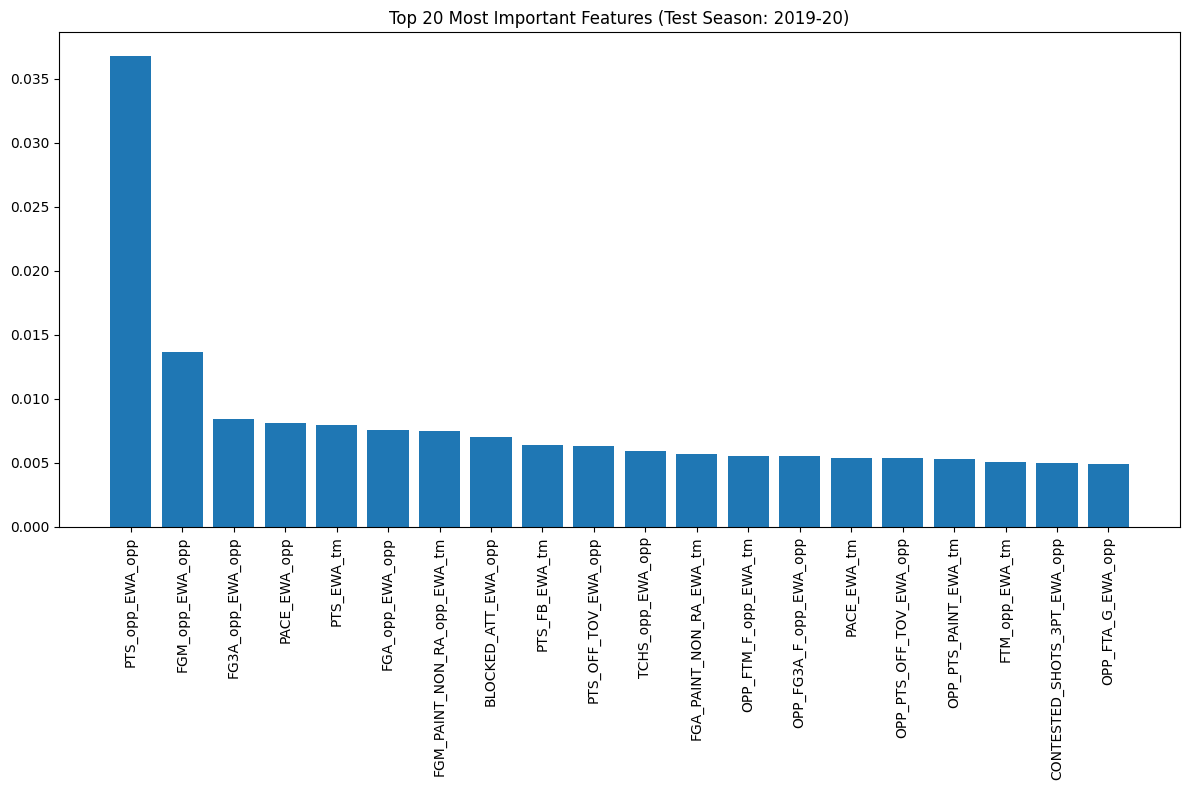


Training on seasons: 2016-17, 2017-18, 2018-19, 2019-20
Testing on season: 2020-21
Mean Absolute Error: 10.58
Root Mean Squared Error: 13.26
R-squared Score: -0.12


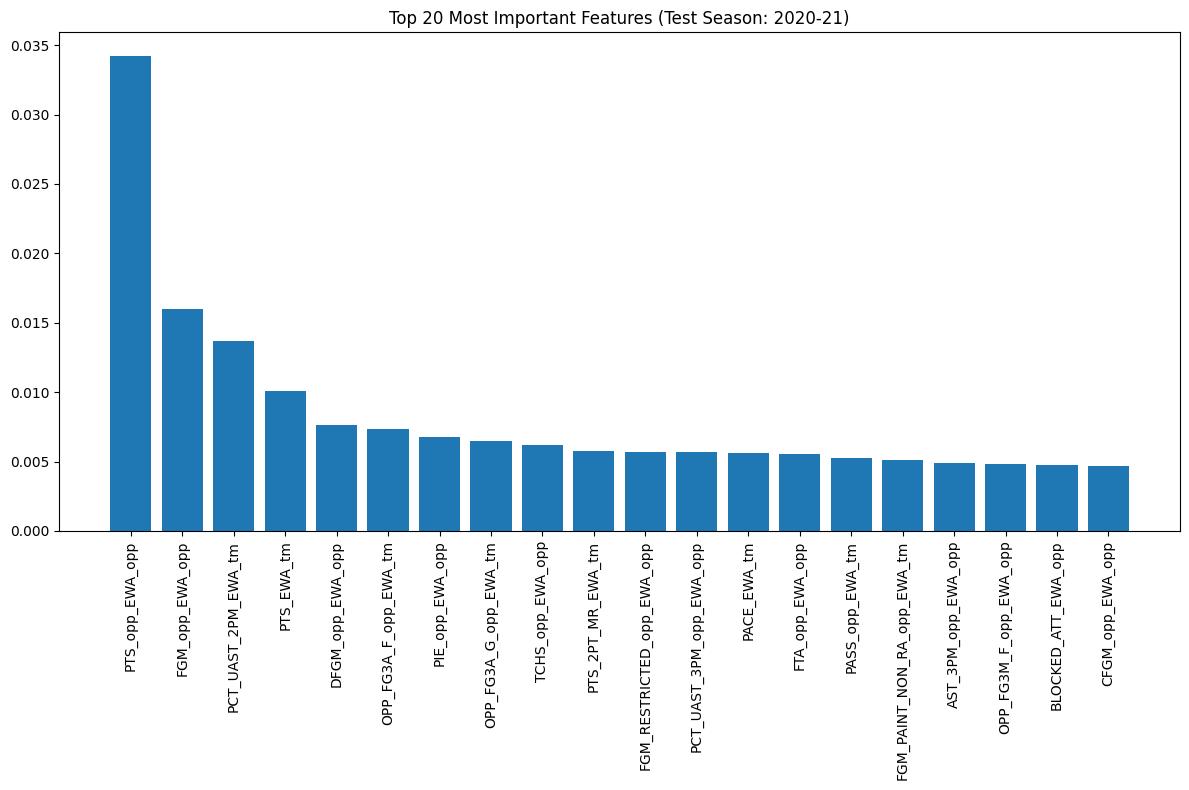


Training on seasons: 2016-17, 2017-18, 2018-19, 2019-20, 2020-21
Testing on season: 2021-22
Mean Absolute Error: 10.46
Root Mean Squared Error: 13.14
R-squared Score: -0.09


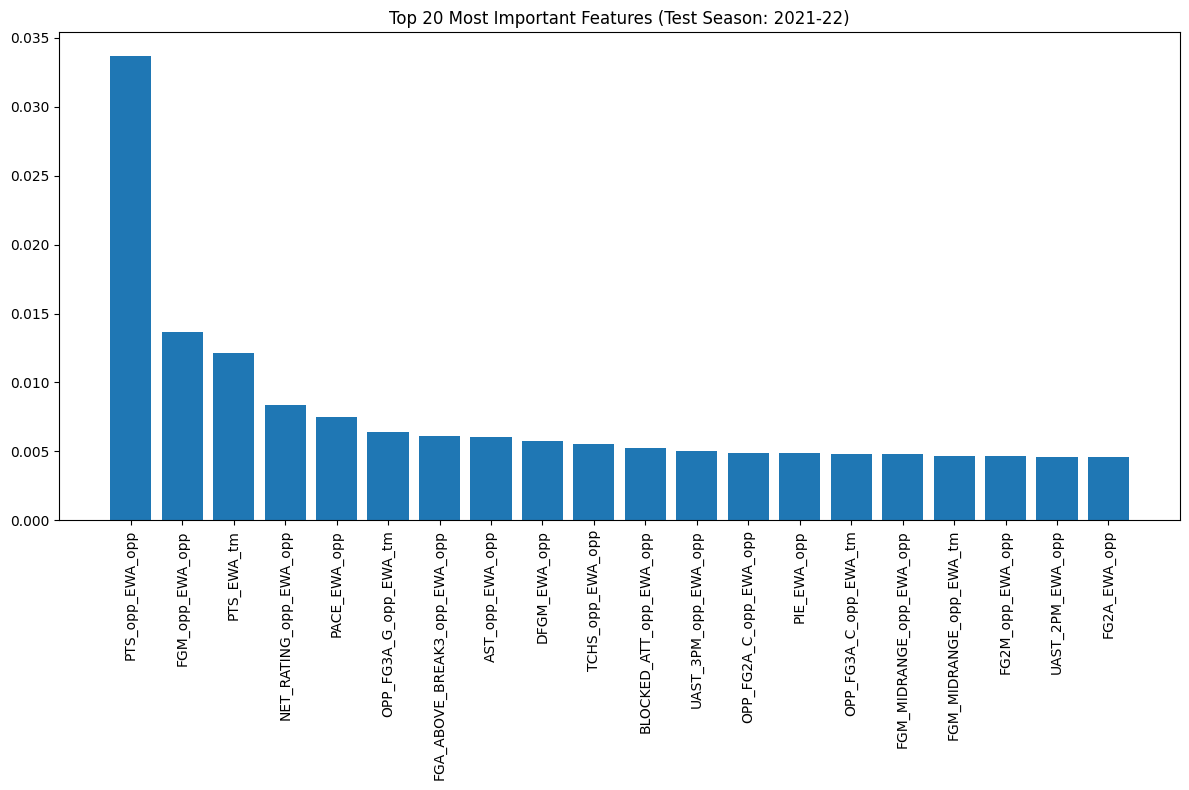


Training on seasons: 2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2021-22
Testing on season: 2022-23
Mean Absolute Error: 10.38
Root Mean Squared Error: 13.15
R-squared Score: -0.19


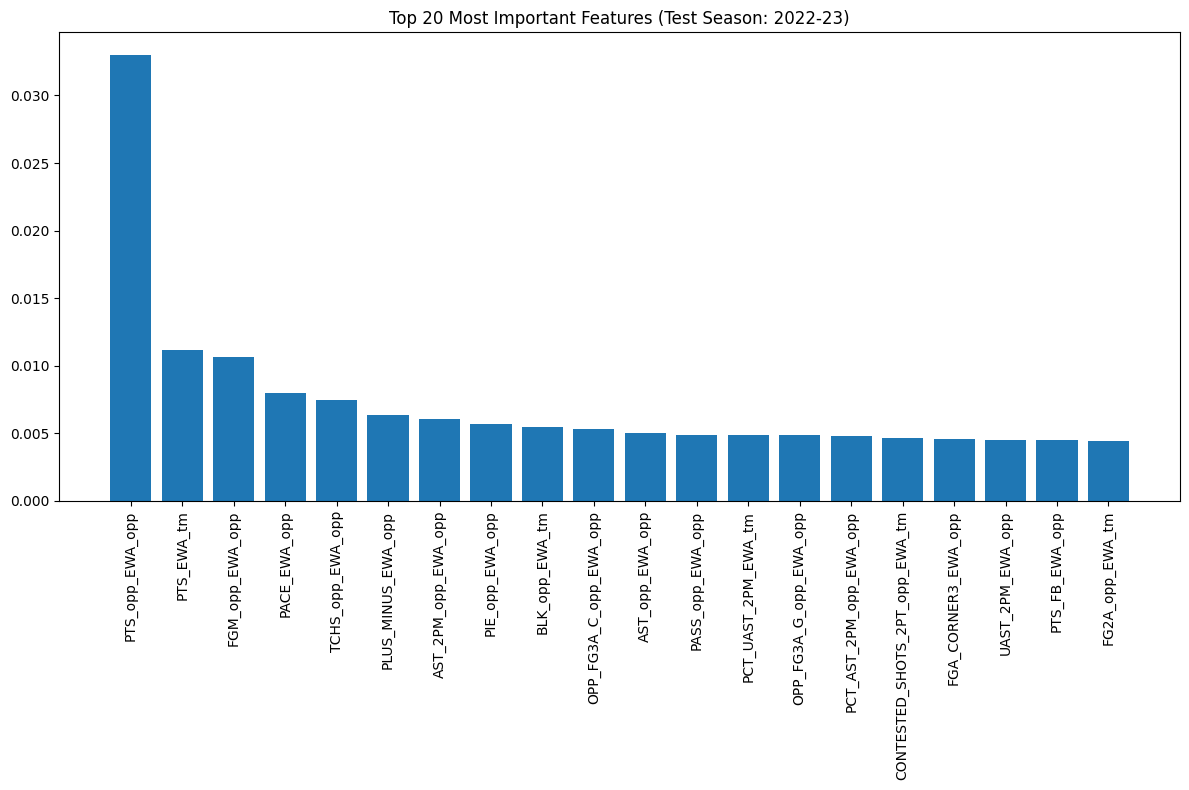


Training on seasons: 2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2021-22, 2022-23
Testing on season: 2023-24
Mean Absolute Error: 10.90
Root Mean Squared Error: 13.64
R-squared Score: -0.11


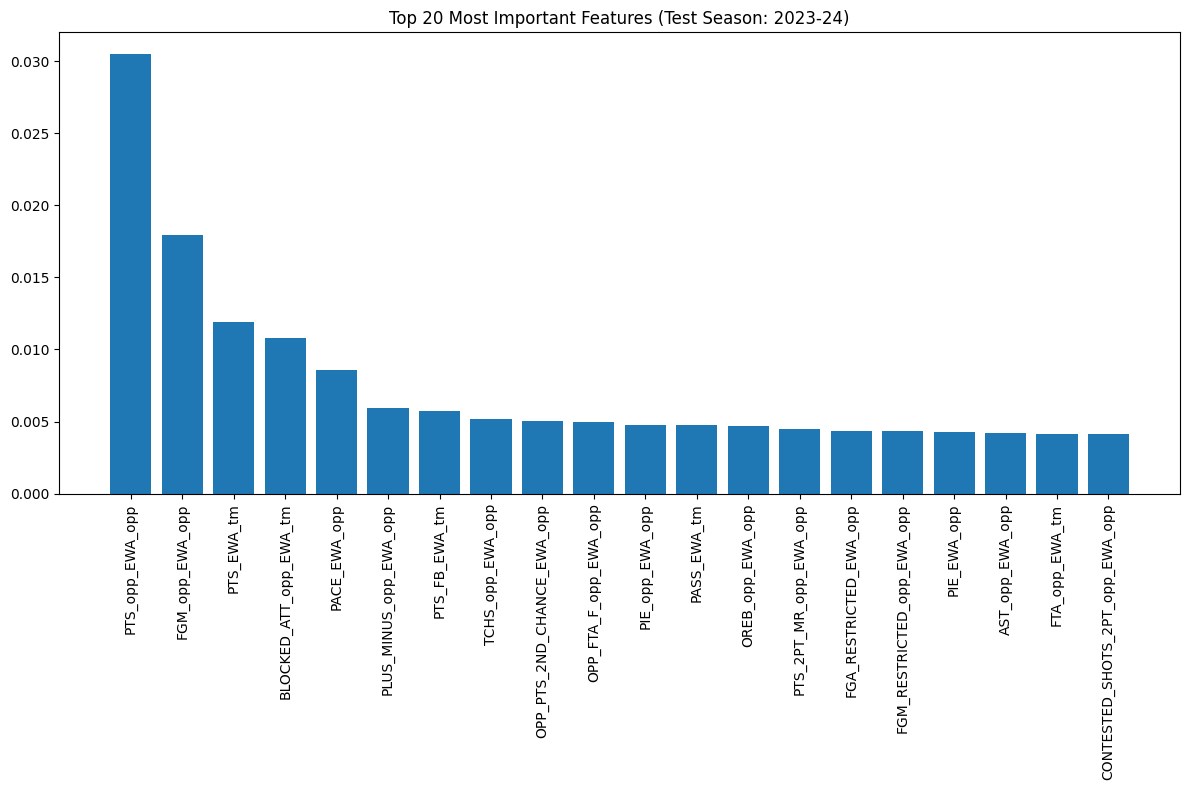


All Results:
                                       Train Seasons Test Season        MAE  \
0                          2016-17, 2017-18, 2018-19     2019-20  10.687573   
1                 2016-17, 2017-18, 2018-19, 2019-20     2020-21  10.581815   
2        2016-17, 2017-18, 2018-19, 2019-20, 2020-21     2021-22  10.463245   
3  2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2...     2022-23  10.375139   
4  2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2...     2023-24  10.899724   

        RMSE  R-squared  
0  13.414875  -0.161541  
1  13.257173  -0.116671  
2  13.142341  -0.086437  
3  13.152997  -0.189037  
4  13.635621  -0.108848  


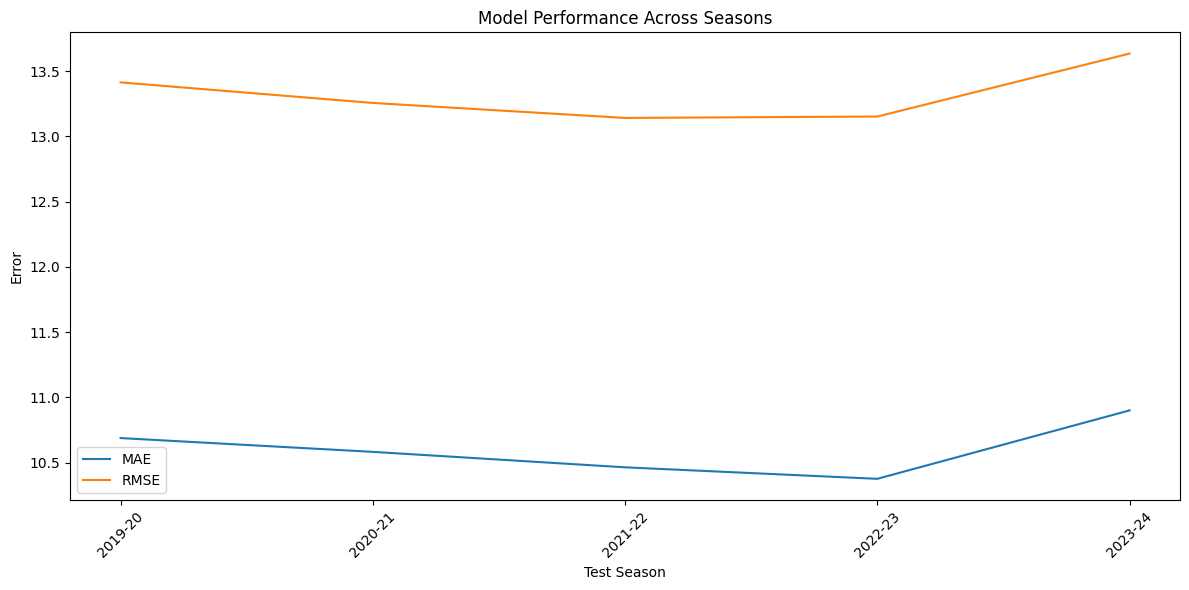

In [61]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

def custom_time_series_cv(X, y, train_seasons, test_season):
    train_mask = X['SEASON'].isin(train_seasons)
    test_mask = X['SEASON'] == test_season
    X_train = X[train_mask].drop('SEASON', axis=1)
    X_test = X[test_mask].drop('SEASON', axis=1)
    return X_train, X_test, y[train_mask], y[test_mask]

# Prepare the features
ewa_columns = [col for col in final_df.columns if '_EWA' in col]
engineered_features = ['AST_SCORING_DIFF', 'EFF_SCORING', 'POSS_EFFICIENCY', 'DEF_PRESSURE_SCORE',
                     'TRANSITION_DEF_EFF', 'SCORING_TREND', 'HOME_SCORING_IMPACT', 
                     'OREB_SCORING_IMPACT', 'BALL_MOVEMENT_EFF', 'ASSISTED_SCORING_EFF', 'PAINT_DEF_EFF']
X = final_df[['SEASON'] + ewa_columns + engineered_features]  # Include 'SEASON' column
y = final_df['PTS_tm']

# Define all seasons
all_seasons = sorted(X['SEASON'].unique())

# Initialize results storage
results = []

# Iterate through seasons, starting with training on the first 3 and testing on the 4th
for i in range(3, len(all_seasons)):
    train_seasons = all_seasons[:i]
    test_season = all_seasons[i]
    
    print(f"\nTraining on seasons: {', '.join(train_seasons)}")
    print(f"Testing on season: {test_season}")
    
    # Perform custom time series split
    X_train, X_test, y_train, y_test = custom_time_series_cv(X, y, train_seasons, test_season)
    
    # Create and train the XGBoost model
    model = xgb.XGBRegressor(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    
    # Make predictions and evaluate the model
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R-squared Score: {r2:.2f}")
    
    # Store results
    results.append({
        'Train Seasons': ', '.join(train_seasons),
        'Test Season': test_season,
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r2
    })
    
    # Analyze feature importance
    feature_importance = model.feature_importances_
    feature_importance_sorted = sorted(zip(feature_importance, ewa_columns), reverse=True)
    
    # Plot top 20 most important features
    plt.figure(figsize=(12, 8))
    plt.bar(range(20), [imp for imp, _ in feature_importance_sorted[:20]])
    plt.xticks(range(20), [name for _, name in feature_importance_sorted[:20]], rotation=90)
    plt.title(f"Top 20 Most Important Features (Test Season: {test_season})")
    plt.tight_layout()
    plt.show()
    
    # Print top 20 most important features
    # print("\nTop 20 Most Important Features:")
    # for imp, name in feature_importance_sorted[:20]:
    #     print(f"{name}: {imp:.4f}")

# Create a DataFrame with all results
results_df = pd.DataFrame(results)
print("\nAll Results:")
print(results_df)

# Plot the performance metrics across seasons
plt.figure(figsize=(12, 6))
plt.plot(results_df['Test Season'], results_df['MAE'], label='MAE')
plt.plot(results_df['Test Season'], results_df['RMSE'], label='RMSE')
plt.xlabel('Test Season')
plt.ylabel('Error')
plt.title('Model Performance Across Seasons')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [48]:
# Prepare the features
ewa_columns = [col for col in final_df.columns if '_EWA_tm' in col]
engineered_features = ['AST_SCORING_DIFF', 'EFF_SCORING', 'POSS_EFFICIENCY', 'DEF_PRESSURE_SCORE',
                     'TRANSITION_DEF_EFF', 'HOME_SCORING_IMPACT', 
                     'OREB_SCORING_IMPACT', 'BALL_MOVEMENT_EFF', 'ASSISTED_SCORING_EFF', 'PAINT_DEF_EFF']
X = final_df[['SEASON'] + ewa_columns + engineered_features]  # Include 'SEASON' column
y = final_df['PTS_tm']

print(X.columns.tolist())

['SEASON', 'PTS_EWA_tm', 'FGM_EWA_tm', 'FGA_EWA_tm', 'FG3M_EWA_tm', 'FG3A_EWA_tm', 'FTM_EWA_tm', 'FTA_EWA_tm', 'OREB_EWA_tm', 'DREB_EWA_tm', 'REB_EWA_tm', 'AST_EWA_tm', 'TOV_EWA_tm', 'STL_EWA_tm', 'BLK_EWA_tm', 'PLUS_MINUS_EWA_tm', 'OFF_RATING_EWA_tm', 'DEF_RATING_EWA_tm', 'NET_RATING_EWA_tm', 'PACE_EWA_tm', 'PIE_EWA_tm', 'PCT_PTS_2PT_MR_EWA_tm', 'PCT_AST_2PM_EWA_tm', 'PCT_UAST_2PM_EWA_tm', 'PCT_AST_3PM_EWA_tm', 'PCT_UAST_3PM_EWA_tm', 'DEFENSIVE_BOX_OUTS_EWA_tm', 'CONTESTED_SHOTS_2PT_EWA_tm', 'CONTESTED_SHOTS_3PT_EWA_tm', 'deflections_EWA_tm', 'DIST_EWA_tm', 'TCHS_EWA_tm', 'PASS_EWA_tm', 'CFGM_EWA_tm', 'CFGA_EWA_tm', 'UFGM_EWA_tm', 'UFGA_EWA_tm', 'DFGM_EWA_tm', 'DFGA_EWA_tm', 'OPP_FG3M_C_EWA_tm', 'OPP_FG3A_C_EWA_tm', 'OPP_FG3M_F_EWA_tm', 'OPP_FG3A_F_EWA_tm', 'OPP_FG3M_G_EWA_tm', 'OPP_FG3A_G_EWA_tm', 'OPP_FTM_C_EWA_tm', 'OPP_FTM_F_EWA_tm', 'OPP_FTM_G_EWA_tm', 'OPP_FTA_C_EWA_tm', 'OPP_FTA_F_EWA_tm', 'OPP_FTA_G_EWA_tm', 'PTS_OFF_TOV_EWA_tm', 'PTS_2ND_CHANCE_EWA_tm', 'PTS_FB_EWA_tm', 'PTS_

In [72]:
ewa_columns = [col for col in final_df.columns if '_EWA' in col]
engineered_features = ['AST_SCORING_DIFF', 'EFF_SCORING', 'POSS_EFFICIENCY', 'DEF_PRESSURE_SCORE',
                     'TRANSITION_DEF_EFF', 'HOME_SCORING_IMPACT', 
                     'OREB_SCORING_IMPACT', 'BALL_MOVEMENT_EFF', 'ASSISTED_SCORING_EFF', 'PAINT_DEF_EFF']
X = final_df[ewa_columns]  # Include 'SEASON' column
y = final_df['PTS_tm']

print(X.columns.tolist())

['PTS_EWA_tm', 'FGM_EWA_tm', 'FGA_EWA_tm', 'FG3M_EWA_tm', 'FG3A_EWA_tm', 'FTM_EWA_tm', 'FTA_EWA_tm', 'OREB_EWA_tm', 'DREB_EWA_tm', 'REB_EWA_tm', 'AST_EWA_tm', 'TOV_EWA_tm', 'STL_EWA_tm', 'BLK_EWA_tm', 'PLUS_MINUS_EWA_tm', 'OFF_RATING_EWA_tm', 'DEF_RATING_EWA_tm', 'NET_RATING_EWA_tm', 'PACE_EWA_tm', 'PIE_EWA_tm', 'PCT_PTS_2PT_MR_EWA_tm', 'PCT_AST_2PM_EWA_tm', 'PCT_UAST_2PM_EWA_tm', 'PCT_AST_3PM_EWA_tm', 'PCT_UAST_3PM_EWA_tm', 'DEFENSIVE_BOX_OUTS_EWA_tm', 'CONTESTED_SHOTS_2PT_EWA_tm', 'CONTESTED_SHOTS_3PT_EWA_tm', 'deflections_EWA_tm', 'DIST_EWA_tm', 'TCHS_EWA_tm', 'PASS_EWA_tm', 'CFGM_EWA_tm', 'CFGA_EWA_tm', 'UFGM_EWA_tm', 'UFGA_EWA_tm', 'DFGM_EWA_tm', 'DFGA_EWA_tm', 'OPP_FG3M_C_EWA_tm', 'OPP_FG3A_C_EWA_tm', 'OPP_FG3M_F_EWA_tm', 'OPP_FG3A_F_EWA_tm', 'OPP_FG3M_G_EWA_tm', 'OPP_FG3A_G_EWA_tm', 'OPP_FTM_C_EWA_tm', 'OPP_FTM_F_EWA_tm', 'OPP_FTM_G_EWA_tm', 'OPP_FTA_C_EWA_tm', 'OPP_FTA_F_EWA_tm', 'OPP_FTA_G_EWA_tm', 'PTS_OFF_TOV_EWA_tm', 'PTS_2ND_CHANCE_EWA_tm', 'PTS_FB_EWA_tm', 'PTS_PAINT_EWA_

No path specified. Models will be saved in: "AutogluonModels\ag-20241106_034714"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19041
CPU Count:          4
Memory Avail:       1.07 GB / 15.94 GB (6.7%)
Disk Space Avail:   41.10 GB / 446.13 GB (9.2%)
Presets specified: ['high_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabled (dynamic_stacking=True). AutoGluon will


Training on seasons: 2016-17, 2017-18, 2018-19, 2019-20, 2020-21
Testing on season: 2021-22


	Running DyStack sub-fit in a ray process to avoid memory leakage. Enabling ray logging (enable_ray_logging=True). Specify `ds_args={'enable_ray_logging': False}` if you experience logging issues.
2024-11-05 19:47:30,237	INFO worker.py:1743 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
		Context path: "AutogluonModels\ag-20241106_034714\ds_sub_fit\sub_fit_ho"
(_dystack pid=16132) Running DyStack sub-fit ...
(_dystack pid=16132) Beginning AutoGluon training ... Time limit = 875s
(_dystack pid=16132) AutoGluon will save models to "AutogluonModels\ag-20241106_034714\ds_sub_fit\sub_fit_ho"
(_dystack pid=16132) Train Data Rows:    11077
(_dystack pid=16132) Train Data Columns: 363
(_dystack pid=16132) Label Column:       PTS_tm
(_dystack pid=16132) Problem Type:       regression
(_dystack pid=16132) Preprocessing data ...
(_dystack pid=16132) Using Feature Generators to preprocess the data ...
(_dystack pid=16132) Fitting AutoMLPipelineFeatureGenerator...
(_d

Mean Absolute Error: 9.44
Root Mean Squared Error: 3.45
R-squared Score: 0.11


	5748.94s	= Expected runtime (1149.79s per shuffle set)
	3422.75s	= Actual runtime (Completed 5 of 5 shuffle sets)



Top 10 Most Important Features:

Training on seasons: 2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2021-22
Testing on season: 2022-23


No path specified. Models will be saved in: "AutogluonModels\ag-20241106_054550"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19041
CPU Count:          4
Memory Avail:       3.71 GB / 15.94 GB (23.3%)
Disk Space Avail:   38.09 GB / 446.13 GB (8.5%)
Presets specified: ['high_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabled (dynamic_stacking=True). AutoGluon wil

Mean Absolute Error: 9.17
Root Mean Squared Error: 3.41
R-squared Score: 0.07


	6228.45s	= Expected runtime (1245.69s per shuffle set)
	3701.32s	= Actual runtime (Completed 5 of 5 shuffle sets)



Top 10 Most Important Features:

Training on seasons: 2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2021-22, 2022-23
Testing on season: 2023-24


No path specified. Models will be saved in: "AutogluonModels\ag-20241106_075118"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19041
CPU Count:          4
Memory Avail:       4.63 GB / 15.94 GB (29.1%)
Disk Space Avail:   34.31 GB / 446.13 GB (7.7%)
Presets specified: ['high_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabled (dynamic_stacking=True). AutoGluon wil

Mean Absolute Error: 9.43
Root Mean Squared Error: 3.43
R-squared Score: 0.18


	3565.77s	= Expected runtime (713.15s per shuffle set)
	2499.36s	= Actual runtime (Completed 5 of 5 shuffle sets)



Top 10 Most Important Features:


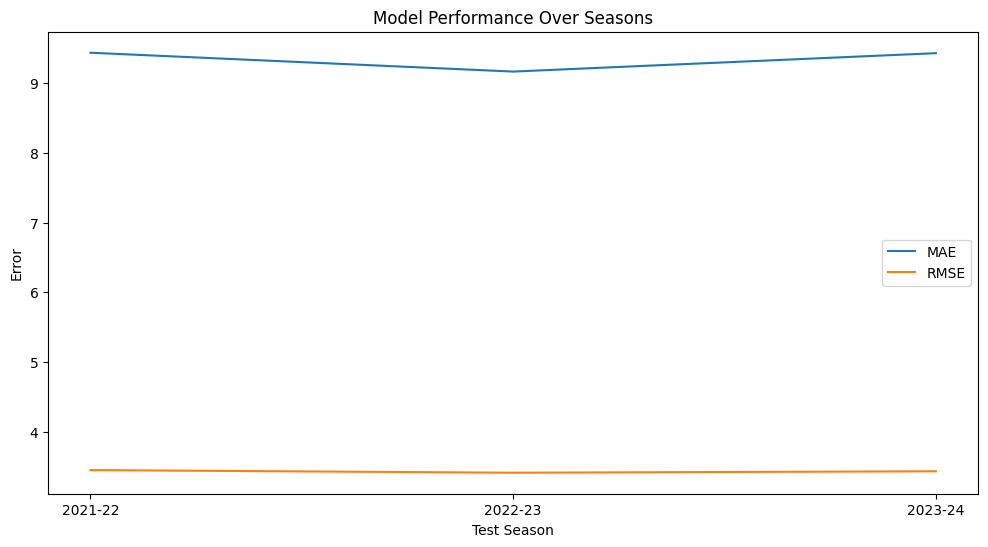


Overall Results:
                                                   Train Seasons Test Season  \
0                    2016-17, 2017-18, 2018-19, 2019-20, 2020-21     2021-22   
1           2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2021-22     2022-23   
2  2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2021-22, 2022-23     2023-24   

        MAE      RMSE  R-squared  
0  9.439865  3.446558   0.112432  
1  9.169162  3.408624   0.072182  
2  9.433385  3.429360   0.175151  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt

def custom_time_series_cv(X, y, train_seasons, test_season):
    train_mask = X['SEASON'].isin(train_seasons)
    test_mask = X['SEASON'] == test_season
    X_train = X[train_mask]
    X_test = X[test_mask]
    return X_train, X_test, y[train_mask], y[test_mask]

# Prepare the features
ewa_columns = [col for col in final_df.columns if '_EWA' in col]
engineered_features = ['AST_SCORING_DIFF', 'EFF_SCORING', 'POSS_EFFICIENCY', 'DEF_PRESSURE_SCORE',
                     'TRANSITION_DEF_EFF', 'SCORING_TREND', 'HOME_SCORING_IMPACT', 
                     'OREB_SCORING_IMPACT', 'BALL_MOVEMENT_EFF', 'ASSISTED_SCORING_EFF', 'PAINT_DEF_EFF']
X = final_df[['SEASON'] + ewa_columns + engineered_features]  # Include 'SEASON' column
y = final_df['PTS_tm']

# Define all seasons
all_seasons = sorted(X['SEASON'].unique())

# Initialize results storage
results = []

# Iterate through seasons, starting with training on the first 3 and testing on the 4th
for i in range(5, len(all_seasons)):
    train_seasons = all_seasons[:i]
    test_season = all_seasons[i]
    
    print(f"\nTraining on seasons: {', '.join(train_seasons)}")
    print(f"Testing on season: {test_season}")
    
    # Perform custom time series split
    X_train, X_test, y_train, y_test = custom_time_series_cv(X, y, train_seasons, test_season)
    
    # Create and train the AutoGluon model
    predictor = TabularPredictor(label='PTS_tm', problem_type='regression')
    predictor.fit(pd.concat([X_train, y_train], axis=1), presets='medium_quality', excluded_model_types =['KNN'], time_limit=600)  # 60 minutes time limit
    
    # Make predictions and evaluate the model
    y_pred = predictor.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R-squared Score: {r2:.2f}")
    
    # Store results
    results.append({
        'Train Seasons': ', '.join(train_seasons),
        'Test Season': test_season,
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r2
    })
    
    # Analyze feature importance
    feature_importance = predictor.feature_importance(pd.concat([X_train, y_train], axis=1))
    print("\nTop 10 Most Important Features:")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot([r['Test Season'] for r in results], [r['MAE'] for r in results], label='MAE')
plt.plot([r['Test Season'] for r in results], [r['RMSE'] for r in results], label='RMSE')
plt.xlabel('Test Season')
plt.ylabel('Error')
plt.title('Model Performance Over Seasons')
plt.legend()
plt.show()

# Print overall results
results_df = pd.DataFrame(results)
print("\nOverall Results:")
print(results_df)

In [ ]:

Overall Results:
                                                   Train Seasons Test Season  \
0                                      2016-17, 2017-18, 2018-19     2019-20   
1                             2016-17, 2017-18, 2018-19, 2019-20     2020-21   
2                    2016-17, 2017-18, 2018-19, 2019-20, 2020-21     2021-22   
3           2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2021-22     2022-23   
4  2016-17, 2017-18, 2018-19, 2019-20, 2020-21, 2021-22, 2022-23     2023-24   

        MAE      RMSE  R-squared  
0  9.398114  3.447583   0.088157  
1  9.543074  3.460884   0.088469  
2  9.502075  3.458009   0.100578  
3  9.215284  3.412684   0.067754  
4  9.475112  3.437448   0.167341  


In [62]:
final_df = final_df.drop(columns=['FG_PCT_RESTRICTED_EWA_tm'])

In [64]:

ewa_columns = [col for col in final_df.columns if '_EWA' in col]

X_train = final_df.loc[final_df['SEASON'] < '2023-24', ewa_columns]
y_train = final_df.loc[final_df['SEASON'] < '2023-24', 'PTS_tm']

X_test = final_df.loc[final_df['SEASON'] == '2023-24', ewa_columns]
y_test = final_df.loc[final_df['SEASON'] == '2023-24', 'PTS_tm']

X_train.columns.tolist()

['PTS_EWA_tm',
 'FGM_EWA_tm',
 'FGA_EWA_tm',
 'FG3M_EWA_tm',
 'FG3A_EWA_tm',
 'FTM_EWA_tm',
 'FTA_EWA_tm',
 'OREB_EWA_tm',
 'DREB_EWA_tm',
 'REB_EWA_tm',
 'AST_EWA_tm',
 'TOV_EWA_tm',
 'STL_EWA_tm',
 'BLK_EWA_tm',
 'PLUS_MINUS_EWA_tm',
 'OFF_RATING_EWA_tm',
 'DEF_RATING_EWA_tm',
 'NET_RATING_EWA_tm',
 'PACE_EWA_tm',
 'PIE_EWA_tm',
 'PCT_PTS_2PT_MR_EWA_tm',
 'PCT_AST_2PM_EWA_tm',
 'PCT_UAST_2PM_EWA_tm',
 'PCT_AST_3PM_EWA_tm',
 'PCT_UAST_3PM_EWA_tm',
 'DEFENSIVE_BOX_OUTS_EWA_tm',
 'CONTESTED_SHOTS_2PT_EWA_tm',
 'CONTESTED_SHOTS_3PT_EWA_tm',
 'deflections_EWA_tm',
 'DIST_EWA_tm',
 'TCHS_EWA_tm',
 'PASS_EWA_tm',
 'CFGM_EWA_tm',
 'CFGA_EWA_tm',
 'UFGM_EWA_tm',
 'UFGA_EWA_tm',
 'DFGM_EWA_tm',
 'DFGA_EWA_tm',
 'OPP_FG3M_C_EWA_tm',
 'OPP_FG3A_C_EWA_tm',
 'OPP_FG3M_F_EWA_tm',
 'OPP_FG3A_F_EWA_tm',
 'OPP_FG3M_G_EWA_tm',
 'OPP_FG3A_G_EWA_tm',
 'OPP_FTM_C_EWA_tm',
 'OPP_FTM_F_EWA_tm',
 'OPP_FTM_G_EWA_tm',
 'OPP_FTA_C_EWA_tm',
 'OPP_FTA_F_EWA_tm',
 'OPP_FTA_G_EWA_tm',
 'PTS_OFF_TOV_EWA_tm',
 'PTS_2

In [71]:
Path.cwd().parent / "models" / "AutogluonModels"

Path('c:/Users/Jordan Nishimura/nba_model_using_player_embeddings/models/AutogluonModels')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt

def custom_time_series_cv(X, y, train_seasons, test_season):
    train_mask = X['SEASON'].isin(train_seasons)
    test_mask = X['SEASON'] == test_season
    X_train = X[train_mask]
    X_test = X[test_mask]
    return X_train, X_test, y[train_mask], y[test_mask]

# Prepare the features
ewa_columns = [col for col in final_df.columns if '_EWA' in col]

X_train = final_df.loc[final_df['SEASON'] < '2023-24', ewa_columns]
y_train = final_df.loc[final_df['SEASON'] < '2023-24', 'PTS_tm']

X_test = final_df.loc[final_df['SEASON'] == '2023-24', ewa_columns]
y_test = final_df.loc[final_df['SEASON'] == '2023-24', 'PTS_tm']

X = final_df[ewa_columns]
y = final_df['PTS_tm']

model_path = Path.cwd()
predictor = TabularPredictor(label='PTS_tm', problem_type='regression')
predictor.fit(pd.concat([X_train, y_train], axis=1), presets='high_quality', excluded_model_types =['KNN'], time_limit = 3600)  # 60 minutes time limit
    

No path specified. Models will be saved in: "AutogluonModels\ag-20241116_093710"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19041
CPU Count:          4
Memory Avail:       4.84 GB / 15.94 GB (30.4%)
Disk Space Avail:   22.67 GB / 446.13 GB (5.1%)
Presets specified: ['high_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabled (dynamic_stacking=True). AutoGluon wil

In [69]:

# Make predictions and evaluate the model
y_pred = predictor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared Score: {r2:.2f}")

results = []

# Store results
results.append({
    'Test Season': '2023-24',
    'MAE': mae,
    'RMSE': rmse,
    'R-squared': r2
})

# Analyze feature importance
feature_importance = predictor.feature_importance(pd.concat([X_train, y_train], axis=1))
print("\nTop 10 Most Important Features:")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot([r['Test Season'] for r in results], [r['MAE'] for r in results], label='MAE')
plt.plot([r['Test Season'] for r in results], [r['RMSE'] for r in results], label='RMSE')
plt.xlabel('Test Season')
plt.ylabel('Error')
plt.title('Model Performance Over Seasons')
plt.legend()
plt.show()

# Print overall results
results_df = pd.DataFrame(results)
print("\nOverall Results:")
print(results_df)

These features in provided data are not utilized by the predictor and will be ignored: ['OFF_RATING_opp_EWA_tm', 'DEF_RATING_opp_EWA_tm', 'PACE_opp_EWA_tm', 'PTS_OFF_TOV_opp_EWA_tm', 'PTS_2ND_CHANCE_opp_EWA_tm', 'PTS_FB_opp_EWA_tm', 'PTS_PAINT_opp_EWA_tm', 'OPP_PTS_OFF_TOV_opp_EWA_tm', 'OPP_PTS_2ND_CHANCE_opp_EWA_tm', 'OPP_PTS_FB_opp_EWA_tm', 'OPP_PTS_PAINT_opp_EWA_tm', 'OFF_RATING_opp_EWA_opp', 'DEF_RATING_opp_EWA_opp', 'PACE_opp_EWA_opp', 'PTS_OFF_TOV_opp_EWA_opp', 'PTS_2ND_CHANCE_opp_EWA_opp', 'PTS_FB_opp_EWA_opp', 'PTS_PAINT_opp_EWA_opp', 'OPP_PTS_OFF_TOV_opp_EWA_opp', 'OPP_PTS_2ND_CHANCE_opp_EWA_opp', 'OPP_PTS_FB_opp_EWA_opp', 'OPP_PTS_PAINT_opp_EWA_opp']
Computing feature importance via permutation shuffling for 318 features using 5000 rows with 5 shuffle sets...


Mean Absolute Error: 9.43
Root Mean Squared Error: 3.43
R-squared Score: 0.18


	2621.57s	= Expected runtime (524.31s per shuffle set)


FileNotFoundError: [Errno 2] No such file or directory: 'AutogluonModels\\ag-20241116_093710\\models\\LightGBMXT_BAG_L1_FULL\\model.pkl'

In [68]:
feature_importance

,importance,stddev,p_value,n,p99_high,p99_low
PTS_EWA_tm,0.328309,0.011582,1.855538e-07,5,0.352156,0.304461
PTS_opp_EWA_opp,0.168419,0.006699,2.996503e-07,5,0.182212,0.154627
PACE_EWA_opp,0.064601,0.011085,1.000853e-04,5,0.087427,0.041776
FGM_opp_EWA_opp,0.039425,0.002173,1.102331e-06,5,0.043899,0.034952
PACE_EWA_tm,0.038379,0.005563,5.153536e-05,5,0.049835,0.026924
...,...,...,...,...,...,...
FG2A_EWA_opp,0.005379,0.000543,1.232916e-05,5,0.006498,0.004260
PTS_2PT_MR_opp_EWA_tm,0.005172,0.000899,1.050708e-04,5,0.007023,0.003322
OPP_FG3M_G_opp_EWA_tm,0.005127,0.000720,4.542687e-05,5,0.006609,0.003645
OPP_FG3M_F_opp_EWA_opp,0.004431,0.000503,1.955274e-05,5,0.005466,0.003396


In [60]:
print(X_train.columns.tolist())

['PTS_EWA_tm', 'FGM_EWA_tm', 'FGA_EWA_tm', 'FG3M_EWA_tm', 'FG3A_EWA_tm', 'FTM_EWA_tm', 'FTA_EWA_tm', 'OREB_EWA_tm', 'DREB_EWA_tm', 'REB_EWA_tm', 'AST_EWA_tm', 'TOV_EWA_tm', 'STL_EWA_tm', 'BLK_EWA_tm', 'PLUS_MINUS_EWA_tm', 'OFF_RATING_EWA_tm', 'DEF_RATING_EWA_tm', 'NET_RATING_EWA_tm', 'PACE_EWA_tm', 'PIE_EWA_tm', 'PCT_PTS_2PT_MR_EWA_tm', 'PCT_AST_2PM_EWA_tm', 'PCT_UAST_2PM_EWA_tm', 'PCT_AST_3PM_EWA_tm', 'PCT_UAST_3PM_EWA_tm', 'DEFENSIVE_BOX_OUTS_EWA_tm', 'CONTESTED_SHOTS_2PT_EWA_tm', 'CONTESTED_SHOTS_3PT_EWA_tm', 'deflections_EWA_tm', 'DIST_EWA_tm', 'TCHS_EWA_tm', 'PASS_EWA_tm', 'CFGM_EWA_tm', 'CFGA_EWA_tm', 'UFGM_EWA_tm', 'UFGA_EWA_tm', 'DFGM_EWA_tm', 'DFGA_EWA_tm', 'OPP_FG3M_C_EWA_tm', 'OPP_FG3A_C_EWA_tm', 'OPP_FG3M_F_EWA_tm', 'OPP_FG3A_F_EWA_tm', 'OPP_FG3M_G_EWA_tm', 'OPP_FG3A_G_EWA_tm', 'OPP_FTM_C_EWA_tm', 'OPP_FTM_F_EWA_tm', 'OPP_FTM_G_EWA_tm', 'OPP_FTA_C_EWA_tm', 'OPP_FTA_F_EWA_tm', 'OPP_FTA_G_EWA_tm', 'PTS_OFF_TOV_EWA_tm', 'PTS_2ND_CHANCE_EWA_tm', 'PTS_FB_EWA_tm', 'PTS_PAINT_EWA_

In [122]:
final_df['SIMPLIFIED_POSITION']

1         G
2         G
3         G
4         G
5         G
         ..
216722    C
216723    C
216724    C
216725    C
216726    C
Name: SIMPLIFIED_POSITION, Length: 215437, dtype: object

## Add Betting Data

In [42]:
def load_betting_data(conn):
    betting_data = pd.read_sql("SELECT * FROM nba_odds", conn)
    betting_data = betting_data[['season', 'date', 'status', 'home_team_abbr', 'away_team_abbr', 'home_spread_draftkings',
                                'home_spread_odds_draftkings',
                                'away_spread_draftkings',
                                'away_spread_odds_draftkings',
                                'home_ml_draftkings',
                                'away_ml_draftkings',
                                'total_draftkings',
                                'over_odds_draftkings',
                                'under_odds_draftkings']]
    return betting_data


connection = sqlite3.connect("nba_stats.db")
betting_data = load_betting_data(connection)
betting_data

connection.close()

In [43]:
betting_data

,season,date,status,home_team_abbr,away_team_abbr,home_spread_draftkings,home_spread_odds_draftkings,away_spread_draftkings,away_spread_odds_draftkings,home_ml_draftkings,away_ml_draftkings,total_draftkings,over_odds_draftkings,under_odds_draftkings
0,2019-20,2020-10-11T23:30:00+00:00,Final,MIA,LAL,6.0,-110.0,-6.0,-110.0,215.0,-265.0,214.5,-108.0,-113.0
1,2019-20,2020-10-11T23:30:00+00:00,Final,MIA,LAL,6.0,-110.0,-6.0,-110.0,215.0,-265.0,214.5,-108.0,-113.0
2,2019-20,2020-10-10T01:00:00+00:00,Final,LAL,MIA,-7.0,-112.0,7.0,-108.0,-335.0,270.0,215.5,-112.0,-109.0
3,2019-20,2020-10-07T01:00:00+00:00,Final,MIA,LAL,7.5,-110.0,-7.5,-110.0,275.0,-335.0,218.5,-113.0,-108.0
4,2019-20,2020-10-04T23:30:00+00:00,Final,MIA,LAL,9.5,-110.0,-9.5,-110.0,350.0,-455.0,219.5,-113.0,-108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6456,2023-24,2024-06-07T00:30:00+00:00,Final,BOS,DAL,-6.5,-110.0,6.5,-110.0,-230.0,190.0,217.5,-110.0,-110.0
6457,2023-24,2024-06-10T00:00:00+00:00,Final,BOS,DAL,-7.0,-105.0,7.0,-115.0,-270.0,220.0,215.0,-110.0,-110.0
6458,2023-24,2024-06-13T00:30:00+00:00,Final,DAL,BOS,-3.0,-108.0,3.0,-112.0,-148.0,124.0,213.5,-110.0,-110.0
6459,2023-24,2024-06-15T00:30:00+00:00,Final,DAL,BOS,1.0,-108.0,-1.0,-112.0,-102.0,-118.0,211.0,-110.0,-110.0


In [46]:
def convert_american_to_decimal(x):
    return np.where(x>0, (100+x)/100, 1+(100.0/-x))          

In [203]:
normalized_df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,E_PACE,contestedShots,contestedShots2pt,contestedShots3pt,deflections,chargesDrawn,screenAssists,screenAssistPoints,looseBallsRecoveredOffensive,looseBallsRecoveredDefensive,looseBallsRecoveredTotal,offensiveBoxOuts,defensiveBoxOuts,boxOutPlayerTeamRebounds,boxOutPlayerRebounds,boxOuts,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,HOME_GAME,FG2M,FG2A,PTS_2PT_MR,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,POINT_DIFF,RECORD,TEAM_SCORE
2632,22016,1610612739,CLE,Cleveland Cavaliers,0021600001,2016-10-25,CLE vs. NYK,1,43.444680,90.751110,12.550685,33.790307,13.516123,18.343310,10.619811,38.617494,49.237304,29.928558,11.585248,4.827187,14.481560,21.239622,112.956169,27.997683,2016-17,110.0,87.3,22.7,103.58,62.753427,44.410118,18.343310,15.446997,0.000000,5.792624,11.585248,0.000000,0.000000,11.585248,0.000000,0.000000,0.000000,0.000000,0.000000,16.528287,39.582931,69.511489,104.267233,425.757868,1.930875,0.000000,303.147326,16.412435,37.652056,27.032246,53.099054,9.654373,17.377872,20.274184,15.446997,15.446997,50.202742,1,30.893995,56.960803,11.585248,19.308747,9.654373,11.585248,1.930875,29,1,117
2633,22016,1610612752,NYK,New York Knicks,0021600001,2016-10-25,NYK @ CLE,0,30.893995,83.993049,8.688936,26.066808,14.481560,19.308747,12.550685,27.997683,40.548368,16.412435,5.792624,5.792624,17.377872,21.239622,84.958486,-27.997683,2016-17,87.3,110.0,-22.7,103.58,62.753427,37.652056,25.101371,8.688936,1.930875,6.758061,14.481560,0.000000,0.000000,9.654373,0.000000,0.000000,0.000000,0.000000,0.000000,16.692412,32.824870,68.546051,100.405484,393.898436,0.965437,0.965437,277.080517,11.585248,29.928558,19.308747,54.064491,20.274184,29.928558,13.516123,15.446997,8.688936,27.032246,0,22.205059,57.926241,17.377872,7.723499,7.723499,13.516123,0.000000,-29,0,88
2634,22016,1610612757,POR,Portland Trail Blazers,0021600002,2016-10-25,POR vs. UTA,1,41.113219,79.063884,13.704406,20.029517,23.192073,23.192073,5.270926,30.571368,35.842294,23.192073,5.270926,3.162555,13.704406,18.975332,119.122918,9.487666,2016-17,121.9,107.2,14.8,94.86,65.359477,46.384145,18.975332,9.487666,0.000000,18.975332,45.329960,0.000000,0.000000,4.216740,0.000000,0.000000,0.000000,0.000000,0.000000,17.552182,20.029517,56.925996,76.955513,381.615012,0.000000,0.000000,268.817204,20.029517,45.329960,21.083702,33.733924,14.758592,21.083702,21.083702,15.812777,4.216740,35.842294,1,27.408813,59.034366,17.921147,13.704406,8.433481,13.704406,4.216740,9,1,113
2635,22016,1610612762,UTA,Utah Jazz,0021600002,2016-10-25,UTA @ POR,0,42.167405,86.443179,8.433481,25.300443,16.866962,16.866962,6.325111,26.354628,32.679739,20.029517,9.487666,5.270926,14.758592,20.029517,109.635252,-9.487666,2016-17,107.2,121.9,-14.8,94.86,56.925996,46.384145,10.541851,16.866962,0.000000,10.541851,21.083702,0.000000,0.000000,7.379296,0.000000,0.000000,0.000000,0.000000,0.000000,17.668143,20.029517,49.546700,69.576218,448.028674,2.108370,1.054185,326.797386,23.192073,46.384145,18.975332,40.059034,11.596036,18.975332,8.433481,4.216740,8.433481,52.709256,0,33.733924,61.142737,14.758592,11.596036,8.433481,21.083702,0.000000,-9,0,104
2636,22016,1610612744,GSW,Golden State Warriors,0021600003,2016-10-25,GSW vs. SAS,0,39.339103,83.595594,6.884343,32.454760,12.785208,17.702596,7.867821,26.553895,34.421715,23.603462,10.818253,5.900865,15.735641,18.686074,98.347758,-28.520850,2016-17,99.1,125.9,-26.8,101.68,81.628639,60.975610,20.653029,22.619984,0.000000,4.917388,10.818253,0.000000,0.000000,7.867821,0.000000,0.000000,0.000000,0.000000,0.000000,16.620771,22.619984,44.256491,65.892998,390.440598,3.933910,0.983478,272.423289,20.653029,37.372148,18.686074,46.223446,19.669552,31.471282,14.752164,3.933910,19.669552,47.206924,1,32.454760,51.140834,17.702596,18.686074,3.933910,12.

In [47]:
def clean_betting_data(df):
    abbr_mapping = {'BK':'BKN',
                    'GS':'GSW',
                    'NO':'NOP',
                    'NY':'NYK',
                    'PHO':'PHX',
                    'SA':'SAS'
                    }

    df['home_team_abbr'] = df['home_team_abbr'].replace(abbr_mapping)
    df['away_team_abbr'] = df['away_team_abbr'].replace(abbr_mapping)

    df['date'] = pd.to_datetime(df['date']).dt.date
    df['GAME_DATE'] = df['date'] - pd.Timedelta(days=1)

    df['home_spread_odds_draftkings'] = convert_american_to_decimal(df['home_spread_odds_draftkings'])
    df['away_spread_odds_draftkings'] = convert_american_to_decimal(df['away_spread_odds_draftkings'])

    df['home_ml_draftkings'] = convert_american_to_decimal(df['home_ml_draftkings'])
    df['away_ml_draftkings'] = convert_american_to_decimal(df['away_ml_draftkings'])
    
    df['over_odds_draftkings'] = convert_american_to_decimal(df['over_odds_draftkings'])
    df['under_odds_draftkings'] = convert_american_to_decimal(df['under_odds_draftkings'])

    return df

In [48]:
clean_betting_df = clean_betting_data(betting_data)

In [49]:
clean_betting_df.head()

,season,date,status,home_team_abbr,away_team_abbr,home_spread_draftkings,home_spread_odds_draftkings,away_spread_draftkings,away_spread_odds_draftkings,home_ml_draftkings,away_ml_draftkings,total_draftkings,over_odds_draftkings,under_odds_draftkings,GAME_DATE
0,2019-20,2020-10-11,Final,MIA,LAL,6.0,1.909091,-6.0,1.909091,3.150000,1.377358,214.5,1.925926,1.884956,2020-10-10
1,2019-20,2020-10-11,Final,MIA,LAL,6.0,1.909091,-6.0,1.909091,3.150000,1.377358,214.5,1.925926,1.884956,2020-10-10
2,2019-20,2020-10-10,Final,LAL,MIA,-7.0,1.892857,7.0,1.925926,1.298507,3.700000,215.5,1.892857,1.917431,2020-10-09
3,2019-20,2020-10-07,Final,MIA,LAL,7.5,1.909091,-7.5,1.909091,3.750000,1.298507,218.5,1.884956,1.925926,2020-10-06
4,2019-20,2020-10-04,Final,MIA,LAL,9.5,1.909091,-9.5,1.909091,4.500000,1.219780,219.5,1.884956,1.925926,2020-10-03


In [208]:
clean_betting_df[['season', 'date', 'GAME_DATE', 'home_team_abbr', 'away_team_abbr']]

,season,date,GAME_DATE,home_team_abbr,away_team_abbr
0,2019-20,2020-10-11,2020-10-10,MIA,LAL
1,2019-20,2020-10-11,2020-10-10,MIA,LAL
2,2019-20,2020-10-10,2020-10-09,LAL,MIA
3,2019-20,2020-10-07,2020-10-06,MIA,LAL
4,2019-20,2020-10-04,2020-10-03,MIA,LAL
...,...,...,...,...,...
6456,2023-24,2024-06-07,2024-06-06,BOS,DAL
6457,2023-24,2024-06-10,2024-06-09,BOS,DAL
6458,2023-24,2024-06-13,2024-06-12,DAL,BOS
6459,2023-24,2024-06-15,2024-06-14,DAL,BOS


In [209]:
# Create copy of input DataFrames to avoid modifying originals
clean_betting_df = clean_betting_df.copy()

# Ensure date columns are in the same format
clean_boxscores['GAME_DATE'] = pd.to_datetime(clean_boxscores['GAME_DATE']) #.dt.tz_localize(None)
clean_betting_df['GAME_DATE'] = pd.to_datetime(clean_betting_df['GAME_DATE']) #.dt.tz_localize(None)    

clean_boxscores['HOME_TEAM'] = clean_boxscores['MATCHUP'].apply(
    lambda x: x[:3] if 'vs' in x else x[-3:])
clean_boxscores['AWAY_TEAM'] = clean_boxscores['MATCHUP'].apply(
    lambda x: x[:3] if '@' in x else x[-3:])


merged_df = pd.merge(clean_boxscores, clean_betting_df, how='left', 
                        left_on=['HOME_TEAM', 'AWAY_TEAM', 'GAME_DATE'],
                        right_on=['home_team_abbr', 'away_team_abbr', 'GAME_DATE'])


merged_df['ML'] = merged_df.apply(lambda row: row['home_ml_draftkings'] if row['HOME_GAME'] == 1
                                    else row['away_ml_draftkings'], axis=1)

merged_df['SPREAD'] = merged_df.apply(lambda row: row['home_spread_odds_draftkings'] if row['HOME_GAME'] == 1
                                        else -row['away_spread_odds_draftkings'], axis=1)


merged_df['SPREAD_ODDS'] = merged_df.apply(lambda row: row['home_spread_draftkings'] if row['HOME_GAME'] == 1
                                        else -row['away_spread_draftkings'], axis=1)


merged_df = merged_df.drop(columns=['HOME_TEAM', 'AWAY_TEAM', 'date'])

merged_df['ATS_DIFF'] = merged_df['POINT_DIFF'] + merged_df['SPREAD']

merged_df['TEAM_COVERED'] = (merged_df['ATS_DIFF'] > 0).astype(int)


In [210]:
def merge_betting_and_boxscore_data(clean_betting_df, clean_boxscores):
    
    # Create copy of input DataFrames to avoid modifying originals
    clean_boxscores = clean_boxscores.copy()
    clean_betting_df = clean_betting_df.copy()

    # Ensure date columns are in the same format
    clean_boxscores['GAME_DATE'] = pd.to_datetime(clean_boxscores['GAME_DATE']) #.dt.tz_localize(None)
    clean_betting_df['GAME_DATE'] = pd.to_datetime(clean_betting_df['GAME_DATE']) #.dt.tz_localize(None)    

    clean_boxscores['HOME_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if 'vs' in x else x[-3:])
    clean_boxscores['AWAY_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if '@' in x else x[-3:])


    merged_df = pd.merge(clean_boxscores, clean_betting_df, how='left', 
                            left_on=['HOME_TEAM', 'AWAY_TEAM', 'GAME_DATE'],
                            right_on=['home_team_abbr', 'away_team_abbr', 'GAME_DATE'])

    merged_df['ML'] = merged_df.apply(lambda row: row['home_ml_draftkings'] if row['HOME_GAME'] == 1
                                      else row['away_ml_draftkings'], axis=1)

    merged_df['SPREAD'] = merged_df.apply(lambda row: row['home_spread_odds_draftkings'] if row['HOME_GAME'] == 1
                                          else -row['away_spread_odds_draftkings'], axis=1)
    
    
    merged_df['SPREAD_ODDS'] = merged_df.apply(lambda row: row['home_spread_draftkings'] if row['HOME_GAME'] == 1
                                          else -row['away_spread_draftkings'], axis=1)
    

    merged_df = merged_df.drop(columns=['HOME_TEAM', 'AWAY_TEAM', 'date'])

    merged_df['ATS_DIFF'] = merged_df['POINT_DIFF'] + merged_df['SPREAD']

    merged_df['TEAM_COVERED'] = (merged_df['ATS_DIFF'] > 0).astype(int)
    
#     merged_df.loc[merged_df['ATS_DIFF'] == 0.0, 'TEAM_COVERED'] = 0.5

    return merged_df


merged_df = merge_betting_and_boxscore_data(clean_betting_df, clean_boxscores=normalized_df)

merged_df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,E_PACE,contestedShots,contestedShots2pt,contestedShots3pt,deflections,chargesDrawn,screenAssists,screenAssistPoints,looseBallsRecoveredOffensive,looseBallsRecoveredDefensive,looseBallsRecoveredTotal,offensiveBoxOuts,defensiveBoxOuts,boxOutPlayerTeamRebounds,boxOutPlayerRebounds,boxOuts,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,HOME_GAME,FG2M,FG2A,PTS_2PT_MR,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,POINT_DIFF,RECORD,TEAM_SCORE,season,status,home_team_abbr,away_team_abbr,home_spread_draftkings,home_spread_odds_draftkings,away_spread_draftkings,away_spread_odds_draftkings,home_ml_draftkings,away_ml_draftkings,total_draftkings,over_odds_draftkings,under_odds_draftkings,ML,SPREAD,SPREAD_ODDS,ATS_DIFF,TEAM_COVERED
0,22016,1610612739,CLE,Cleveland Cavaliers,0021600001,2016-10-25,CLE vs. NYK,1,43.444680,90.751110,12.550685,33.790307,13.516123,18.343310,10.619811,38.617494,49.237304,29.928558,11.585248,4.827187,14.481560,21.239622,112.956169,27.997683,2016-17,110.0,87.3,22.7,103.58,62.753427,44.410118,18.343310,15.446997,0.000000,5.792624,11.585248,0.000000,0.000000,11.585248,0.000000,0.000000,0.000000,0.000000,0.000000,16.528287,39.582931,69.511489,104.267233,425.757868,1.930875,0.000000,303.147326,16.412435,37.652056,27.032246,53.099054,9.654373,17.377872,20.274184,15.446997,15.446997,50.202742,1,30.893995,56.960803,11.585248,19.308747,9.654373,11.585248,1.930875,29,1,117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,22016,1610612752,NYK,New York Knicks,0021600001,2016-10-25,NYK @ CLE,0,30.893995,83.993049,8.688936,26.066808,14.481560,19.308747,12.550685,27.997683,40.548368,16.412435,5.792624,5.792624,17.377872,21.239622,84.958486,-27.997683,2016-17,87.3,110.0,-22.7,103.58,62.753427,37.652056,25.101371,8.688936,1.930875,6.758061,14.481560,0.000000,0.000000,9.654373,0.000000,0.000000,0.000000,0.000000,0.000000,16.692412,32.824870,68.546051,100.405484,393.898436,0.965437,0.965437,277.080517,11.585248,29.928558,19.308747,54.064491,20.274184,29.928558,13.516123,15.446997,8.688936,27.032246,0,22.205059,57.926241,17.377872,7.723499,7.723499,13.516123,0.000000,-29,0,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,22016,1610612757,POR,Portland Trail Blazers,0021600002,2016-10-25,POR vs. UTA,1,41.113219,79.063884,13.704406,20.029517,23.192073,23.192073,5.270926,30.571368,35.842294,23.192073,5.270926,3.162555,13.704406,18.975332,119.122918,9.487666,2016-17,121.9,107.2,14.8,94.86,65.359477,46.384145,18.975332,9.487666,0.000000,18.975332,45.329960,0.000000,0.000000,4.216740,0.000000,0.000000,0.000000,0.000000,0.000000,17.552182,20.029517,56.925996,76.955513,381.615012,0.000000,0.000000,268.817204,20.029517,45.329960,21.083702,33.733924,14.758592,21.083702,21.083702,15.812777,4.216740,35.842294,1,27.408813,59.034366,17.921147,13.704406,8.433481,13.704406,4.216740,9,1,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,22016,1610612762,UTA,Utah Jazz,0021600002,2016-10-25,UTA @ POR,0,42.167405,86.443179,8.433481,25.300443,16.866962,16.866962,6.325111,26.354628,32.679739,20.029517,9.487666,5.270926,14.758592,20.029517,109.635252,-9.487666,2016-17,107.2,121.9,-14.8,94.86,56.925996,46.384145,10.541851,16.866962,0.000000,10.541851,21.083702,0.000000,0.000000,7.379296,0.000000,0.000000,0.000000,0.000000,0.000000,17.668143,20.029517,49.546700,69.576218,448.028674,2.108370,1.054185,326.797386,23.192073,46.384145,18.975332,40.059034,11.596036,18.975332,8.433481,4.216740,8.433481,52.709256,0,33.733924,61.142737,14.758592,11.596036,8.433481,21.083702,0.000000,-9,0,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,22016,1610612744,GSW,Golden State Warriors,0021600003,2016-10-25,GSW vs. SAS,0,39.339103,

In [211]:
def create_matchups(df):
    """This function makes each row a matchup between 
    team and opp"""
    df = df.copy()
    
    
    matchups = pd.merge(df, df, on=['GAME_ID'], suffixes=['', '_opp'])
    matchups = matchups.loc[matchups['TEAM_ABBREVIATION'] != matchups['TEAM_ABBREVIATION_opp']]

    matchups = matchups.drop(columns = ['SEASON_opp', 'SEASON_ID_opp',
                             'TEAM_ABBREVIATION_opp', 'GAME_DATE_opp',
                             'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_NAME_opp',
                                       'TEAM_ID_opp', 'WL_opp']
                 )
    
    matchups
    
    return matchups


matchups = create_matchups(normalized_df)
matchups.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,E_PACE,contestedShots,contestedShots2pt,contestedShots3pt,deflections,chargesDrawn,screenAssists,screenAssistPoints,looseBallsRecoveredOffensive,looseBallsRecoveredDefensive,looseBallsRecoveredTotal,offensiveBoxOuts,defensiveBoxOuts,boxOutPlayerTeamRebounds,boxOutPlayerRebounds,boxOuts,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,HOME_GAME,FG2M,FG2A,PTS_2PT_MR,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,POINT_DIFF,RECORD,TEAM_SCORE,FGM_opp,FGA_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,E_DEF_RATING_opp,E_NET_RATING_opp,E_PACE_opp,contestedShots_opp,contestedShots2pt_opp,contestedShots3pt_opp,deflections_opp,chargesDrawn_opp,screenAssists_opp,screenAssistPoints_opp,looseBallsRecoveredOffensive_opp,looseBallsRecoveredDefensive_opp,looseBallsRecoveredTotal_opp,offensiveBoxOuts_opp,defensiveBoxOuts_opp,boxOutPlayerTeamRebounds_opp,boxOutPlayerRebounds_opp,boxOuts_opp,DIST_opp,ORBC_opp,DRBC_opp,RBC_opp,TCHS_opp,SAST_opp,FTAST_opp,PASS_opp,CFGM_opp,CFGA_opp,UFGM_opp,UFGA_opp,DFGM_opp,DFGA_opp,PTS_OFF_TOV_opp,PTS_2ND_CHANCE_opp,PTS_FB_opp,PTS_PAINT_opp,FG2M_opp,FG2A_opp,PTS_2PT_MR_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp,POINT_DIFF_opp,RECORD_opp,TEAM_SCORE_opp
1,22016,1610612739,CLE,Cleveland Cavaliers,0021600001,2016-10-25,CLE vs. NYK,1,43.444680,90.751110,12.550685,33.790307,13.516123,18.343310,10.619811,38.617494,49.237304,29.928558,11.585248,4.827187,14.481560,21.239622,112.956169,27.997683,2016-17,110.0,87.3,22.7,103.58,62.753427,44.410118,18.343310,15.446997,0.000000,5.792624,11.585248,0.0,0.0,11.585248,0.0,0.0,0.0,0.0,0.0,16.528287,39.582931,69.511489,104.267233,425.757868,1.930875,0.000000,303.147326,16.412435,37.652056,27.032246,53.099054,9.654373,17.377872,20.274184,15.446997,15.446997,50.202742,1,30.893995,56.960803,11.585248,19.308747,9.654373,11.585248,1.930875,29,1,117,30.893995,83.993049,8.688936,26.066808,14.481560,19.308747,12.550685,27.997683,40.548368,16.412435,5.792624,5.792624,17.377872,21.239622,84.958486,-27.997683,87.3,110.0,-22.7,103.58,62.753427,37.652056,25.101371,8.688936,1.930875,6.758061,14.481560,0.0,0.0,9.654373,0.0,0.0,0.0,0.0,0.0,16.692412,32.824870,68.546051,100.405484,393.898436,0.965437,0.965437,277.080517,11.585248,29.928558,19.308747,54.064491,20.274184,29.928558,13.516123,15.446997,8.688936,27.032246,22.205059,57.926241,17.377872,7.723499,7.723499,13.516123,0.000000,-29,0,88
2,22016,1610612752,NYK,New York Knicks,0021600001,2016-10-25,NYK @ CLE,0,30.893995,83.993049,8.688936,26.066808,14.481560,19.308747,12.550685,27.997683,40.548368,16.412435,5.792624,5.792624,17.377872,21.239622,84.958486,-27.997683,2016-17,87.3,110.0,-22.7,103.58,62.753427,37.652056,25.101371,8.688936,1.930875,6.758061,14.481560,0.0,0.0,9.654373,0.0,0.0,0.0,0.0,0.0,16.692412,32.824870,68.546051,100.405484,393.898436,0.965437,0.965437,277.080517,11.585248,29.928558,19.308747,54.064491,20.274184,29.928558,13.516123,15.446997,8.688936,27.032246,0,22.205059,57.926241,17.377872,7.723499,7.723499,13.516123,0.000000,-29,0,88,43.444680,90.751110,12.550685,33.790307,13.516123,18.343310,10.619811,38.617494,49.237304,29.928558,11.585248,4.827187,14.481560,21.239622,112.956169,27.997683,110.0,87.3,22.7,103.58,62.753427,44.410118,18.343310,15.446997,0.000000,5.792624,11.585248,0.0,0.0,11.585248,0.0,0.0,0.0,0.0,0.0,16.528287,39.582931,69.511489,104.267233,425.757868,1.930875,0.000000,303.147326,16.412435,37.652056,27.032246,53.099054,9.654373,17.377872,20.274184,15.446997,15.446997,50.202742,30.893995,56.960803,11.585248,19.308747,9.654373,11.585248,1.930875,29,1,117
5,22016,1610612757,POR,Portland Trail Blazers,0021600002,2016-10-25,POR vs. UTA,1,41.113219,79.063884,13.704406

In [266]:
def add_percentage_features(df):
    """Add the following features for both team and opp:
    OREB_PCT, DREB_PCT, REB_PCT, TS_PCT, EFG_PCT, AST_RATIO, TOV_PCT, PIE.
    """
    
    df = df.copy()
    
    df[f'FG2_PCT_L{span}'] = df[f'FG2M_L{span}'] / df[f'FG2A_L{span}']
    df[f'FG3_PCT_L{span}'] = df[f'FG3M_L{span}'] / df[f'FG3A_L{span}']
    
    df['OREB_PCT_L{}'.format(span)] = df['OREB_L{}'.format(span)] / (df['OREB_L{}'.format(span)] + df['DREB_opp_L{}'.format(span)])
    df['OREB_PCT_opp_L{}'.format(span)] = df['OREB_opp_L{}'.format(span)] / (df['OREB_opp_L{}'.format(span)] + df['DREB_L{}'.format(span)])

    df['DREB_PCT_L{}'.format(span)] = df['DREB_L{}'.format(span)] / (df['DREB_L{}'.format(span)] + df['OREB_opp_L{}'.format(span)])
    df['DREB_PCT_opp_L{}'.format(span)] = df['DREB_opp_L{}'.format(span)] / (df['DREB_opp_L{}'.format(span)] + df['OREB_L{}'.format(span)])

    df['REB_PCT_L{}'.format(span)] = df['REB_L{}'.format(span)] / (df['REB_L{}'.format(span)] + df['REB_opp_L{}'.format(span)])
    df['REB_PCT_opp_L{}'.format(span)] = df['REB_opp_L{}'.format(span)] / (df['REB_opp_L{}'.format(span)] + df['REB_L{}'.format(span)])

    df['TS_PCT_L{}'.format(span)] = df['PTS_L{}'.format(span)] / ((2*(df['FG2A_L{}'.format(span)] + df['FG3A_L{}'.format(span)]) + 0.44*df['FTA_L{}'.format(span)]))
    
    df['TS_PCT_opp_L{}'.format(span)] = df['PTS_opp_L{}'.format(span)] / ((2*(df['FG2A_opp_L{}'.format(span)] + df['FG3A_opp_L{}'.format(span)]) + 0.44*df['FTA_opp_L{}'.format(span)]))

    df['EFG_PCT_L{}'.format(span)] = (df['FG2M_L{}'.format(span)] + 1.5*df['FG3M_L{}'.format(span)]) / (df['FG2A_L{}'.format(span)]
                                                                    + df['FG3A_L{}'.format(span)])
    df['EFG_PCT_opp_L{}'.format(span)] = (df['FG2M_opp_L{}'.format(span)] + 1.5*df['FG3M_opp_L{}'.format(span)]) / (df['FG2A_opp_L{}'.format(span)] 
                                                                 + df['FG3A_opp_L{}'.format(span)])

    df['AST_RATIO_L{}'.format(span)] = (df['AST_L{}'.format(span)] * 100) / df['E_PACE_L{}'.format(span)]
    df['AST_RATIO_opp_L{}'.format(span)] = (df['AST_opp_L{}'.format(span)] * 100) / df['E_PACE_opp_L{}'.format(span)]

    df['TOV_PCT_L{}'.format(span)] = 100*df['TOV_L{}'.format(span)] / (df['FG2A_L{}'.format(span)] 
                                               + df['FG3A_L{}'.format(span)] 
                                               + 0.44*df['FTA_L{}'.format(span)] 
                                               + df['TOV_L{}'.format(span)])
    
    df['TOV_PCT_opp_L{}'.format(span)] = 100*df['TOV_opp_L{}'.format(span)] / (df['FG2A_opp_L{}'.format(span)] 
                                             + df['FG3A_opp_L{}'.format(span)] 
                                             + 0.44*df['FTA_opp_L{}'.format(span)] 
                                             + df['TOV_opp_L{}'.format(span)])
    
    
    df['PIE_L{}'.format(span)] = ((df['PTS_L{}'.format(span)] + df['FG2M_L{}'.format(span)] + df['FG3M_L{}'.format(span)] + df['FTM_L{}'.format(span)] 
                 - df['FG2A_L{}'.format(span)] - df['FG3A_L{}'.format(span)] - df['FTA_L{}'.format(span)] 
                 + df['DREB_L{}'.format(span)] + df['OREB_L{}'.format(span)]/2
                + df['AST_L{}'.format(span)] + df['STL_L{}'.format(span)] + df['BLK_L{}'.format(span)]/2
                - df['PF_L{}'.format(span)] - df['TOV_L{}'.format(span)]) 
                 / (df['PTS_L{}'.format(span)] + df['PTS_opp_L{}'.format(span)] + df['FG2M_L{}'.format(span)] + df['FG2M_opp_L{}'.format(span)]
                   + df['FG3M_L{}'.format(span)] + df['FG3M_opp_L{}'.format(span)] + df['FTM_L{}'.format(span)] + df['FTM_opp_L{}'.format(span)]
                   - df['FG2A_L{}'.format(span)] - df['FG2A_opp_L{}'.format(span)] - df['FG3A_L{}'.format(span)] - df['FG3A_opp_L{}'.format(span)] 
                    - df['FTA_L{}'.format(span)] - df['FTA_opp_L{}'.format(span)] + df['DREB_L{}'.format(span)] + df['DREB_opp_L{}'.format(span)]
                    + (df['OREB_L{}'.format(span)]+df['OREB_opp_L{}'.format(span)])/2 + df['AST_L{}'.format(span)] + df['AST_opp_L{}'.format(span)]
                    + df['STL_L{}'.format(span)] + df['STL_opp_L{}'.format(span)] + (df['BLK_L{}'.format(span)] + df['BLK_opp_L{}'.format(span)])/2
                    - df['PF_L{}'.format(span)] - df['PF_opp_L{}'.format(span)] - df['TOV_L{}'.format(span)] - df['TOV_opp_L{}'.format(span)]))
        
    return df
  
  
  
team_stats_ewa = add_percentage_features(team_stats_ewa, span=10)

In [267]:
def add_rest_days(df: pd.DataFrame, max_rest_days: int = 7) -> pd.DataFrame:
    """
    Calculate the number of rest days between games for each team.

    Args:
    df (pd.DataFrame): Input DataFrame containing game data.
    max_rest_days (int): Maximum number of rest days to consider. Default is 8.

    Returns:
    pd.DataFrame: DataFrame with an additional 'REST' column indicating the number of rest days.
    """
    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()

    # Ensure 'GAME_DATE' is in datetime format
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    # Calculate rest days
    df['REST'] = df.groupby(['SEASON', 'TEAM_ABBREVIATION'])['GAME_DATE'].diff().dt.days

    # Cap rest days at the specified maximum
    df['REST'] = df['REST'].clip(upper=max_rest_days)

    # Fill NaN values (first game of the season) with max_rest_days
    df['REST'] = df['REST'].fillna(max_rest_days)

    return df


team_stats_ewa = add_rest_days(team_stats_ewa)

In [268]:
team_stats_ewa

,SEASON,TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_GAME,TEAM_SCORE,POINT_DIFF,WL,FGM_L10,FGA_L10,FG3M_L10,FG3A_L10,FTM_L10,FTA_L10,OREB_L10,DREB_L10,REB_L10,AST_L10,STL_L10,BLK_L10,TOV_L10,PF_L10,PTS_L10,PLUS_MINUS_L10,E_OFF_RATING_L10,E_DEF_RATING_L10,E_NET_RATING_L10,E_PACE_L10,contestedShots_L10,contestedShots2pt_L10,contestedShots3pt_L10,deflections_L10,chargesDrawn_L10,screenAssists_L10,screenAssistPoints_L10,looseBallsRecoveredOffensive_L10,looseBallsRecoveredDefensive_L10,looseBallsRecoveredTotal_L10,offensiveBoxOuts_L10,defensiveBoxOuts_L10,boxOutPlayerTeamRebounds_L10,boxOutPlayerRebounds_L10,boxOuts_L10,DIST_L10,ORBC_L10,DRBC_L10,RBC_L10,TCHS_L10,SAST_L10,FTAST_L10,PASS_L10,CFGM_L10,CFGA_L10,UFGM_L10,UFGA_L10,DFGM_L10,DFGA_L10,PTS_OFF_TOV_L10,PTS_2ND_CHANCE_L10,PTS_FB_L10,PTS_PAINT_L10,FG2M_L10,FG2A_L10,PTS_2PT_MR_L10,AST_2PM_L10,AST_3PM_L10,UAST_2PM_L10,UAST_3PM_L10,FGM_opp_L10,FGA_opp_L10,FG3M_opp_L10,FG3A_opp_L10,FTM_opp_L10,FTA_opp_L10,OREB_opp_L10,DREB_opp_L10,REB_opp_L10,AST_opp_L10,STL_opp_L10,BLK_opp_L10,TOV_opp_L10,PF_opp_L10,PTS_opp_L10,PLUS_MINUS_opp_L10,E_OFF_RATING_opp_L10,E_DEF_RATING_opp_L10,E_NET_RATING_opp_L10,E_PACE_opp_L10,contestedShots_opp_L10,contestedShots2pt_opp_L10,contestedShots3pt_opp_L10,deflections_opp_L10,chargesDrawn_opp_L10,screenAssists_opp_L10,screenAssistPoints_opp_L10,looseBallsRecoveredOffensive_opp_L10,looseBallsRecoveredDefensive_opp_L10,looseBallsRecoveredTotal_opp_L10,offensiveBoxOuts_opp_L10,defensiveBoxOuts_opp_L10,boxOutPlayerTeamRebounds_opp_L10,boxOutPlayerRebounds_opp_L10,boxOuts_opp_L10,DIST_opp_L10,ORBC_opp_L10,DRBC_opp_L10,RBC_opp_L10,TCHS_opp_L10,SAST_opp_L10,FTAST_opp_L10,PASS_opp_L10,CFGM_opp_L10,CFGA_opp_L10,UFGM_opp_L10,UFGA_opp_L10,DFGM_opp_L10,DFGA_opp_L10,PTS_OFF_TOV_opp_L10,PTS_2ND_CHANCE_opp_L10,PTS_FB_opp_L10,PTS_PAINT_opp_L10,FG2M_opp_L10,FG2A_opp_L10,PTS_2PT_MR_opp_L10,AST_2PM_opp_L10,AST_3PM_opp_L10,UAST_2PM_opp_L10,UAST_3PM_opp_L10,WIN_PCT_L10_L10,OREB_PCT_L10,OREB_PCT_opp_L10,DREB_PCT_L10,DREB_PCT_opp_L10,REB_PCT_L10,REB_PCT_opp_L10,TS_PCT_L10,TS_PCT_opp_L10,EFG_PCT_L10,EFG_PCT_opp_L10,AST_RATIO_L10,AST_RATIO_opp_L10,TOV_PCT_L10,TOV_PCT_opp_L10,PIE_L10,REST,FG2_PCT_L10,FG3_PCT_L10
0,2016-17,ATL,2016-10-27,0021600014,ATL vs. WAS,1,114,15,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN
1,2016-17,ATL,2016-10-29,0021600026,ATL @ PHI,0,104,32,1,41.540785,83.081571,11.329305,24.546828,13.217523,16.993958,13.217523,35.876133,49.093656,26.435045,12.273414,6.608761,19.826284,17.938066,107.628399,14.161631,110.800000,90.900000,19.900000,105.920000,67.975831,50.981873,16.993958,19.826284,0.000000,6.608761,14.161631,0.000000,0.000000,5.664653,0.000000,0.000000,0.000000,0.000000,0.000000,16.399169,25.490937,66.087613,90.634441,407.854985,2.832326,0.944109,283.232628,19.826284,41.540785,21.714502,41.540785,11.329305,20.770393,24.546828,18.882175,15.105740,41.540785,30.211480,58.534743,17.938066,15.105740,11.329305,15.105740,0.000000,37.764350,88.746224,5.664653,18.882175,12.273414,16.993958,11.329305,26.435045,37.764350,23.602719,13.217523,3.776435,17.938066,18.882175,93.466767,-14.161631,90.900000,110.800000,-19.900000,105.920000,50.037764,33.043807,16.993958,23.602719,0.000000,7.552870,16.049849,0.000000,0.000000,4.720544,0.000000,0.000000,0.000000,0.000000,0.000000,16.276435,36.820242,44.373112,77.416918,402.190332,4.720544,0.000000,279.456193,19.826284,41.540785,17.938066,47.205438,14.161631,21.714502,23.602719,5.664653,16.993958,45.317221,32.099698,69.864

In [269]:
def make_matchups_2(df):
    
    home_teams = df.loc[df['HOME_GAME'] == 1]
    home_teams = home_teams.add_prefix('HOME_')

    away_teams = df.loc[df['HOME_GAME'] == 0]
    away_teams = away_teams.add_prefix('AWAY_')

    drop_cols = ['AWAY_SEASON', 'AWAY_GAME_DATE',
                            'AWAY_MATCHUP', 'AWAY_HOME_GAME', 'AWAY_POINT_DIFF', 'AWAY_WL',
                            # 'AWAY_ATS_DIFF', 'AWAY_SPREAD', 'AWAY_TEAM_COVERED'
                            ]
    
    away_teams = away_teams.drop(columns=drop_cols)

    full_matchup_ewa = pd.merge(home_teams, away_teams, how = 'inner',
                                left_on = 'HOME_GAME_ID', right_on = 'AWAY_GAME_ID') 
    
    full_matchup_ewa = full_matchup_ewa.rename(columns = {'HOME_SEASON':'SEASON',
                                                          'HOME_GAME_DATE':'GAME_DATE',
                                                          'HOME_GAME_ID':'GAME_ID',
                                                          'HOME_MATCHUP':'MATCHUP'})
    
    full_matchup_ewa = full_matchup_ewa.drop(columns=['AWAY_GAME_ID'])
    
    return full_matchup_ewa


start = time.time()
full_matchups_team_stats_ewa = make_matchups_2(team_stats_ewa)
end = time.time()
print(f"Time taken: {end - start} seconds")


Time taken: 0.18192505836486816 seconds


In [270]:
cols = [x for x in full_matchups_team_stats_ewa.columns if 'RB' in x or 'Rebound' in x]

full_matchups_team_stats_ewa[cols]

full_matchups_team_stats_ewa

,SEASON,HOME_TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_HOME_GAME,HOME_TEAM_SCORE,HOME_POINT_DIFF,HOME_WL,HOME_FGM_L10,HOME_FGA_L10,HOME_FG3M_L10,HOME_FG3A_L10,HOME_FTM_L10,HOME_FTA_L10,HOME_OREB_L10,HOME_DREB_L10,HOME_REB_L10,HOME_AST_L10,HOME_STL_L10,HOME_BLK_L10,HOME_TOV_L10,HOME_PF_L10,HOME_PTS_L10,HOME_PLUS_MINUS_L10,HOME_E_OFF_RATING_L10,HOME_E_DEF_RATING_L10,HOME_E_NET_RATING_L10,HOME_E_PACE_L10,HOME_contestedShots_L10,HOME_contestedShots2pt_L10,HOME_contestedShots3pt_L10,HOME_deflections_L10,HOME_chargesDrawn_L10,HOME_screenAssists_L10,HOME_screenAssistPoints_L10,HOME_looseBallsRecoveredOffensive_L10,HOME_looseBallsRecoveredDefensive_L10,HOME_looseBallsRecoveredTotal_L10,HOME_offensiveBoxOuts_L10,HOME_defensiveBoxOuts_L10,HOME_boxOutPlayerTeamRebounds_L10,HOME_boxOutPlayerRebounds_L10,HOME_boxOuts_L10,HOME_DIST_L10,HOME_ORBC_L10,HOME_DRBC_L10,HOME_RBC_L10,HOME_TCHS_L10,HOME_SAST_L10,HOME_FTAST_L10,HOME_PASS_L10,HOME_CFGM_L10,HOME_CFGA_L10,HOME_UFGM_L10,HOME_UFGA_L10,HOME_DFGM_L10,HOME_DFGA_L10,HOME_PTS_OFF_TOV_L10,HOME_PTS_2ND_CHANCE_L10,HOME_PTS_FB_L10,HOME_PTS_PAINT_L10,HOME_FG2M_L10,HOME_FG2A_L10,HOME_PTS_2PT_MR_L10,HOME_AST_2PM_L10,HOME_AST_3PM_L10,HOME_UAST_2PM_L10,HOME_UAST_3PM_L10,HOME_FGM_opp_L10,HOME_FGA_opp_L10,HOME_FG3M_opp_L10,HOME_FG3A_opp_L10,HOME_FTM_opp_L10,HOME_FTA_opp_L10,HOME_OREB_opp_L10,HOME_DREB_opp_L10,HOME_REB_opp_L10,HOME_AST_opp_L10,HOME_STL_opp_L10,HOME_BLK_opp_L10,HOME_TOV_opp_L10,HOME_PF_opp_L10,HOME_PTS_opp_L10,HOME_PLUS_MINUS_opp_L10,HOME_E_OFF_RATING_opp_L10,HOME_E_DEF_RATING_opp_L10,HOME_E_NET_RATING_opp_L10,HOME_E_PACE_opp_L10,HOME_contestedShots_opp_L10,HOME_contestedShots2pt_opp_L10,HOME_contestedShots3pt_opp_L10,HOME_deflections_opp_L10,HOME_chargesDrawn_opp_L10,HOME_screenAssists_opp_L10,HOME_screenAssistPoints_opp_L10,HOME_looseBallsRecoveredOffensive_opp_L10,HOME_looseBallsRecoveredDefensive_opp_L10,HOME_looseBallsRecoveredTotal_opp_L10,HOME_offensiveBoxOuts_opp_L10,...,AWAY_TCHS_L10,AWAY_SAST_L10,AWAY_FTAST_L10,AWAY_PASS_L10,AWAY_CFGM_L10,AWAY_CFGA_L10,AWAY_UFGM_L10,AWAY_UFGA_L10,AWAY_DFGM_L10,AWAY_DFGA_L10,AWAY_PTS_OFF_TOV_L10,AWAY_PTS_2ND_CHANCE_L10,AWAY_PTS_FB_L10,AWAY_PTS_PAINT_L10,AWAY_FG2M_L10,AWAY_FG2A_L10,AWAY_PTS_2PT_MR_L10,AWAY_AST_2PM_L10,AWAY_AST_3PM_L10,AWAY_UAST_2PM_L10,AWAY_UAST_3PM_L10,AWAY_FGM_opp_L10,AWAY_FGA_opp_L10,AWAY_FG3M_opp_L10,AWAY_FG3A_opp_L10,AWAY_FTM_opp_L10,AWAY_FTA_opp_L10,AWAY_OREB_opp_L10,AWAY_DREB_opp_L10,AWAY_REB_opp_L10,AWAY_AST_opp_L10,AWAY_STL_opp_L10,AWAY_BLK_opp_L10,AWAY_TOV_opp_L10,AWAY_PF_opp_L10,AWAY_PTS_opp_L10,AWAY_PLUS_MINUS_opp_L10,AWAY_E_OFF_RATING_opp_L10,AWAY_E_DEF_RATING_opp_L10,AWAY_E_NET_RATING_opp_L10,AWAY_E_PACE_opp_L10,AWAY_contestedShots_opp_L10,AWAY_contestedShots2pt_opp_L10,AWAY_contestedShots3pt_opp_L10,AWAY_deflections_opp_L10,AWAY_chargesDrawn_opp_L10,AWAY_screenAssists_opp_L10,AWAY_screenAssistPoints_opp_L10,AWAY_looseBallsRecoveredOffensive_opp_L10,AWAY_looseBallsRecoveredDefensive_opp_L10,AWAY_looseBallsRecoveredTotal_opp_L10,AWAY_offensiveBoxOuts_opp_L10,AWAY_defensiveBoxOuts_opp_L10,AWAY_boxOutPlayerTeamRebounds_opp_L10,AWAY_boxOutPlayerRebounds_opp_L10,AWAY_boxOuts_opp_L10,AWAY_DIST_opp_L10,AWAY_ORBC_opp_L10,AWAY_DRBC_opp_L10,AWAY_RBC_opp_L10,AWAY_TCHS_opp_L10,AWAY_SAST_opp_L10,AWAY_FTAST_opp_L10,AWAY_PASS_opp_L10,AWAY_CFGM_opp_L10,AWAY_CFGA_opp_L10,AWAY_UFGM_opp_L10,AWAY_UFGA_opp_L10,AWAY_DFGM_opp_L10,AWAY_DFGA_opp_L10,AWAY_PTS_OFF_TOV_opp_L10,AWAY_PTS_2ND_CHANCE_opp_L10,AWAY_PTS_FB_opp_L10,AWAY_PTS_PAINT_opp_L10,AWAY_FG2M_opp_L10,AWAY_FG2A_opp_L10,AWAY_PTS_2PT_MR_opp_L10,AWAY_AST_2PM_opp_L10,AWAY_AST_3PM_opp_L10,AWAY_UAST_2PM_opp_L10,AWAY_UAST_3PM_opp_L10,AWAY_WIN_PCT_L10_L10,AWAY_OREB_PCT_L10,AWAY_OREB_PCT_opp_L10,AWAY_DREB_PCT_L10,AWAY_DREB_PCT_opp_L10,AWAY_REB_PCT_L10,AWAY_REB_PCT_opp_L10,AWAY_TS_PCT_L10,AWAY_TS_PCT_opp_L10,AWAY_EFG_PCT_L10,AWAY_EFG_PCT_opp_L10,AWAY_AST_RATIO_L10,AWAY_AST_RATIO_opp_L10,AWAY_TOV_PCT_L10,AWAY_TOV_PCT_opp_L10,AWAY_PIE_L10,AWAY_REST,AWAY_FG2_PCT_L10,AWAY_FG3_PCT_L10
0,201

In [272]:
full_matchups_team_stats_ewa[['HOME_FG2M_L10' ,'HOME_FG2A_L10', 'HOME_FG2_PCT_L10']]

,HOME_FG2M_L10,HOME_FG2A_L10,HOME_FG2_PCT_L10
0,NaN,NaN,NaN
1,33.573568,61.437827,0.546464
2,29.287646,57.254366,0.511536
3,28.131515,55.147263,0.510116
4,29.982604,55.722928,0.538066
...,...,...,...
10203,28.611159,53.632790,0.533464
10204,28.479060,52.622632,0.541194
10205,29.837559,52.515619,0.568165
10206,28.906407,51.122845,0.565430


In [252]:
def engineer_features(df, keep_original=False):
    
    df = df.copy()
    # List of features to create relative metrics for
    relative_features = [col[5:] for col in df.columns if col.startswith('HOME_') and col.endswith('_L10')]
    relative_features = list(set(relative_features) - set(['HOME_GAME', 'TEAM_SCORE', 'POINT_DIFF', 'WL']))

    # Create relative metrics
    for feature in relative_features:
        df[f'REL_{feature}'] = df[f'HOME_{feature}'] - df[f'AWAY_{feature}']


    # Matchup-specific metrics
    df['HOME_OFF_VS_DEF'] = df['HOME_E_OFF_RATING_L10'] - df['AWAY_E_DEF_RATING_L10']
    df['AWAY_OFF_VS_DEF'] = df['AWAY_E_OFF_RATING_L10'] - df['HOME_E_DEF_RATING_L10']

    df['HOME_OFF_VS_DEF'] = df['HOME_E_OFF_RATING_L10'] - df['AWAY_E_DEF_RATING_L10']
    df['AWAY_OFF_VS_DEF'] = df['AWAY_E_OFF_RATING_L10'] - df['HOME_E_DEF_RATING_L10']

    df['HOME_OREB_OPPORTUNITY_RATIO'] = df['HOME_ORBC_L10'] / df['AWAY_DRBC_L10']
    df['AWAY_OREB_OPPORTUNITY_RATIO'] = df['AWAY_ORBC_L10'] / df['HOME_DRBC_L10']
    # Rest advantage
    df['REST_ADVANTAGE'] = df['HOME_REST'] - df['AWAY_REST']

    df['HOME_2ND_CHANCE_EFFICIENCY'] = df['HOME_PTS_2ND_CHANCE_L10'] / df['HOME_ORBC_L10']
    df['AWAY_2ND_CHANCE_EFFICIENCY'] = df['AWAY_PTS_2ND_CHANCE_L10'] / df['AWAY_ORBC_L10']
    

    # Creating interaction terms
    interaction_features = ['E_OFF_RATING_L10', 'E_DEF_RATING_L10', 'TS_PCT_L10', 'EFG_PCT_L10', 'AST_RATIO_L10', 'TOV_PCT_L10', 'REB_PCT_L10']
    for feature in interaction_features:
        df[f'HOME_{feature}_INTERACTION'] = df[f'HOME_{feature}'] * df[f'HOME_{feature}_opp'] if f'HOME_{feature}_opp' in df.columns else df[f'HOME_{feature}']
        df[f'AWAY_{feature}_INTERACTION'] = df[f'AWAY_{feature}'] * df[f'AWAY_{feature}_opp'] if f'AWAY_{feature}_opp' in df.columns else df[f'AWAY_{feature}']


    df['HOME_ORBC_TS_INTERACTION'] = df['HOME_ORBC_L10'] * df['HOME_TS_PCT_L10']
    df['AWAY_ORBC_TS_INTERACTION'] = df['AWAY_ORBC_L10'] * df['AWAY_TS_PCT_L10']
    df['HOME_DRBC_OPP_TS_INTERACTION'] = df['HOME_DRBC_L10'] * df['AWAY_TS_PCT_L10']
    df['AWAY_DRBC_OPP_TS_INTERACTION'] = df['AWAY_DRBC_L10'] * df['HOME_TS_PCT_L10']
    

    teams = ['HOME', 'AWAY']
    for team in teams:
        # Rebounding Efficiency Ratios
        df[f'{team}_OREB_EFFICIENCY'] = df[f'{team}_OREB_L10'] / df[f'{team}_ORBC_L10']
        df[f'{team}_DREB_EFFICIENCY'] = df[f'{team}_DREB_L10'] / df[f'{team}_DRBC_L10']
        df[f'{team}_OVERALL_REB_EFFICIENCY'] = (df[f'{team}_OREB_L10'] + df[f'{team}_DREB_L10']) / df[f'{team}_RBC_L10']
        
        # Box Out Effectiveness
        df[f'{team}_BOX_OUT_TO_CHANCE_RATIO'] = (df[f'{team}_boxOutPlayerRebounds_L10'] + df[f'{team}_boxOutPlayerTeamRebounds_L10']) / df[f'{team}_RBC_L10']
        
        # Rebounding Opportunity Ratios
        df[f'{team}_OREB_CHANCE_RATIO'] = df[f'{team}_ORBC_L10'] / df[f'{team}_RBC_L10']
        df[f'{team}_DREB_CHANCE_RATIO'] = df[f'{team}_DRBC_L10'] / df[f'{team}_RBC_L10']
        
        # Rebounding Conversion Rates
        df[f'{team}_OREB_CONVERSION_RATE'] = df[f'{team}_OREB_L10'] / df[f'{team}_ORBC_L10']
        df[f'{team}_DREB_CONVERSION_RATE'] = df[f'{team}_DREB_L10'] / df[f'{team}_DRBC_L10']
        
        # Rebounding Chance Differentials
        df[f'{team}_NET_REB_CHANCES'] = df[f'{team}_RBC_L10'] - df[f'{team}_RBC_opp_L10']
        df[f'{team}_NET_OREB_CHANCES'] = df[f'{team}_ORBC_L10'] - df[f'{team}_ORBC_opp_L10']
        df[f'{team}_NET_DREB_CHANCES'] = df[f'{team}_DRBC_L10'] - df[f'{team}_DRBC_opp_L10']
        
        # Box Out Impact
        df[f'{team}_BOX_OUT_EFFECTIVENESS'] = (df[f'{team}_boxOutPlayerRebounds_L10'] + df[f'{team}_boxOutPlayerTeamRebounds_L10']) / df[f'{team}_RBC_L10']

    
    # df = pd.get_dummies(df, columns=['HOME_TEAM_ABBREVIATION', 'AWAY_TEAM_ABBREVIATION'])

    if not keep_original:
        columns_to_drop = [col for col in df.columns if col.startswith('HOME_') or col.startswith('AWAY_')]
        columns_to_keep = [col for col in df.columns if col.startswith('HOME_TEAM_ABBREVIATION') or col.startswith('AWAY_TEAM_ABBREVIATION')]
        columns_to_keep += ['HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'HOME_POINT_DIFF', 'HOME_WL']
        columns_to_drop = list(set(columns_to_drop) - set(columns_to_keep))
        df = df.drop(columns=columns_to_drop)

    high_corr_pairs = find_high_correlations(df, threshold=0.7)
    # Dropping highly correlated features
    drop_cols = [pair[0] for pair in high_corr_pairs]
    df = df.drop(columns=drop_cols)


    return df


final_df = engineer_features(full_matchups_team_stats_ewa)

final_df

C:\Users\Jordan Nishimura\AppData\Local\Temp\ipykernel_65804\2405423281.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'REL_{feature}'] = df[f'HOME_{feature}'] - df[f'AWAY_{feature}']
C:\Users\Jordan Nishimura\AppData\Local\Temp\ipykernel_65804\2405423281.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'REL_{feature}'] = df[f'HOME_{feature}'] - df[f'AWAY_{feature}']
C:\Users\Jordan Nishimura\AppData\Local\Temp\ipykernel_65804\2405423281.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usuall

,SEASON,HOME_TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_TEAM_SCORE,HOME_POINT_DIFF,AWAY_TEAM_ABBREVIATION,AWAY_TEAM_SCORE,REL_FG3A_opp_L10,REL_chargesDrawn_opp_L10,REL_boxOuts_L10,REL_UFGA_L10,REL_E_NET_RATING_opp_L10,REL_FGA_opp_L10,REL_BLK_L10,REL_SAST_L10,REL_DFGA_L10,REL_chargesDrawn_L10,REL_PTS_OFF_TOV_opp_L10,REL_screenAssistPoints_opp_L10,REL_DIST_opp_L10,REL_deflections_L10,REL_contestedShots2pt_L10,REL_PTS_2ND_CHANCE_opp_L10,REL_defensiveBoxOuts_opp_L10,REL_FTM_L10,REL_OREB_L10,REL_DREB_opp_L10,REL_looseBallsRecoveredDefensive_L10,REL_RBC_opp_L10,REL_FGA_L10,REL_DREB_PCT_L10,REL_FTM_opp_L10,REL_PTS_FB_opp_L10,REL_DREB_L10,REL_AST_2PM_opp_L10,REL_FTAST_L10,REL_boxOutPlayerRebounds_opp_L10,REL_REB_PCT_opp_L10,REL_CFGM_opp_L10,REL_AST_RATIO_L10,REL_FG2A_L10,REL_looseBallsRecoveredTotal_opp_L10,REL_TCHS_L10,REL_offensiveBoxOuts_L10,REL_boxOutPlayerRebounds_L10,REL_CFGA_L10,REL_STL_opp_L10,REL_screenAssistPoints_L10,REL_PTS_FB_L10,REL_UFGA_opp_L10,REL_DFGM_opp_L10,REL_looseBallsRecoveredDefensive_opp_L10,REL_UAST_3PM_L10,REL_UFGM_opp_L10,REL_PTS_2PT_MR_opp_L10,REL_BLK_opp_L10,REL_SAST_opp_L10,REL_FTAST_opp_L10,REL_RBC_L10,REL_looseBallsRecoveredOffensive_L10,REL_TCHS_opp_L10,REL_contestedShots_opp_L10,REL_PTS_2PT_MR_L10,REL_looseBallsRecoveredTotal_L10,REL_E_PACE_L10,REL_deflections_opp_L10,REL_UAST_2PM_L10,REL_UAST_2PM_opp_L10,REL_looseBallsRecoveredOffensive_opp_L10,REL_offensiveBoxOuts_opp_L10,REL_UAST_3PM_opp_L10,REST_ADVANTAGE
0,2016-17,ATL,2016-10-27,0021600014,ATL vs. WAS,114,15,WAS,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2016-17,ATL,2016-10-31,0021600044,ATL vs. SAC,106,11,SAC,95,-1.780474,-0.620167,0.000000,3.376627,-29.814751,4.847807,3.265719,1.646565,-0.896251,-1.049177,-4.940094,1.652732,0.081117,-2.081138,8.250117,-2.513122,0.000000,-10.367962,-0.307124,-0.790764,0.000000,0.605462,-0.697911,0.075434,-11.169586,-1.750502,9.486928,-2.112868,0.572165,0.000000,-0.068597,-4.322066,2.081470,1.212844,-2.611514,-43.053833,0.000000,0.000000,-3.028184,3.134148,0.908426,2.291008,5.037057,3.303282,0.000000,-0.697584,-1.311872,-10.554726,-1.336251,0.300082,-2.599149,25.618207,0.000000,6.265011,-5.617332,3.589799,-2.380645,8.071120,-3.638333,-0.166244,-3.301722,0.000000,0.000000,-0.045225,0.0
2,2016-17,ATL,2016-11-02,0021600059,ATL vs. LAL,116,-7,LAL,123,-5.194633,-0.876078,0.000000,5.970468,-29.405831,-0.930461,3.149246,3.287987,-7.824669,0.741598,-7.542655,9.908386,0.890622,5.116328,6.556475,-9.578658,0.000000,2.352849,2.115681,0.614113,0.000000,1.588706,-0.410920,0.093486,-7.898142,-2.883476,4.125041,0.455743,0.717625,0.000000,-0.055084,-3.237382,11.302087,1.737153,-0.185618,31.147942,0.000000,0.000000,-6.074575,1.260857,0.036600,1.750752,0.760707,1.492548,0.000000,-1.157980,-0.820218,3.035786,-0.551054,0.920564,-0.387363,14.819947,0.000000,33.742595,-1.528691,2.122882,-1.236450,-4.464489,4.310560,-6.573553,-4.250359,0.000000,0.000000,-0.069463,1.0
3,2016-17,ATL,2016-11-05,0021600084,ATL vs. HOU,112,15,HOU,97,-8.402451,-1.454740,0.000000,-6.188182,-2.553562,-4.232303,0.383559,1.129985,0.231970,-0.273526,0.978371,6.152328,-0.112854,3.999616,0.755642,-3.472423,0.000000,2.618497,-0.798768,1.922307,0.000000,1.221270,-3.507336,0.022042,-2.377639,2.600380,0.431006,4.177477,1.319899,0.000000,0.007531,1.553974,0.392413,7.059091,-0.922550,32.643642,0.000000,0.000000,2.680846,1.091430,-6.214719,-0.991221,-7.961212,-1.661152,0.000000,-2.972049,-4.348432,4.543245,1.729237,-0.324071,-0.543885,-1.038928,0.000000,-41.483863,-4.355578,6.168762,-1.954104,3.501102,-0.457724,-1.299462,-2.716511,0.000000,0.000000,-1.032943,-2.0
4,2016-17,ATL,2016-11-09,0021600111,ATL vs. CHI,115,8,CHI,107,0.782766,-0.954468,0.000000,1.907101,-2.681690,-4.767225,-0.796662,1.032031,-1.623559,0.640678,1.282853,0.694900,-0.982443,3.3

In [279]:
full_matchups_team_stats_ewa[[x for x in full_matchups_team_stats_ewa.columns if 'WIN_PCT' in x]]

full_matchups_team_stats_ewa[['HOME_PTS_L10', 'HOME_E_OFF_RATING_L10']]

print(full_matchups_team_stats_ewa.shape)
high_corr_pairs = find_high_correlations(full_matchups_team_stats_ewa, threshold=0.7)
# Dropping highly correlated features
drop_cols = [pair[0] for pair in high_corr_pairs]
final_df = full_matchups_team_stats_ewa.drop(columns=drop_cols)


print(final_df.shape)

(10208, 289)
(10208, 127)


In [280]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    model = xgb.XGBRegressor(random_state=42, n_jobs=-1)  # n_jobs=-1 uses all available cores
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    return model, mse, mae, r2


def season_to_string(s):
    return str(s) + "-" + str(s+1)[-2:]

def time_series_cv(df, start_season=2016, end_season=2023):
    results = []
    
    for test_season in range(start_season + 2, end_season + 1):
        
        print(f"Training on seasons {start_season}-{test_season-1}, testing on season {test_season}")
        
        # Split data
        train_data = df[df['SEASON'] < season_to_string(test_season)]
        test_data = df[df['SEASON'] == season_to_string(test_season)]
        
        # Prepare features and target
        features = [col for col in df.columns if col not in ['SEASON', 'GAME_DATE', 'GAME_ID', 'HOME_WL', 'MATCHUP', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'HOME_POINT_DIFF'
                                                             , 'HOME_TEAM_ABBREVIATION', 'AWAY_TEAM_ABBREVIATION'
                                                             ]]
        X_train = train_data[features].astype(float)
        y_train_home = train_data['HOME_TEAM_SCORE']
        y_train_away = train_data['AWAY_TEAM_SCORE']
        
        X_test = test_data[features].astype(float)
        y_test_home = test_data['HOME_TEAM_SCORE']
        y_test_away = test_data['AWAY_TEAM_SCORE']
        
        # Train and evaluate home score model
        home_model, home_mse, home_mae, home_r2 = train_and_evaluate_model(X_train, y_train_home, X_test, y_test_home)
        
        # Train and evaluate away score model
        away_model, away_mse, away_mae, away_r2 = train_and_evaluate_model(X_train, y_train_away, X_test, y_test_away)
        
        results.append({
            'Test Season': test_season,
            'Home MSE': home_mse,
            'Home MAE': home_mae,
            'Home R2': home_r2,
            'Away MSE': away_mse,
            'Away MAE': away_mae,
            'Away R2': away_r2
        })
        
        # Optionally, save feature importance
        feature_importance = pd.DataFrame({
            'feature': features,
            'importance_home': home_model.feature_importances_,
            'importance_away': away_model.feature_importances_
        })
        feature_importance.to_csv(f'feature_importance_season_{test_season}.csv', index=False)
    
    return pd.DataFrame(results)

# Main execution
# df = pd.read_csv('your_data.csv')  # Load your data
# df = prepare_data(df)
# df = engineer_features(df)

results = time_series_cv(final_df)
print(results)

# Optionally, you can save the results
# results.to_csv('model_performance_by_season.csv', index=False)

Training on seasons 2016-2017, testing on season 2018
Training on seasons 2016-2018, testing on season 2019
Training on seasons 2016-2019, testing on season 2020
Training on seasons 2016-2020, testing on season 2021
Training on seasons 2016-2021, testing on season 2022
Training on seasons 2016-2022, testing on season 2023
   Test Season    Home MSE   Home MAE   Home R2    Away MSE   Away MAE  \
0         2018  188.655940  10.684888 -0.179263  197.187114  11.140750   
1         2019  180.804318  10.650202 -0.136876  172.649366  10.465782   
2         2020  183.521204  10.704563 -0.173522  177.000815  10.429149   
3         2021  162.563262  10.143618 -0.053239  167.877496  10.284065   
4         2022  169.407775  10.338518 -0.179088  163.421309  10.065522   
5         2023  164.931441  10.328378  0.006049  162.709375  10.158811   

    Away R2  
0 -0.258666  
1 -0.160861  
2 -0.122366  
3 -0.037349  
4 -0.135367  
5  0.024271  


In [277]:
fi_2023 = pd.read_csv('feature_importance_season_2023.csv')
fi_2023.sort_values(['importance_home'], ascending=False).head(30)

,feature,importance_home,importance_away
17,HOME_E_OFF_RATING_L10,0.051820,0.011681
159,AWAY_E_PACE_L10,0.027823,0.018855
260,AWAY_WIN_PCT_L10_L10,0.019965,0.021255
121,HOME_WIN_PCT_L10_L10,0.018823,0.018782
20,HOME_E_PACE_L10,0.014518,0.019199
125,HOME_DREB_PCT_opp_L10,0.012451,0.000762
234,AWAY_boxOuts_opp_L10,0.008876,0.000000
90,HOME_looseBallsRecoveredTotal_opp_L10,0.007721,0.003149
18,HOME_E_DEF_RATING_L10,0.007453,0.027698
263,AWAY_DREB_PCT_L10,0.007043,0.008359


In [281]:
pd.options.display.max_rows = 200
fi_2023 = pd.read_csv('feature_importance_season_2023.csv')
fi_2023.sort_values(['importance_home'], ascending=False)

,feature,importance_home,importance_away
74,AWAY_E_PACE_L10,0.053607,0.036188
73,AWAY_E_DEF_RATING_L10,0.032104,0.008495
14,HOME_E_PACE_L10,0.024326,0.036574
48,HOME_DRBC_opp_L10,0.019031,0.007658
24,HOME_TCHS_L10,0.017849,0.009797
86,AWAY_DFGM_L10,0.014097,0.007208
31,HOME_PTS_FB_L10,0.012316,0.006305
89,AWAY_PTS_PAINT_L10,0.011750,0.005770
96,AWAY_OREB_opp_L10,0.011572,0.008540
12,HOME_PLUS_MINUS_L10,0.011060,0.006430


In [ ]:
def create_interactions(df, features_to_interact):
    for i, feature1 in enumerate(features_to_interact):
        for feature2 in features_to_interact[i+1:]:
            df[f'{feature1}_{feature2}_interaction'] = df[feature1] * df[feature2]
    return df

def train_and_evaluate(X, y, interactions=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if interactions:
        X_train = create_interactions(X_train, interactions)
        X_test = create_interactions(X_test, interactions)
    
    model = xgb.XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return mse, feature_importance

# Assume df is your dataframe and 'target' is your target variable
# df = pd.read_csv('your_data.csv')
# X = df.drop('target', axis=1)
# y = df['target']

# Train model without interactions
mse_without, importance_without = train_and_evaluate(X, y)

print("MSE without interactions:", mse_without)
print("\nTop 10 features without interactions:")
print(importance_without.head(10))

# Select top features for interactions
top_features = importance_without['feature'].head(5).tolist()

# Train model with interactions
mse_with, importance_with = train_and_evaluate(X, y, interactions=top_features)

print("\nMSE with interactions:", mse_with)
print("\nTop 10 features with interactions:")
print(importance_with.head(10))

print(f"\nMSE Improvement: {mse_without - mse_with}")